# Assignment 3: Answering Descriptive and Exploratory Questions

We start by loading in all the data:

In [1]:
#This code ingests the provided dataset, throws out columns 5 and 6, and labels the columns.

loadData <- function(filepath = 'C:/Users/iakuznet/Desktop/the-fat-boys/data'){
	require(data.table)
	
	#The data is composed of 144 columns, with each 6 consecutive columns corresponding to 1 of 24 markers. Apparently column 5 and 6 of the data are unnecessary and should be thrown out.
	#List of fluorescent markers used
	markers <- c('Synap_1', 'Synap_2', 'VGlut1_1', 'VGlut1_2', 'VGlut2', 'VGlut3', 'PSD', 'Glur2', 'NDAR1', 'NR2B', 'GAD', 'VGAT', 'PV',
	'Gephyr', 'GABAR1', 'GABABR', 'CR1', '5HT1A', 'NOS', 'TH', 'VACht', 'Synapo', 'Tubuli', 'DAPI')
	
	#What columns 1-4 for each of the florescent markers coorespond to.
	labels <- c('Int_Bright','Local_Bright','Dist_COM','MOI')
	
	#Generate labels for each column
	col_labels <- c() 
	
	for (i in 1:length(markers)){
		for (j in 1:length(labels)){
			col_labels[(i - 1) * length(labels) + j] = paste(markers[i],"_",labels[j],sep = "")
		}
	}
	
	#Change to relevant location of file
	setwd(filepath)

	#Load in file using data.tables fread()
	data <- fread("synapsinR_7thA.tif.Pivots.txt.2011Features.txt")

	#Convert to dataframe
	data <- as.data.frame(data)

	#Remove columns 5 and 6 corresponding to each fluorescent marker
	good_ones <- c(1:dim(data)[2])
	dim(good_ones) <- c(6,dim(data)[2] / 6)
	good_ones <- good_ones[1:4,]
	dim(good_ones) <- c(4 * dim(good_ones)[2],1)
	data_cleaned <- data[,good_ones]
	
	#Label data
	colnames(data_cleaned) <- col_labels
    
    data_cleaned <- as.data.frame(data_cleaned)
	
	return(data_cleaned)
}

data <- loadData()

Loading required package: data.table
Warning message:
: package 'data.table' was built under R version 3.1.3

Read 1119299 rows and 144 (of 144) columns from 1.817 GB file in 00:06:07


In [4]:
#This code loads the synapse locations

loadLocs <- function(filepath = 'C:/Users/iakuznet/Desktop/the-fat-boys/data'){
	require(data.table)
	
	#Change to relevant location of file
	setwd(filepath)

	#Load in file using data.tables fread()
	data_locs <- fread("synapsinR_7thA.tif.Pivots.txt")

	#Convert to dataframe
	data_locs <- as.data.frame(data_locs)
	
	return(data_locs)
}

data_locs <- loadLocs()


<b>Descriptive</b>

<i>What do the features represent exactly in dataset 1 correspond to exactly?</i>

Through conversations with Jovo, we have found that the large dataset is a 1,119,299 by 144 matrix. The rows coorespond to synapses. The columns coorespond to information from 24 different fluorescent markers split into blocks of 6 columns each. We have been told to ignore the 5th and 6th columns from each block. The other columns coorespond to integrated brightness, local brightness, distance to center of mass, and moment inertia around the synapsin florescence maximum, respecitvely. We throw out columns 5 and 6 of each block during pre-processing and label all the columns.

<i>What do the features represent exactly in dataset 2 correspond to exactly?</i>

The smaller dataset is a 1,119,299 by 3 matrix which gives the location of each synapse in the raw image files in the form of (x location, y location, slice number). The location of a synapse is defined as where the synapsin marker fluorescence has its maximum brightness.

<i>How many features do we have?</i>

In [5]:
paste("There are",dim(data)[2], "features. Note that this is after we threw out the 5th and 6th column cooresponding to each marker")

[1] "There are 96 features. Note that this is after we threw out the 5th and 6th column cooresponding to each marker"

<i>Are the 1,119,299 synapses in dataset 1 and dataset 2 in the same order?</i>

Unfortunately there is not a good way to really answer this without re-processing the data. Anyhow, this is not really relevant as of now, so for our purposes we will not worry about this. If need be, we can go back through and reprocess the data later.

<i>Are some of the features constant throughout and thus irrelevant?</i>

We will answer this later in the exploratory section by looking at the marginal distributions of each feature. Spoiler alert: none of the feature are constant throughout.

<i>How distinct are the features? Are any of them highly correlated?</i>

The reason for asking this quesiton is that it appears that the conmpiler of the dataset stained for Synapsin and VGlut1 twice. Hence we would expect the repeates to be highly coorelated. We will answer this later in the exploratory section by looking at the correlation matrix. Spoiler alert: The repeated markers are highly correlated.

Are any of the features NaNs or Zeros or Infinity or undefined or blank? Would it affect our processing?

If it where NaN or infnity it would certainly affect our processing. It being zero would not. We should check:

In [9]:
#Check for NaNs, 0s, and Infs
paste('There are',sum(is.na(data)),'elements with NaN value')
paste('There are',sum(data == 0),'elements with 0 value')
#is.infinite() has no method for data frames so we will write one
is.infinite.data.frame <- function(obj){
    sapply(obj,FUN = function(x) all(is.infinite(x)))
}
paste('There are',sum(is.infinite.data.frame(data)),'elements with Inf value')
           

[1] "There are 0 elements with NaN value"

[1] "There are 21952 elements with 0 value"

[1] "There are 0 elements with Inf value"

Yay, nothing to worry about!

<i>What is the ratio between the number of features and the number of samples? Is the problem statistically well posed?</i>

In [10]:
paste('The ratio between the number of features and the number of samples is',dim(data)[2]/dim(data)[1])

[1] "The ratio between the number of features and the number of samples is 8.57679672723732e-05"

Clearly, as this is much less than one, the problem is statistically well-posed.

<b>Exploratory</b>

<i>What are the mean and standard deviations of the individual feature columns in the dataset?<i>

In [13]:
#For the res tof the notebook, in the itnerest of having reasonable runtime, we will randomly subsmaple 10000 rows of 
#the original dataset and run the rest of the exploratory analysis on that.

#This code subsamples 10000 rows from the original data set for easier analysis

subsampleRows <- function(data){
	#Subsample some 10000 rows for further analysis. Set seed for reproducibility.
	set.seed(42);rand_rows = sample(1:dim(data)[1],10000)
	subsample <- data[rand_rows,]
	return(subsample)
}

mean_std <- function(x,npar=TRUE,print=TRUE) {
    require(matrixStats)    
    print ("mean for each feature: ")
    print(round(colMeans(x),2))
    data <- data.matrix(x, rownames.force = NA);
    print ("std for each feature: ")
    var <- round(colSds(data), 2)
    print(var)
    print ("feature with the most variance")
    print(which.max(var)) 
    print ("feature with the least variance")
    print(which.min(var)) 
}

subsample <- subsampleRows(data)
mean_std(subsample)

[1] "mean for each feature: "
   Synap_1_Int_Bright  Synap_1_Local_Bright      Synap_1_Dist_COM 
            152321.03            1097386.63                  2.77 
          Synap_1_MOI    Synap_2_Int_Bright  Synap_2_Local_Bright 
                12.02              92136.76             806865.89 
     Synap_2_Dist_COM           Synap_2_MOI   VGlut1_1_Int_Bright 
                 3.01                 13.39             133426.90 
VGlut1_1_Local_Bright     VGlut1_1_Dist_COM          VGlut1_1_MOI 
           1201265.42                  3.02                 13.54 
  VGlut1_2_Int_Bright VGlut1_2_Local_Bright     VGlut1_2_Dist_COM 
            140874.43            1281054.81                  3.03 
         VGlut1_2_MOI     VGlut2_Int_Bright   VGlut2_Local_Bright 
                13.58              12404.31             121278.75 
      VGlut2_Dist_COM            VGlut2_MOI     VGlut3_Int_Bright 
                 3.17                 14.40              18801.03 
  VGlut3_Local_Bright       VGlu

<i> What are the marginal distributions of the features in the first dataset? </i>

Loading required package: ggplot2


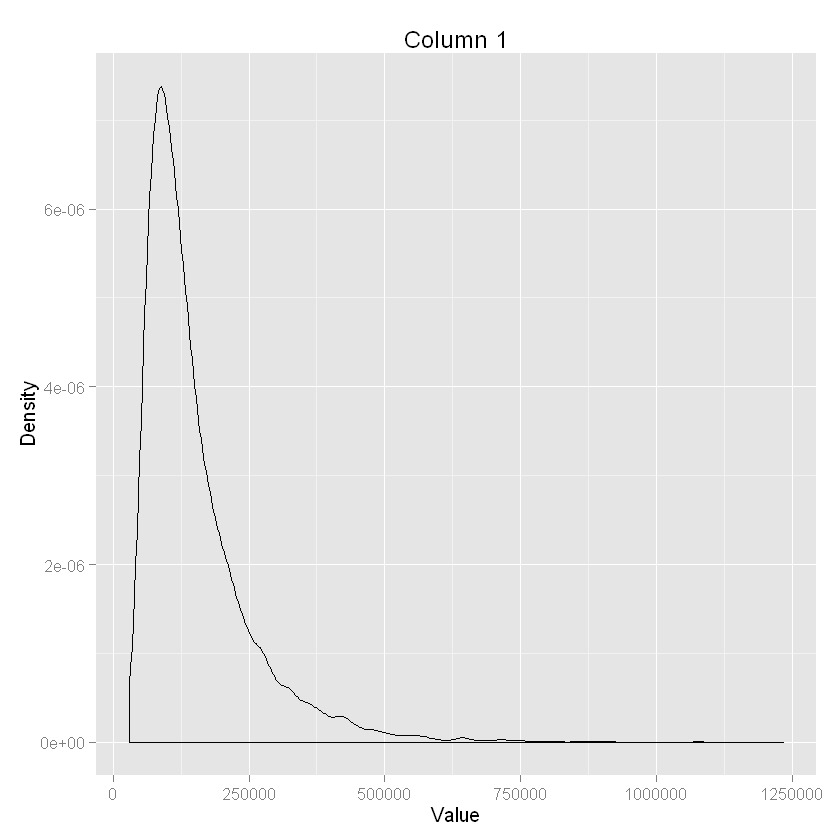

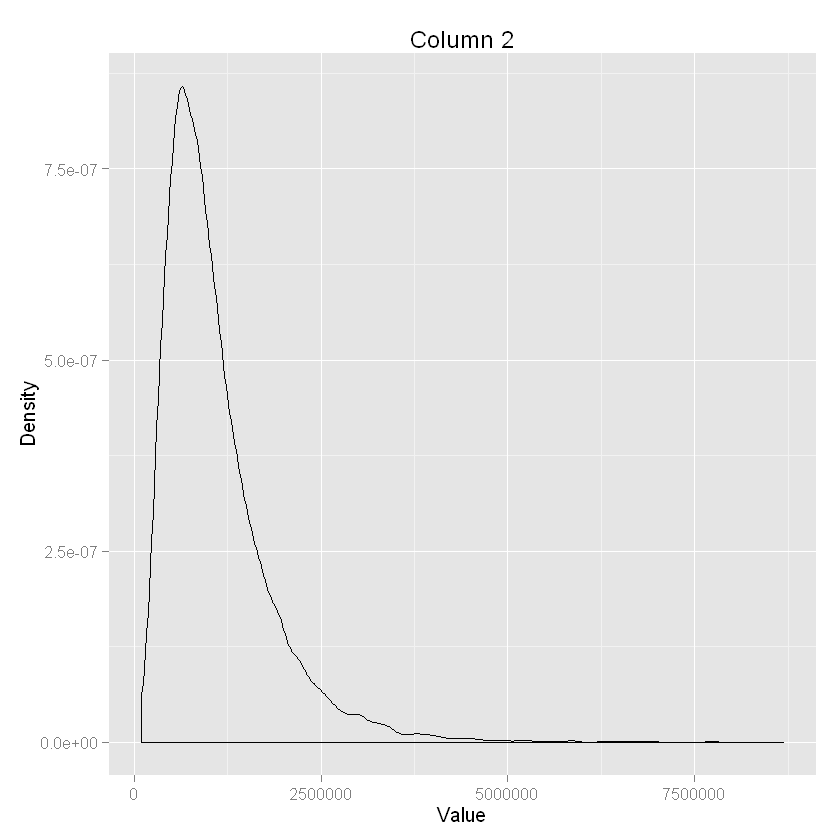

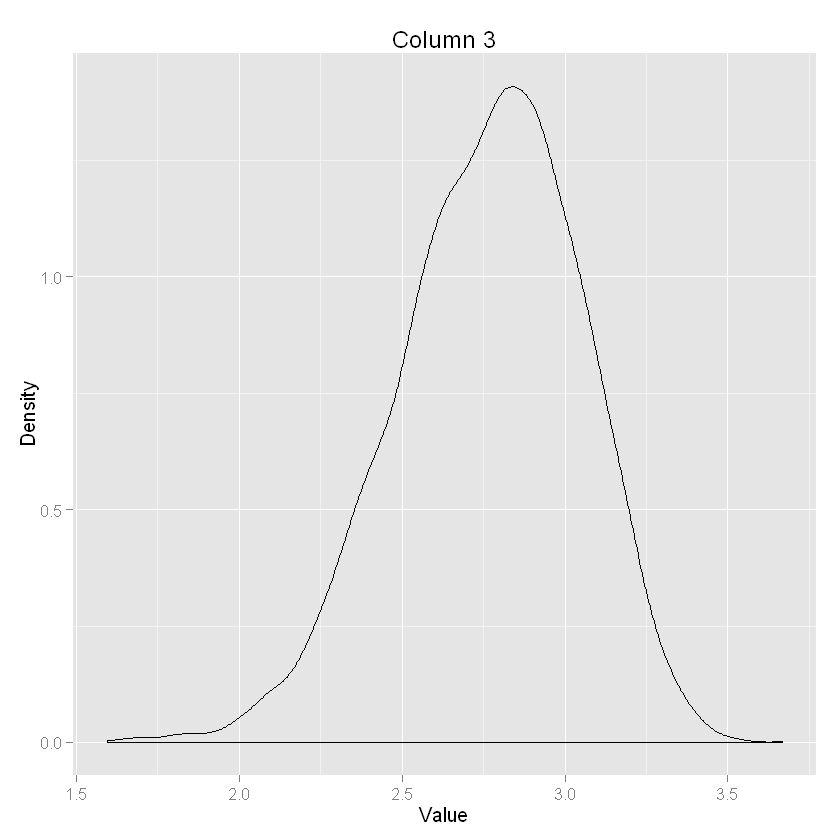

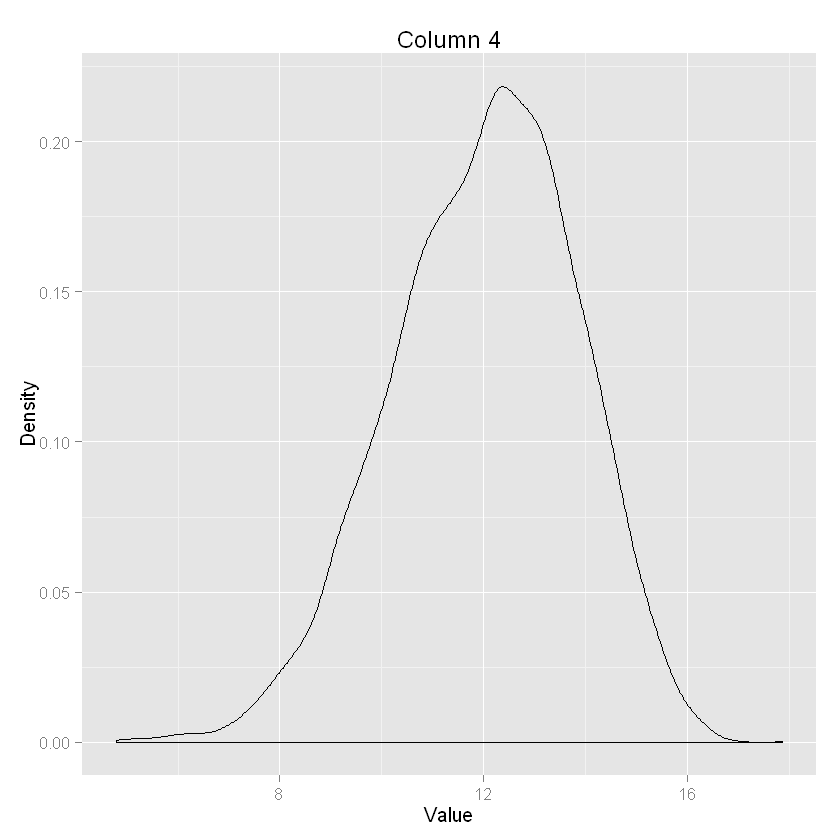

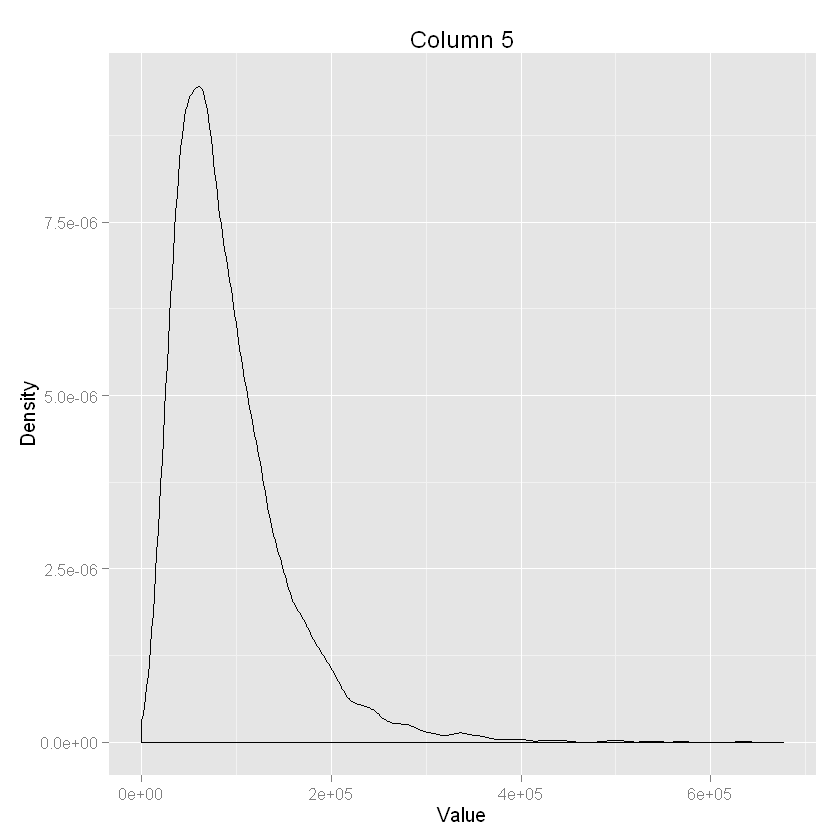

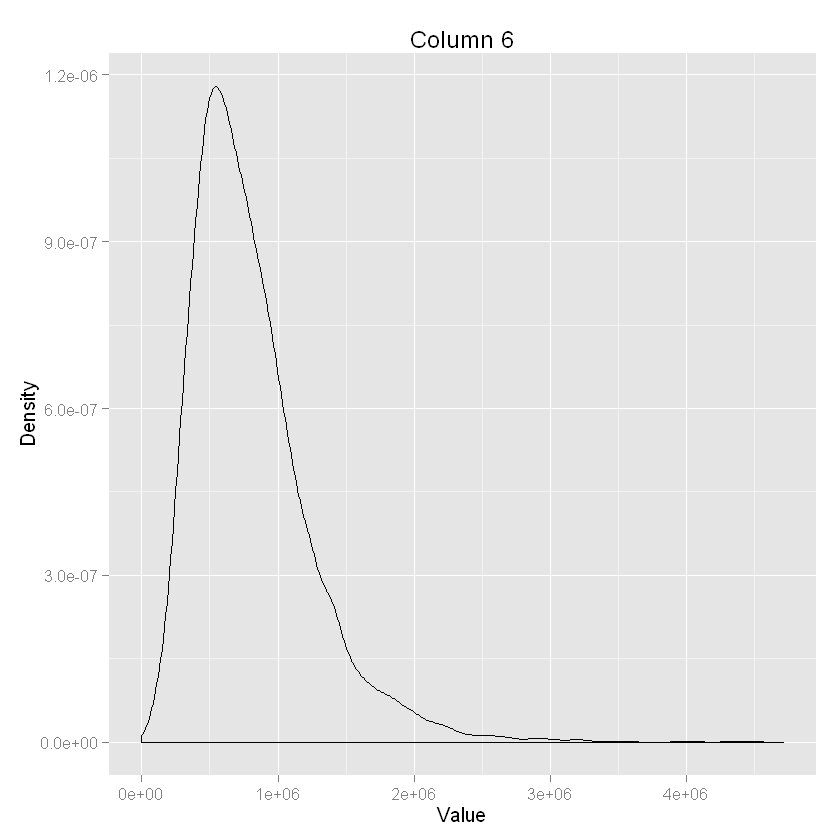

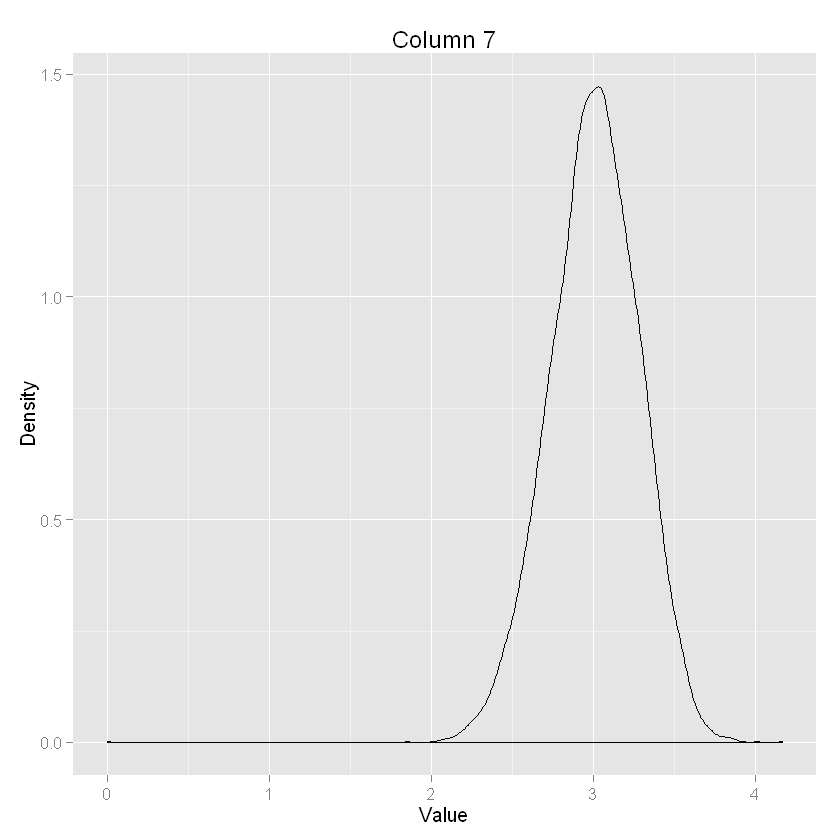

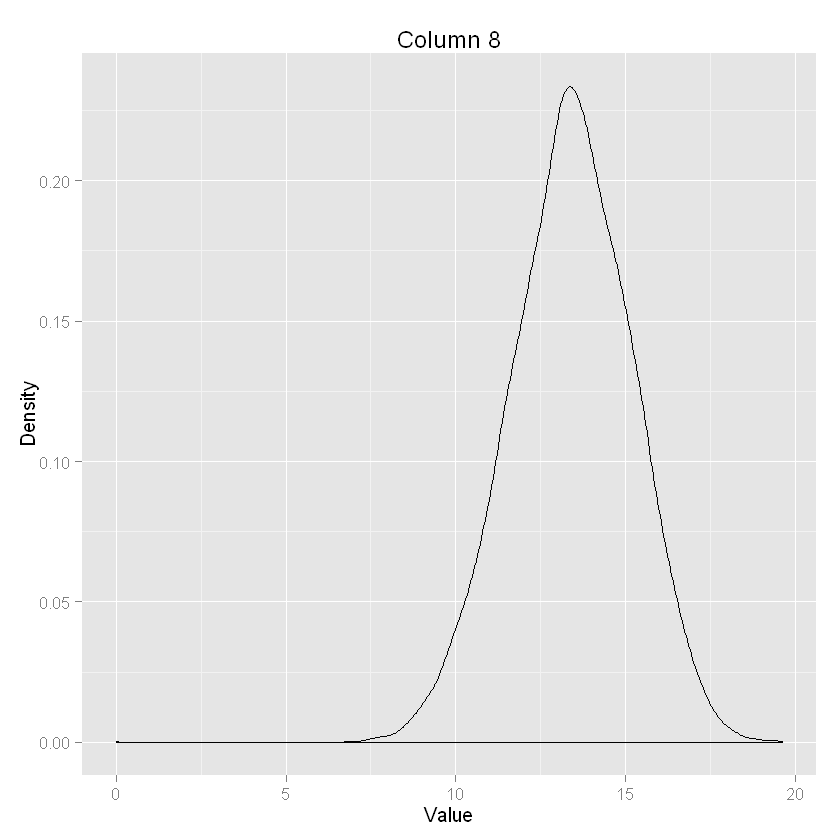

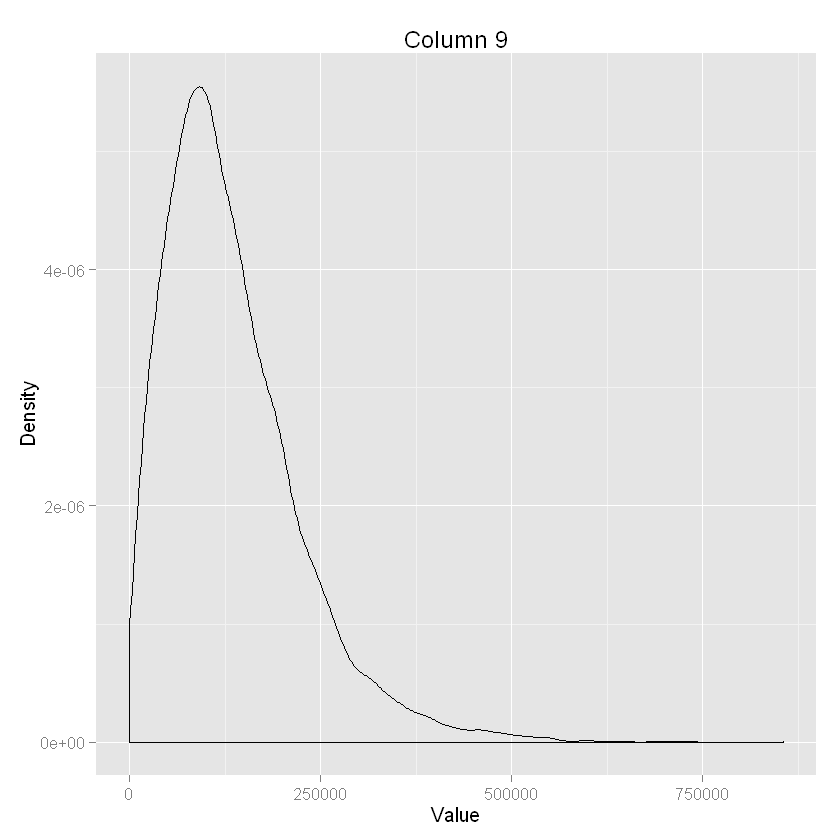

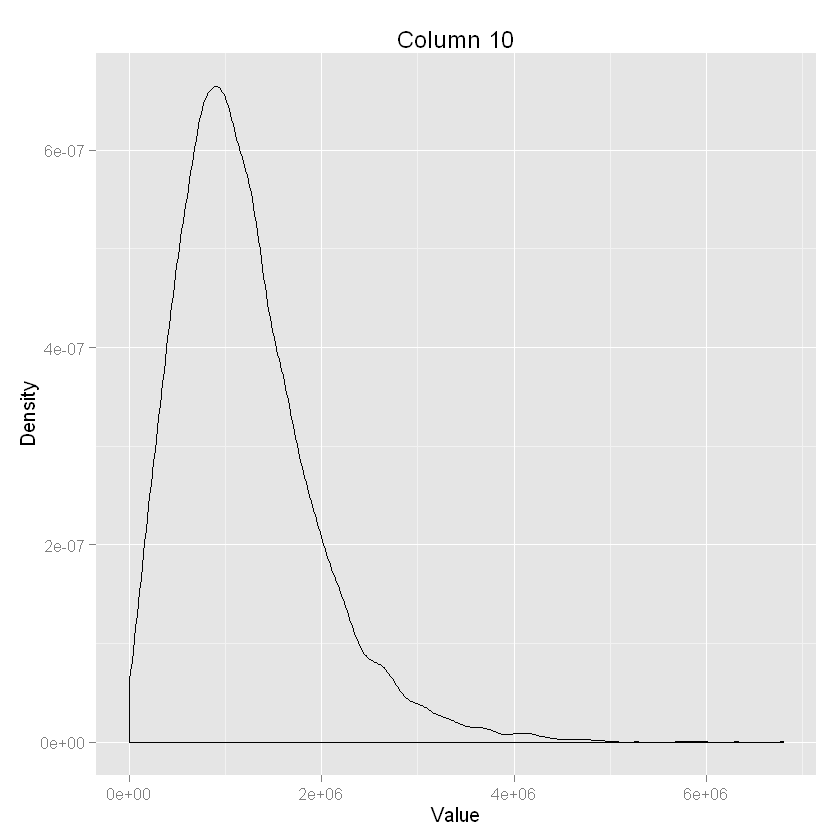

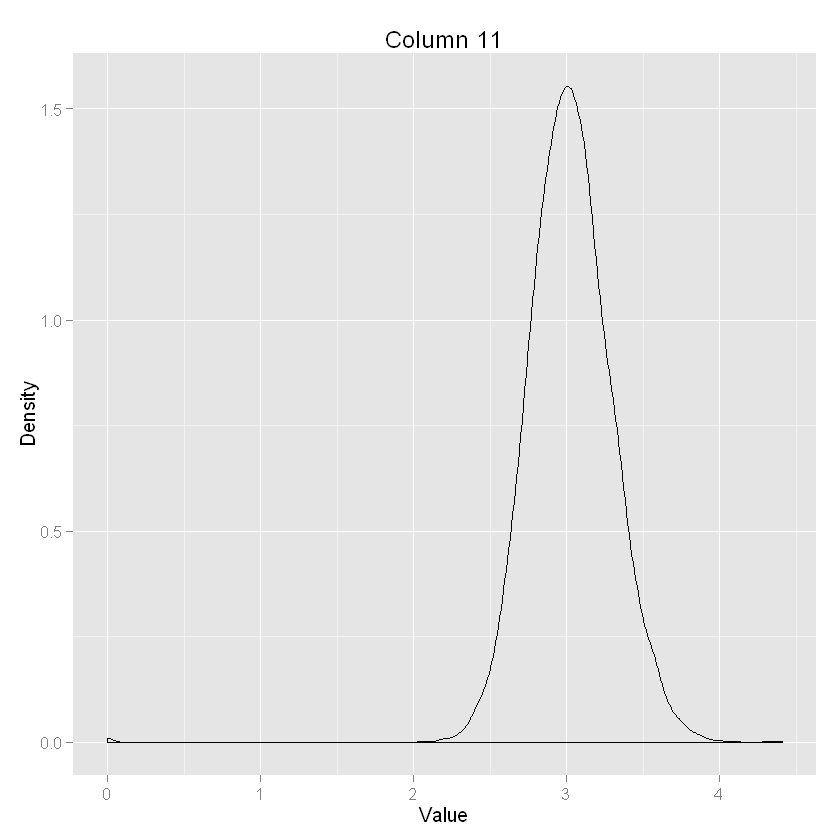

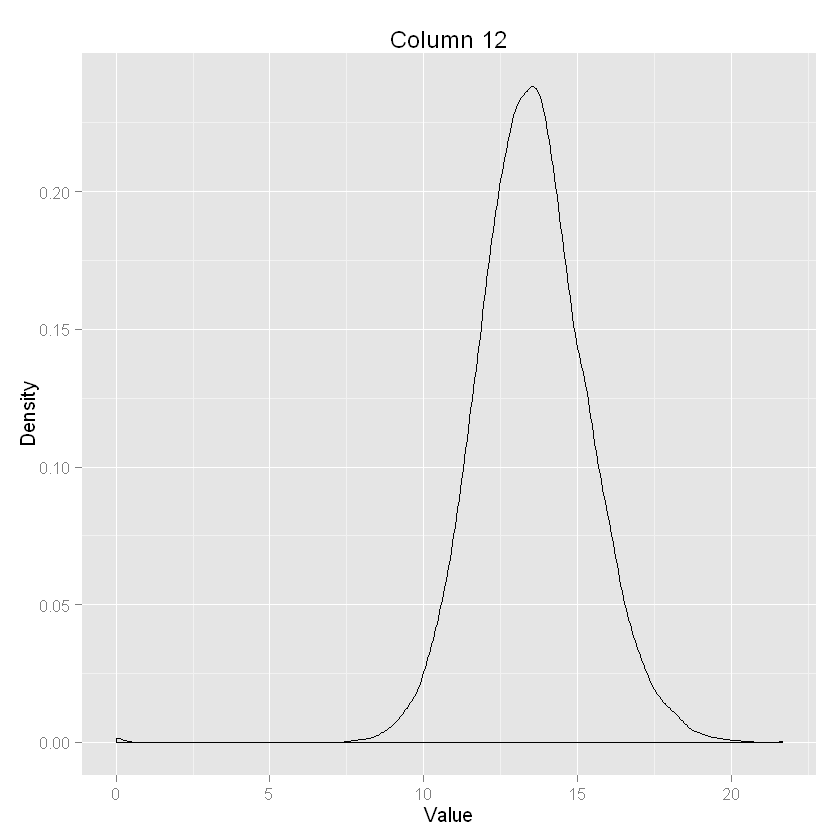

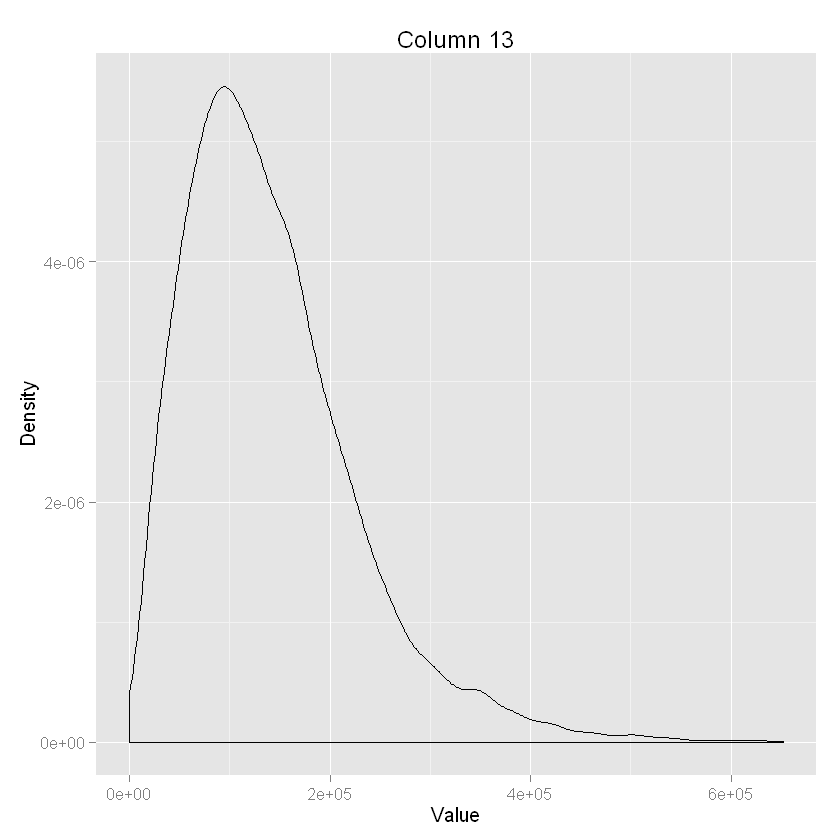

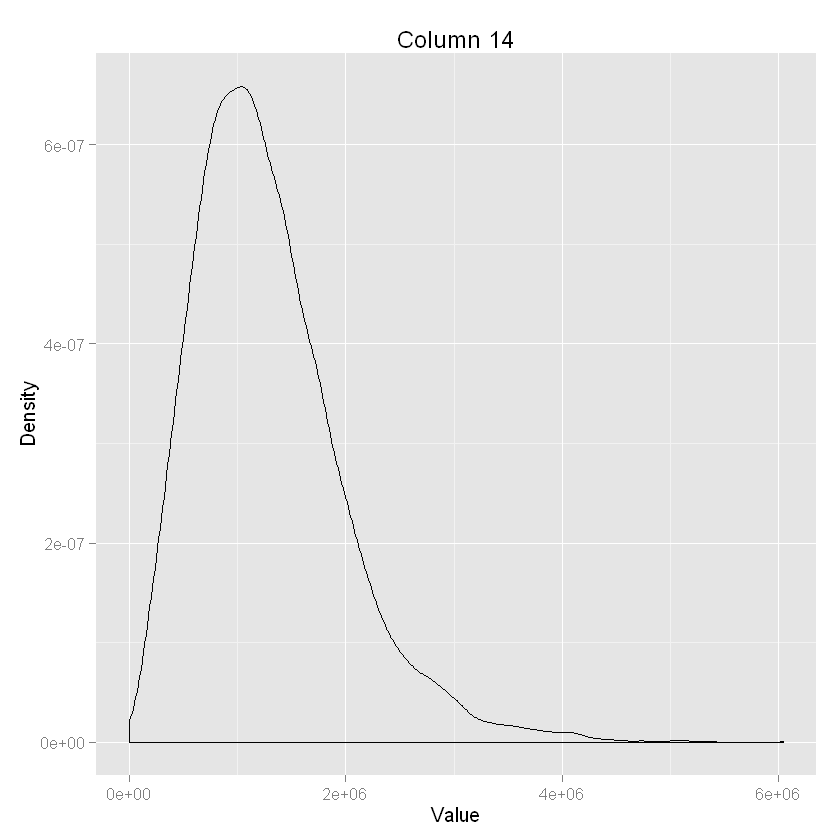

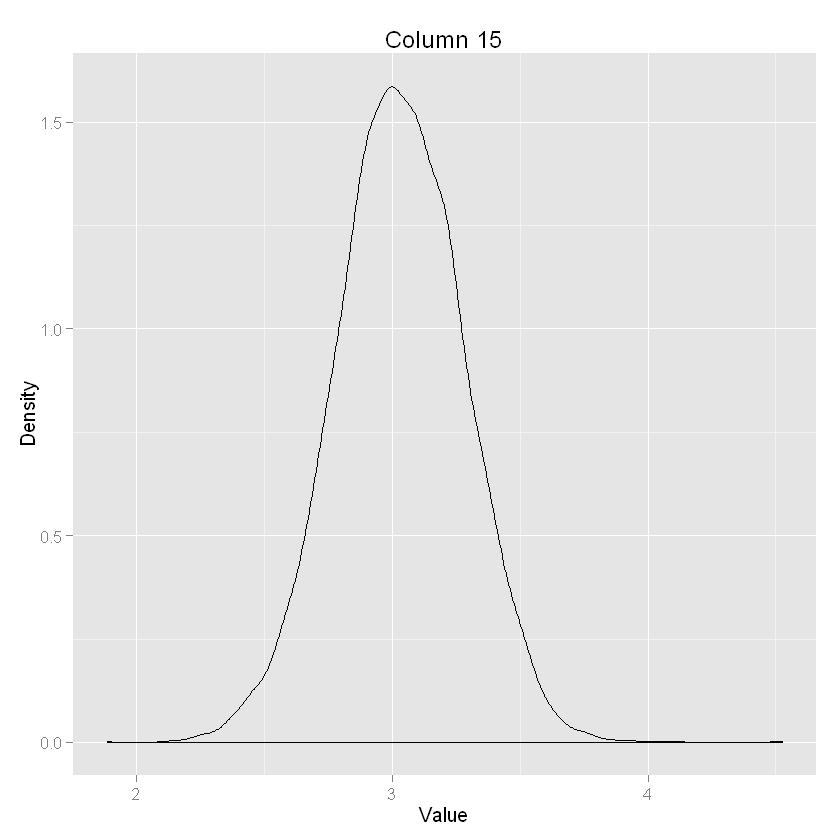

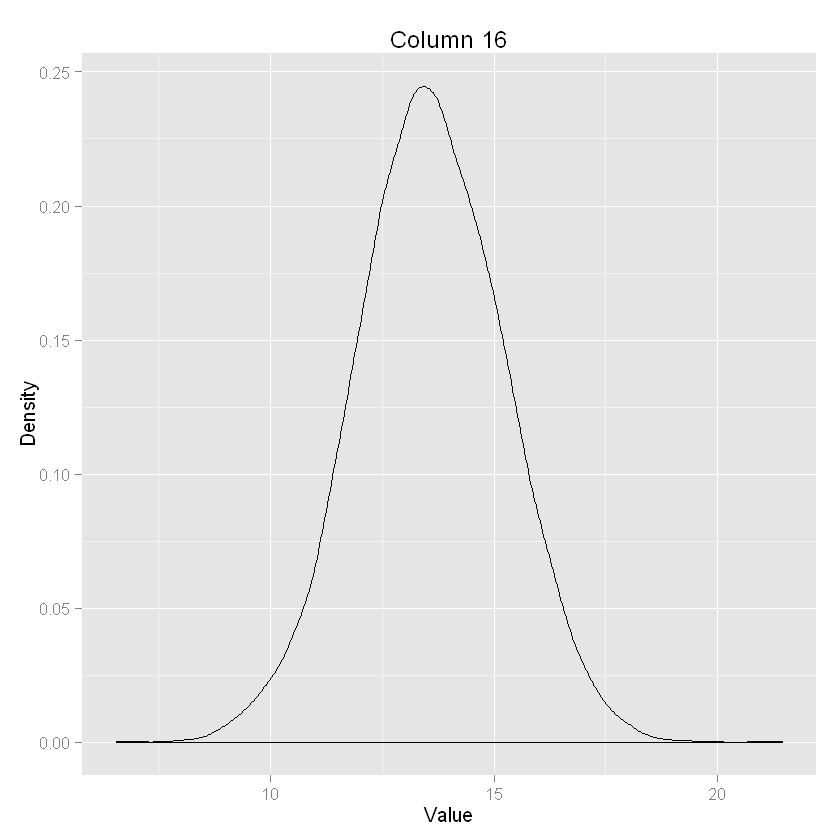

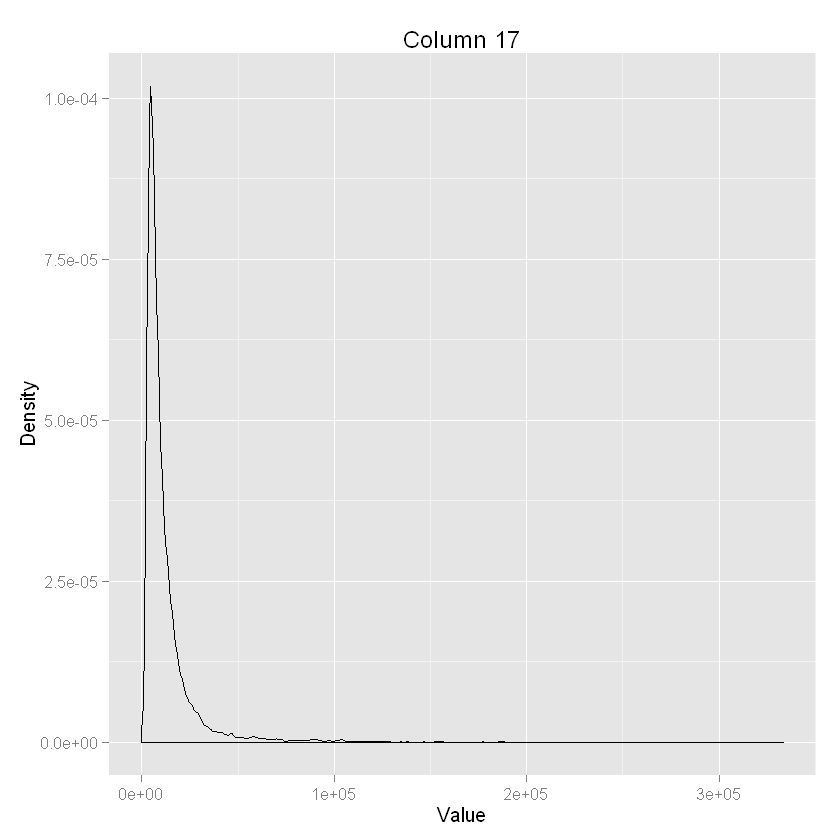

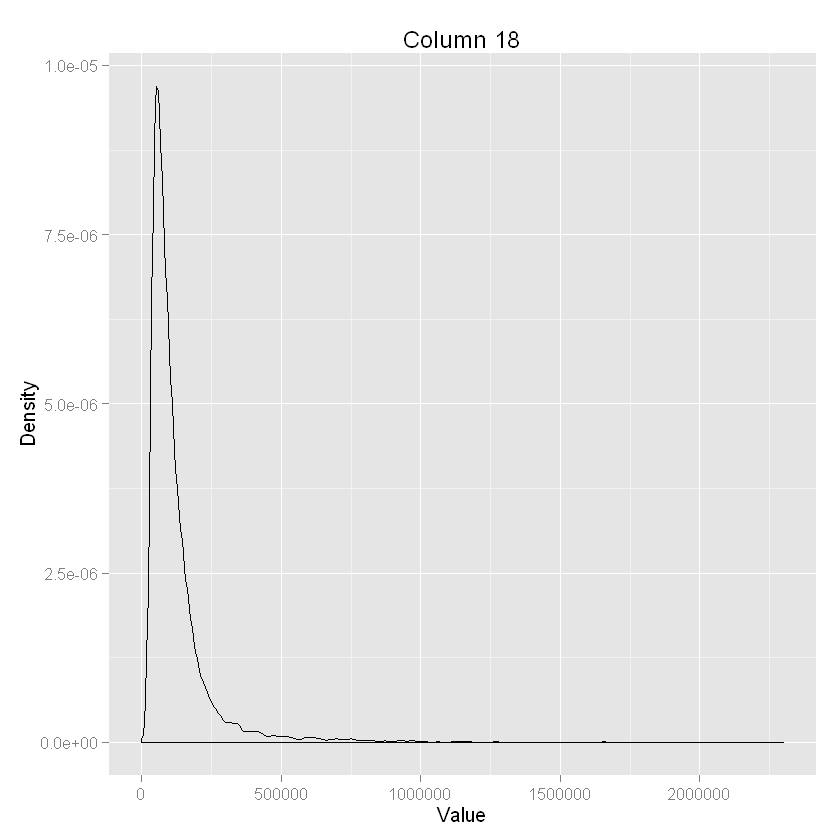

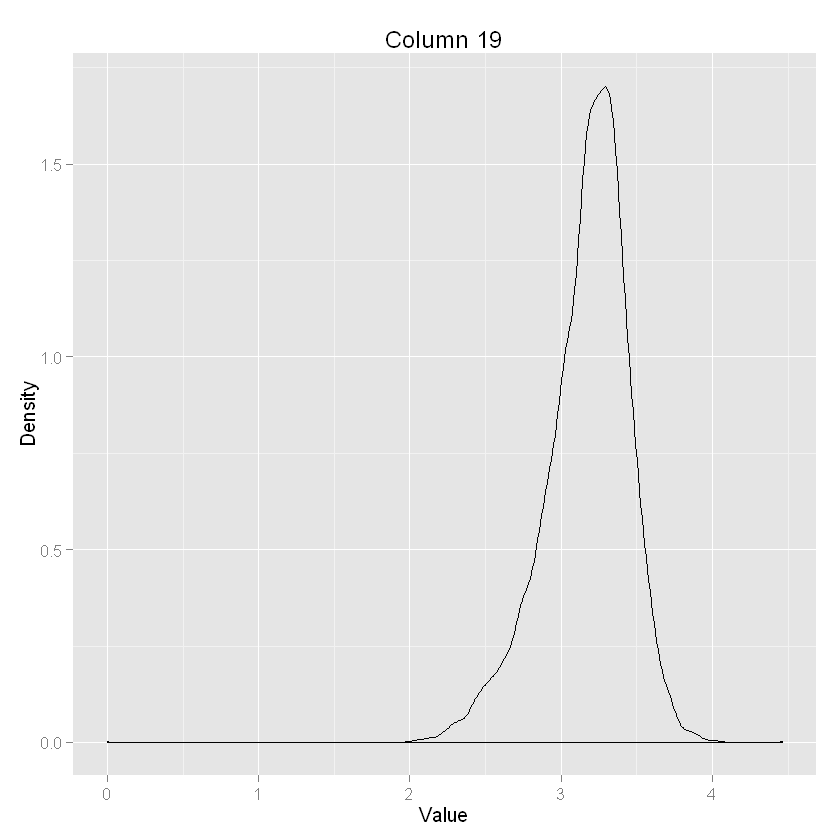

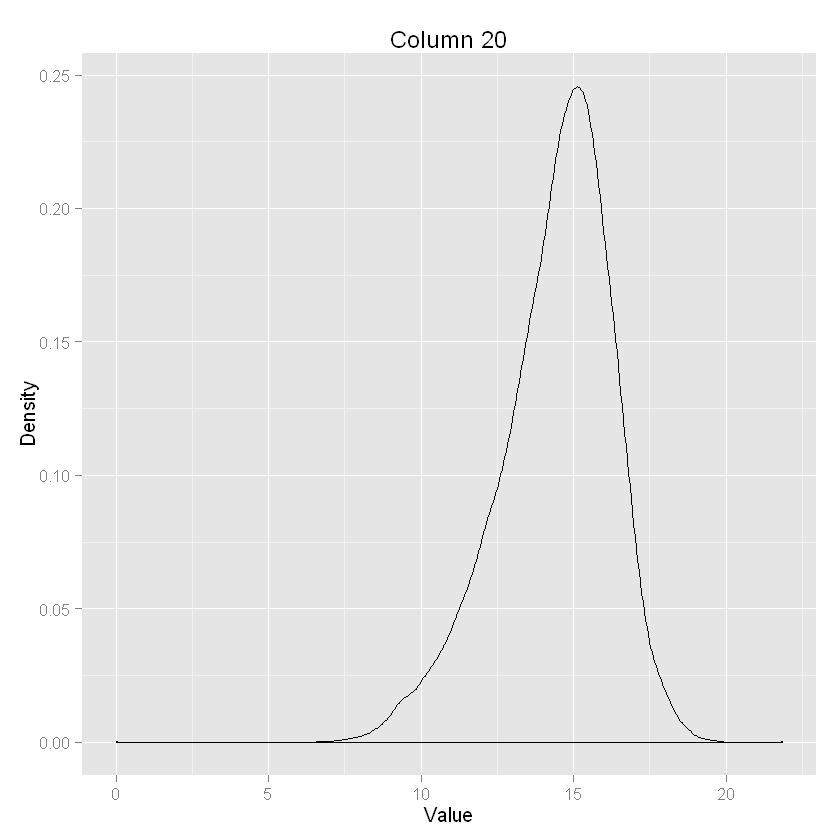

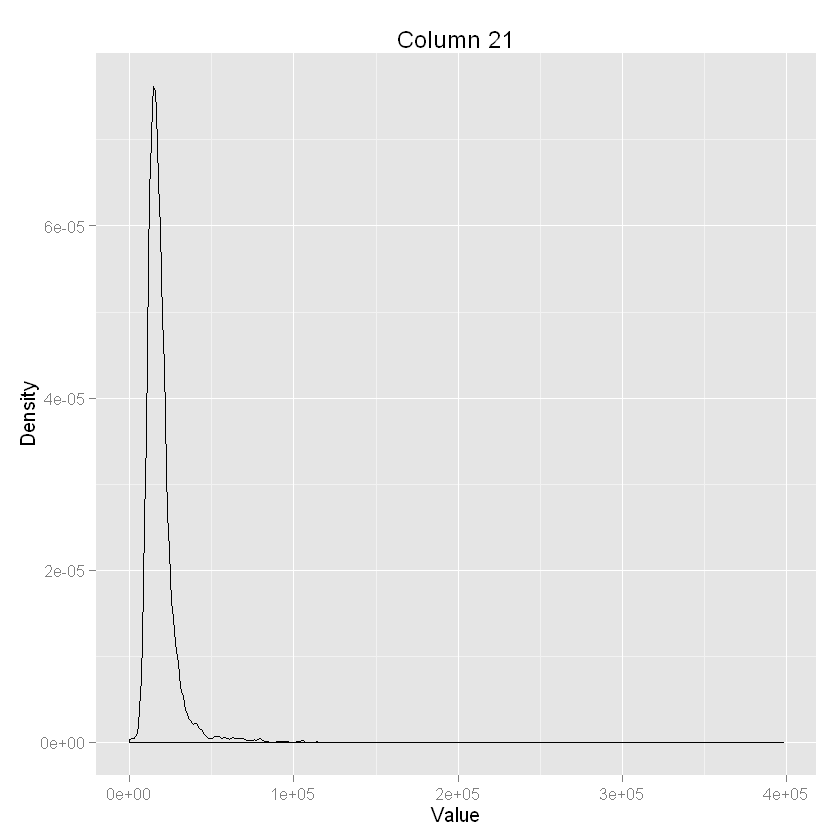

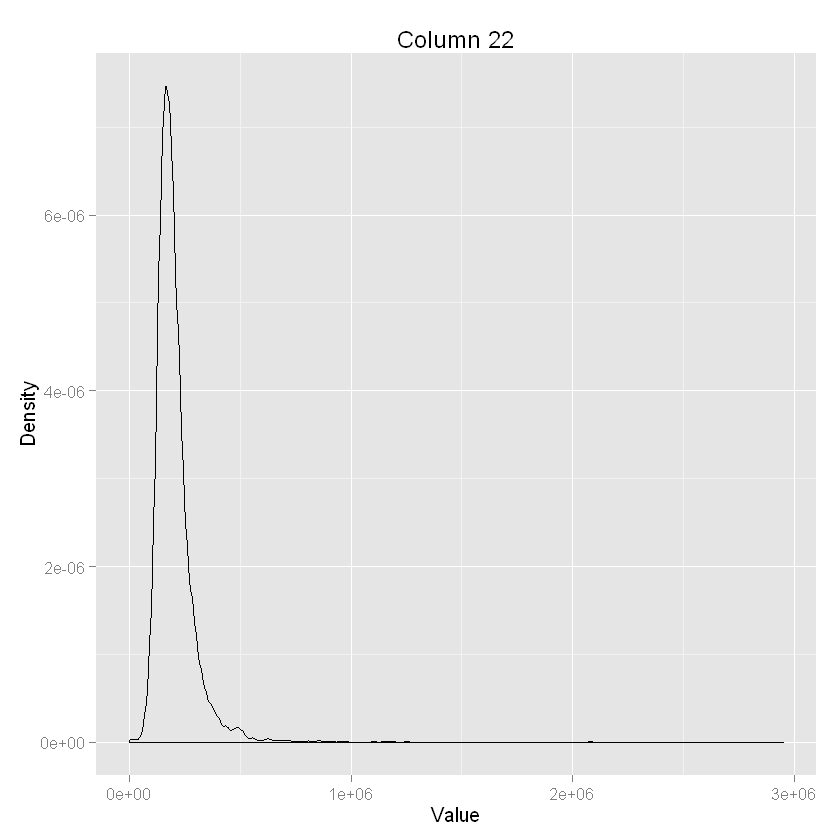

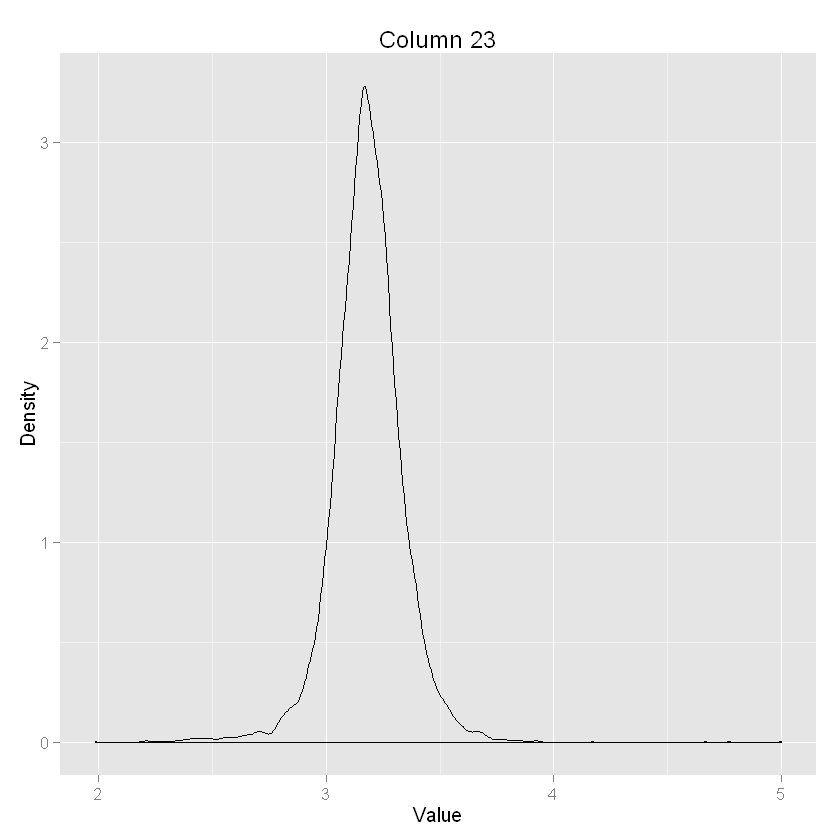

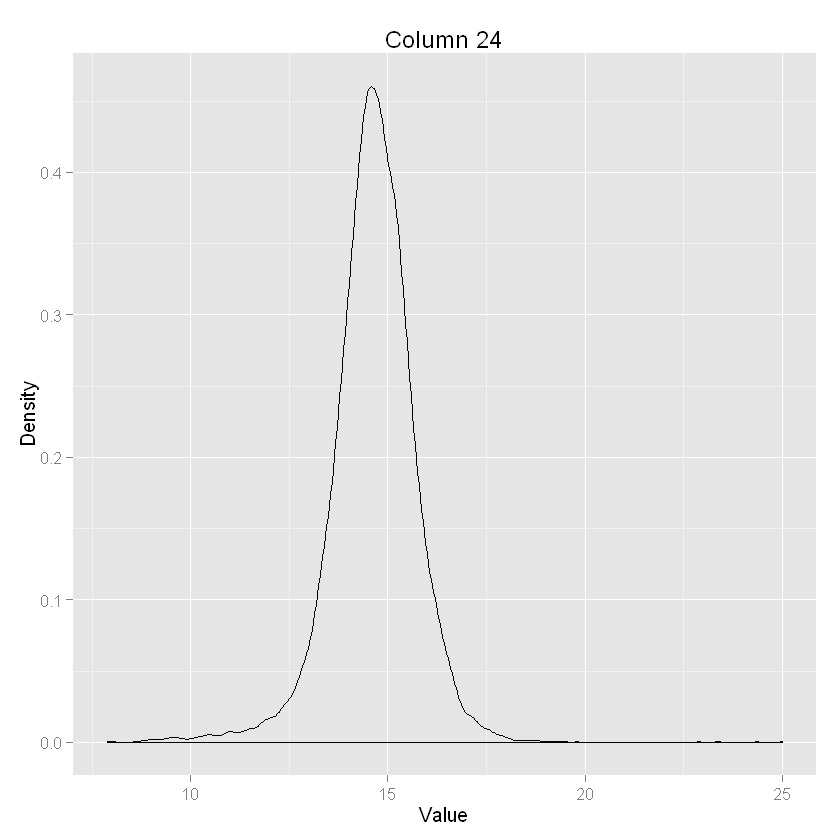

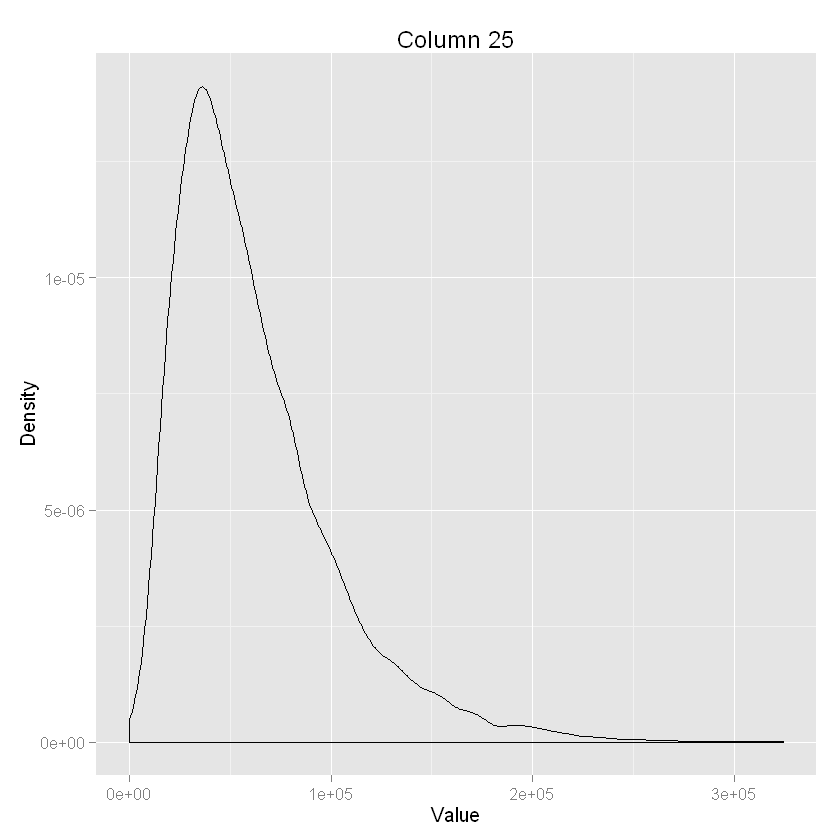

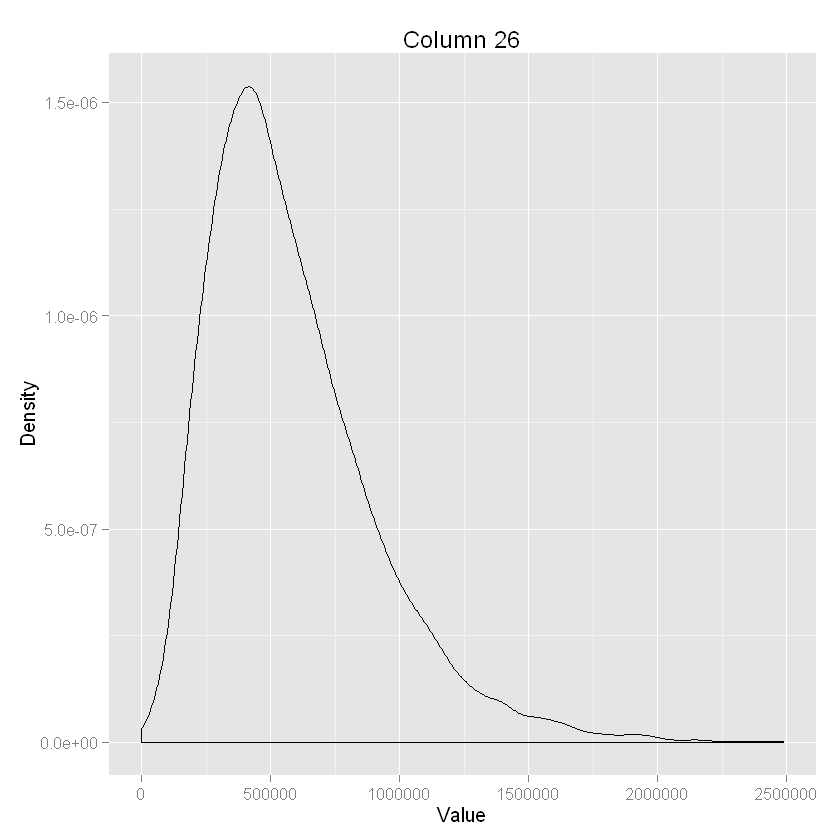

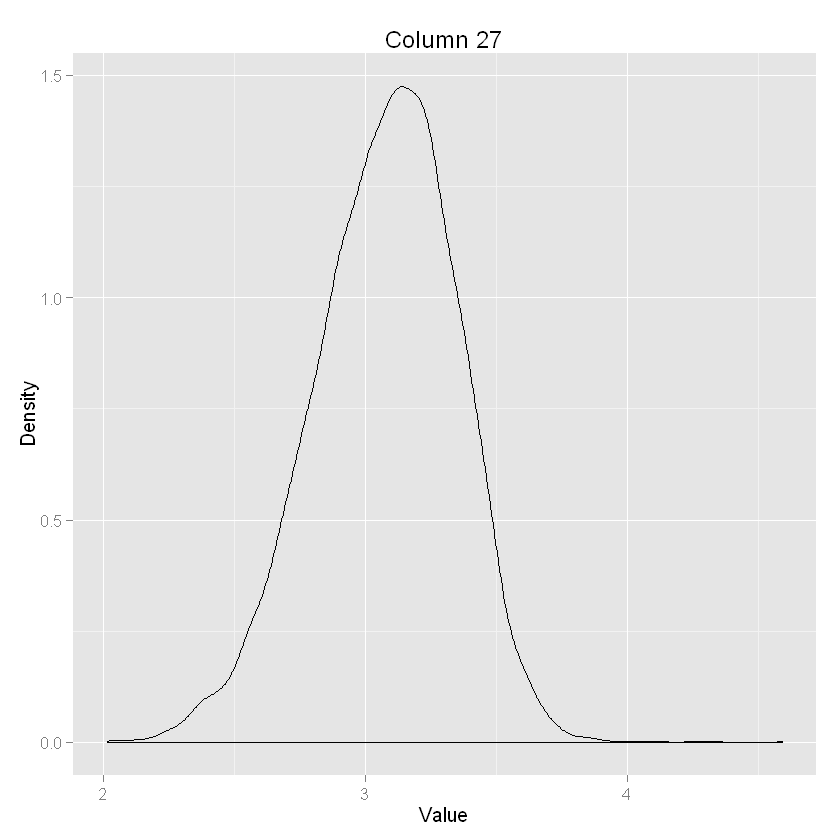

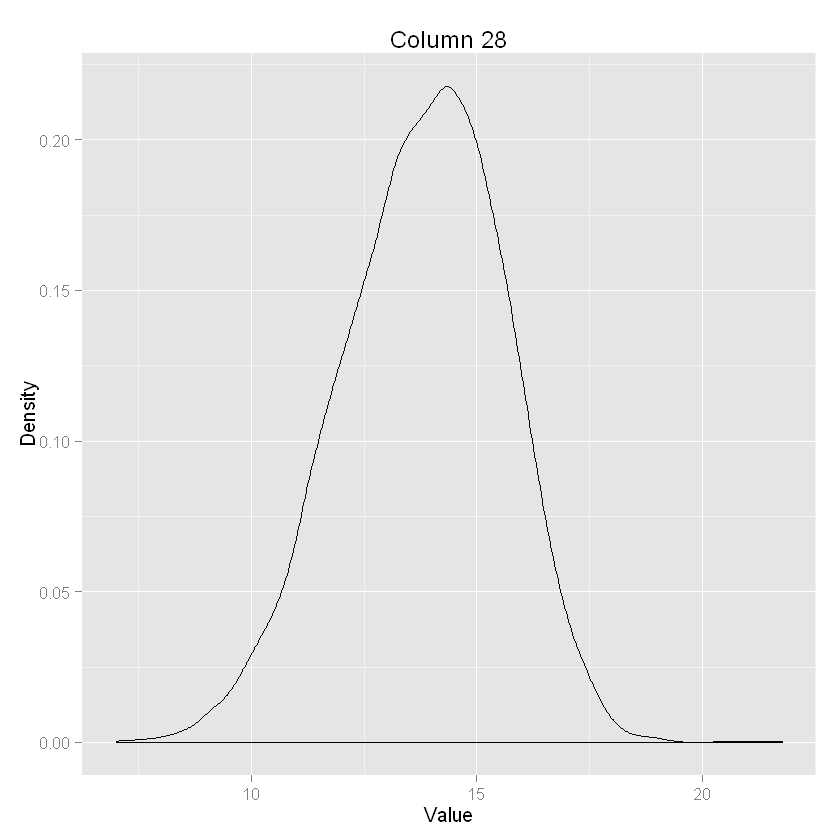

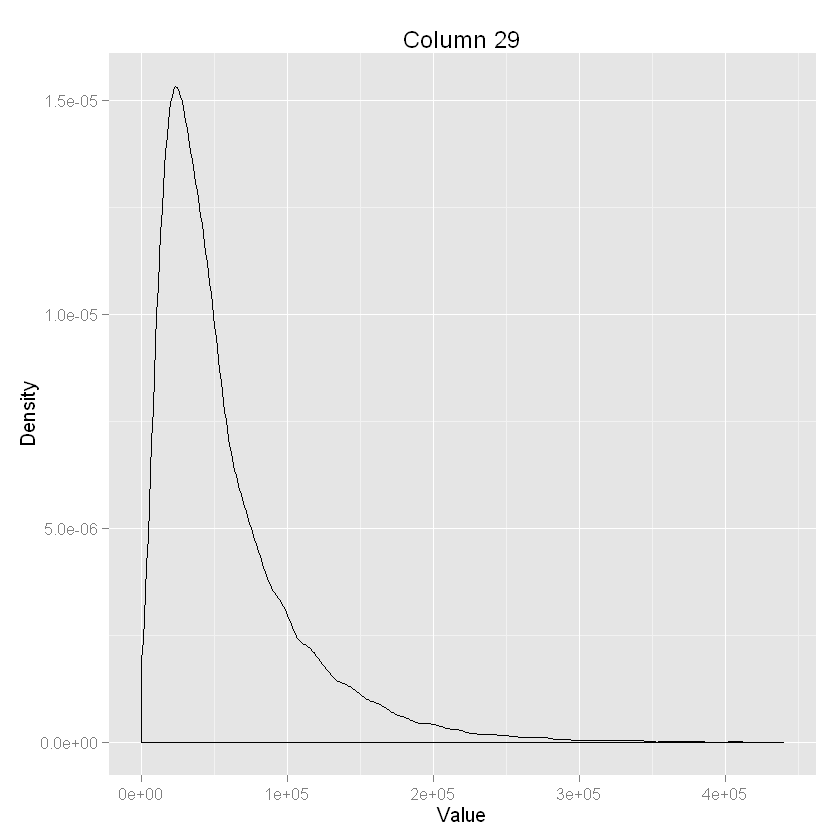

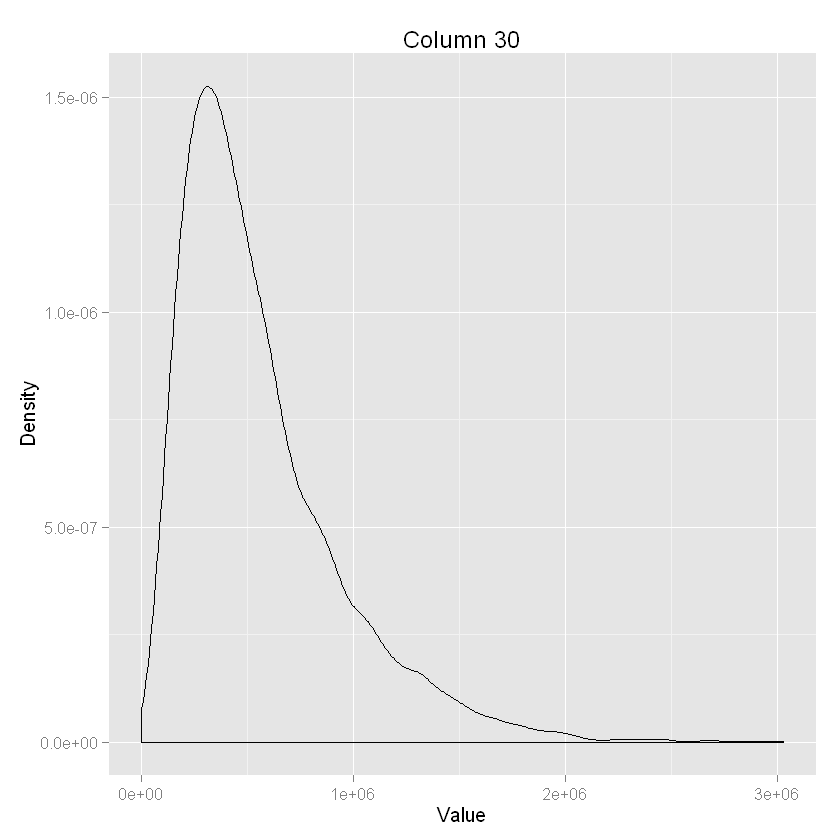

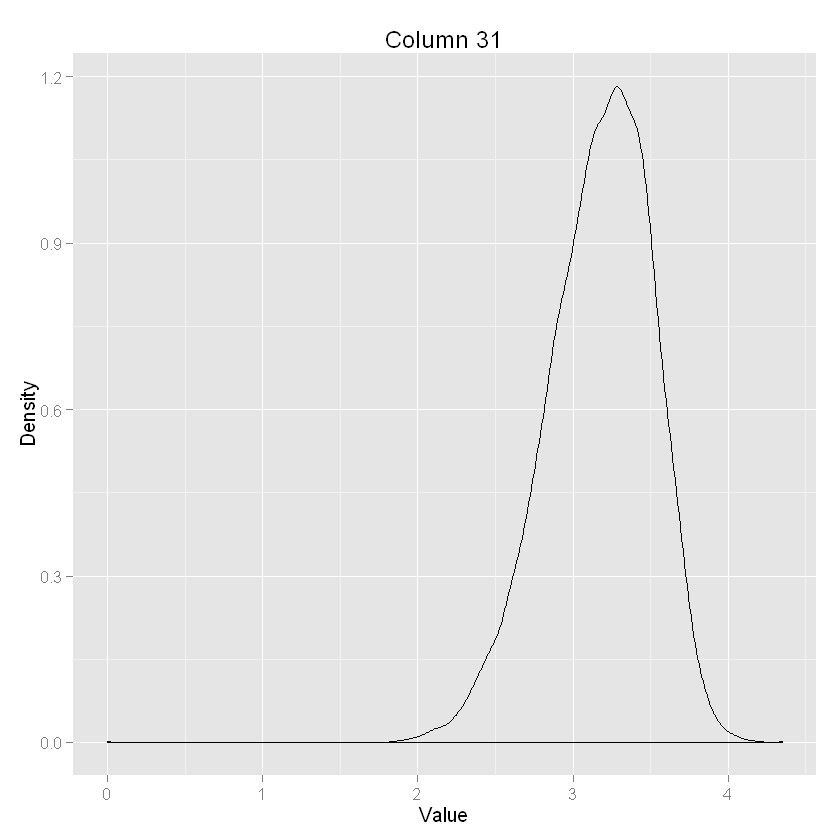

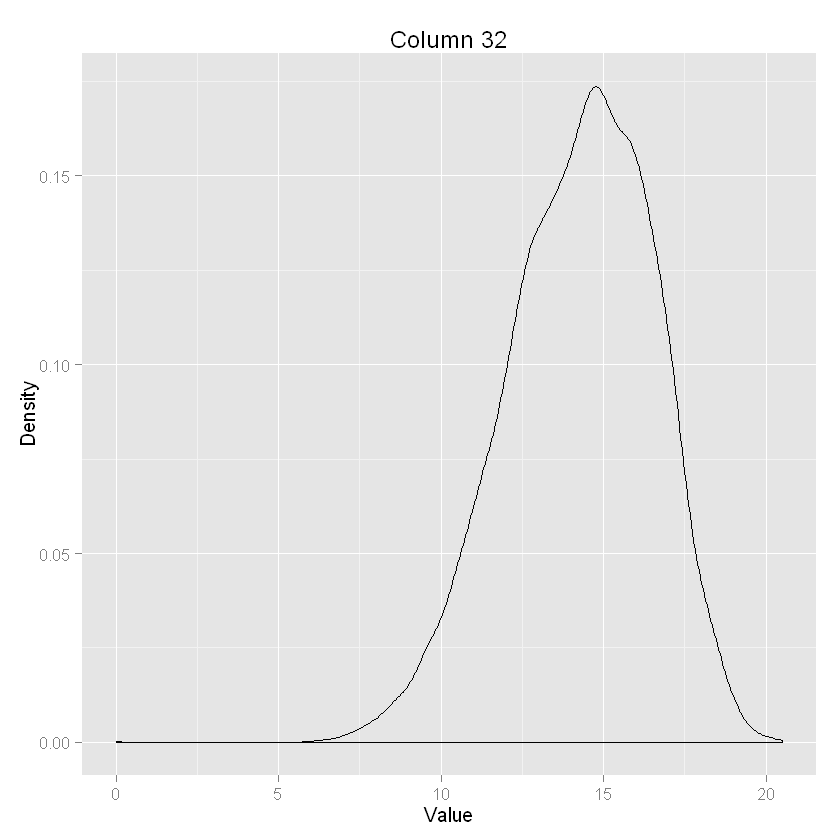

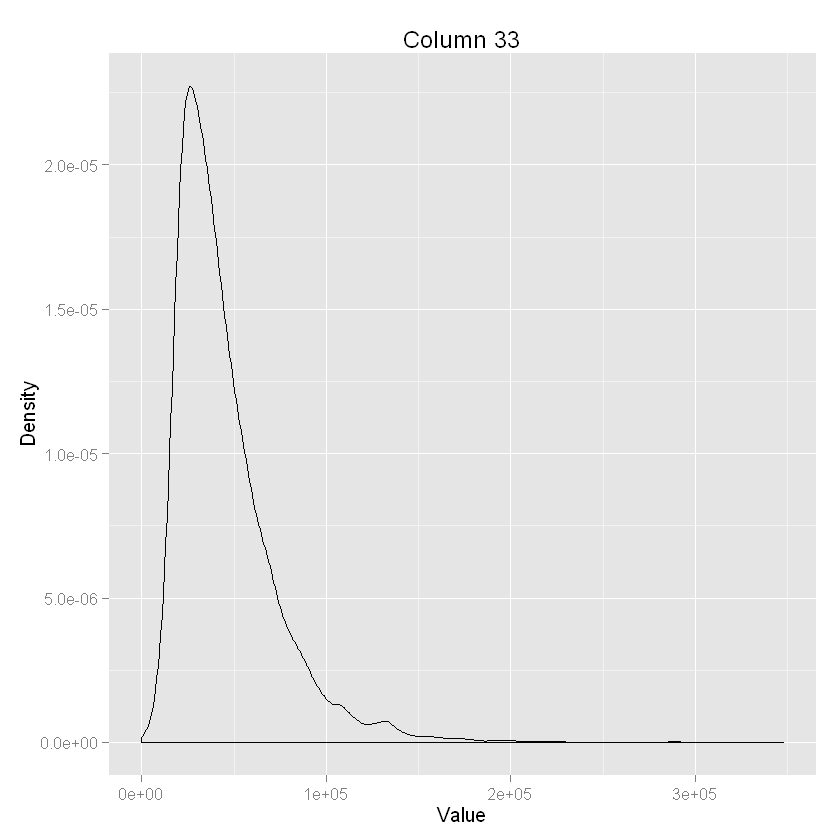

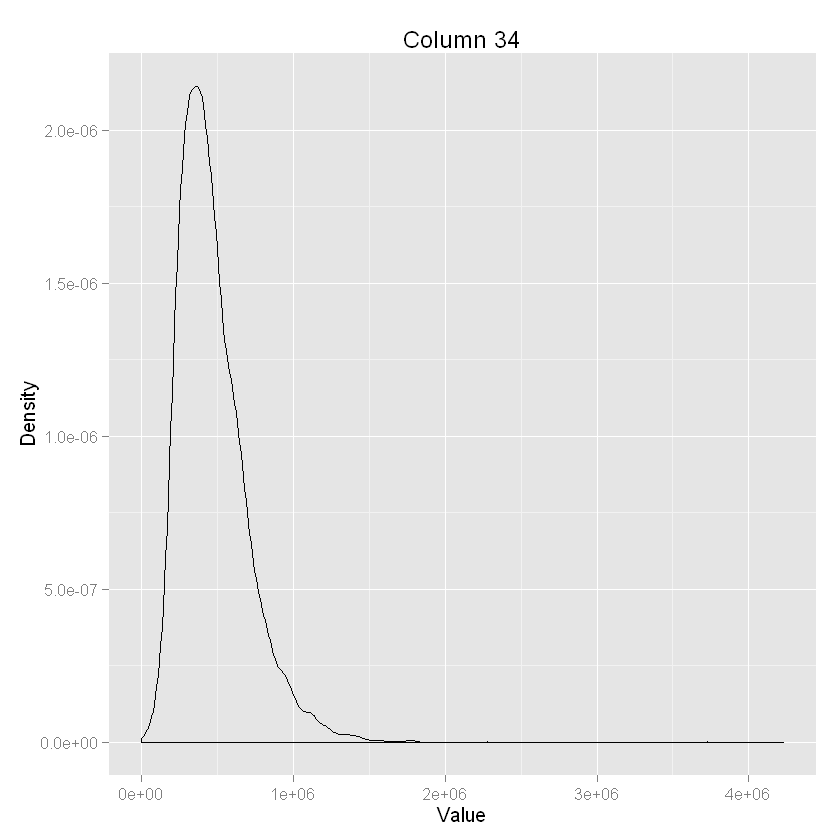

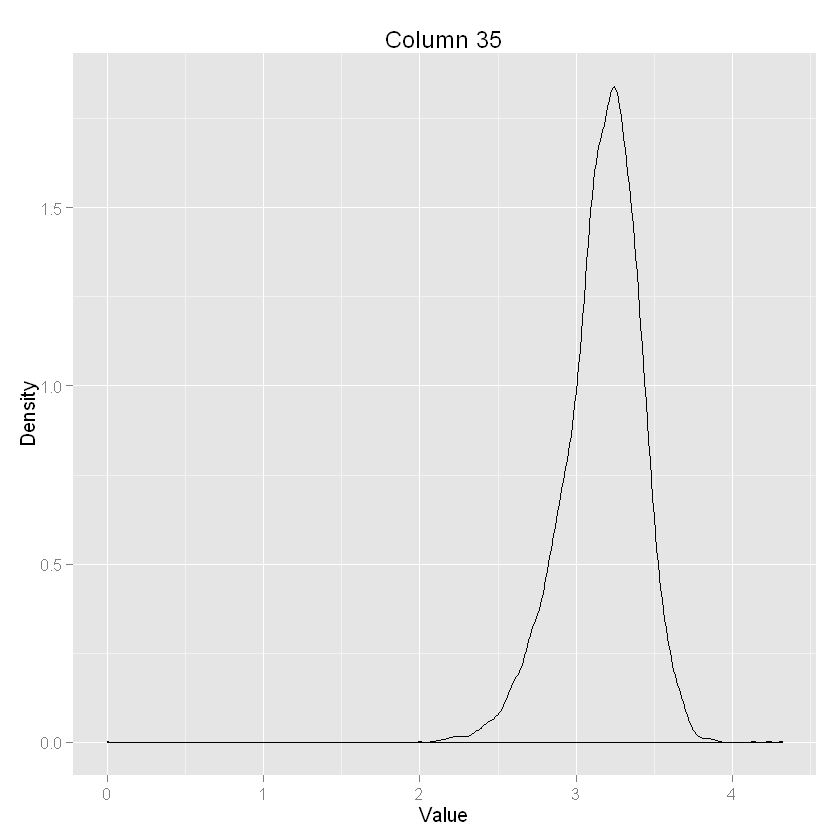

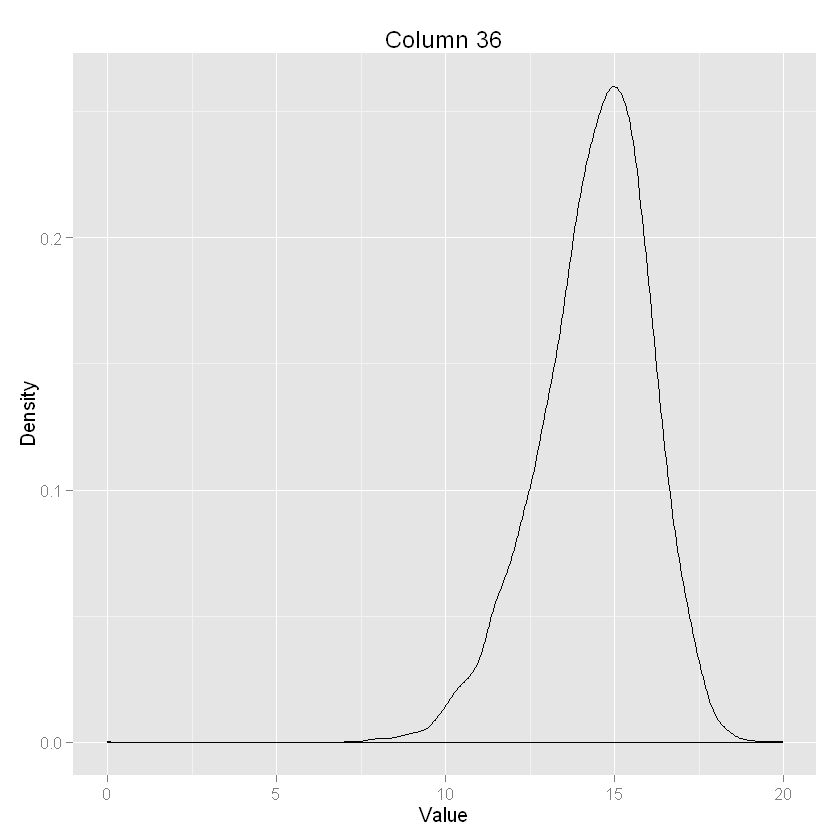

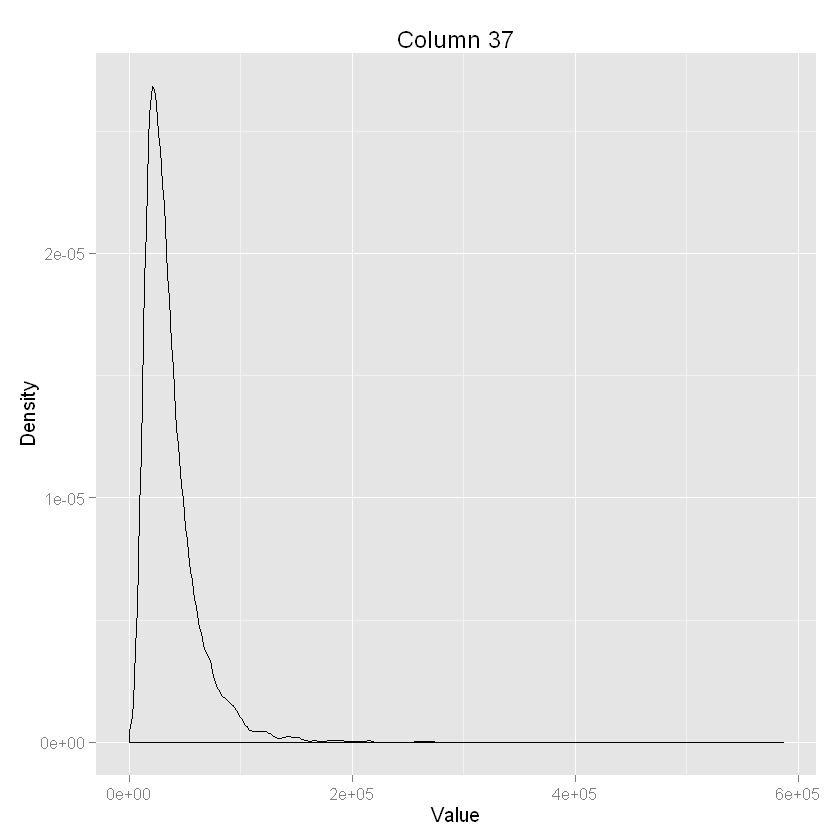

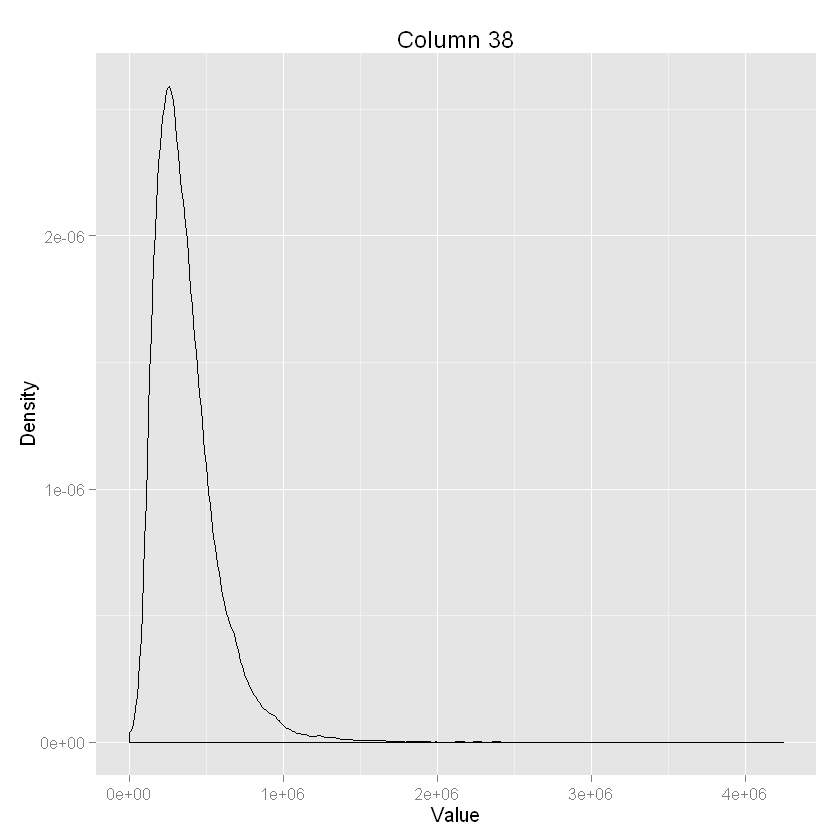

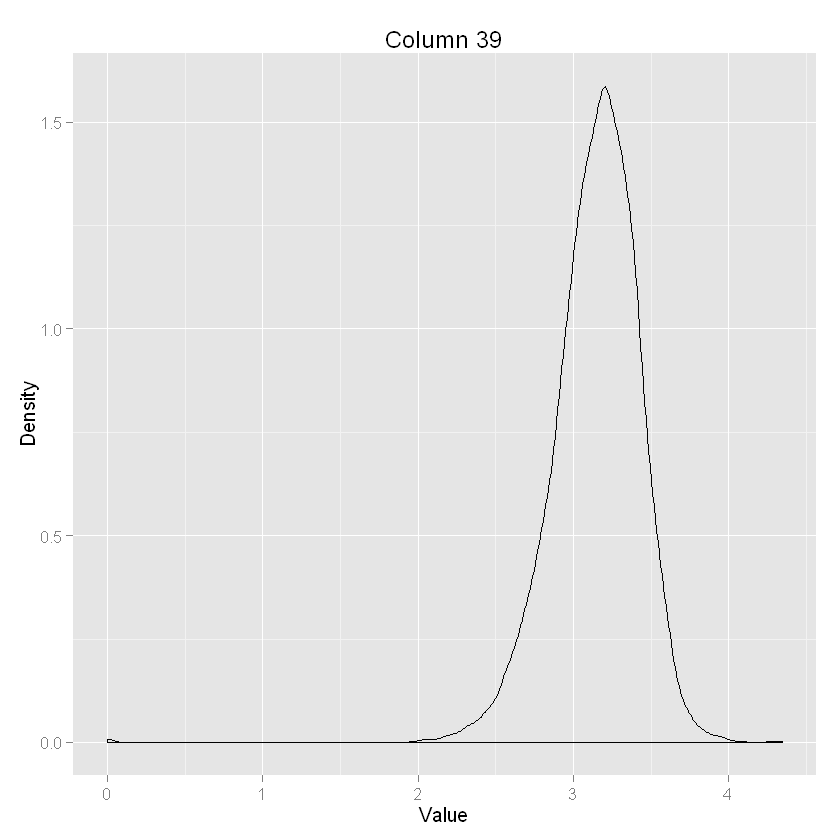

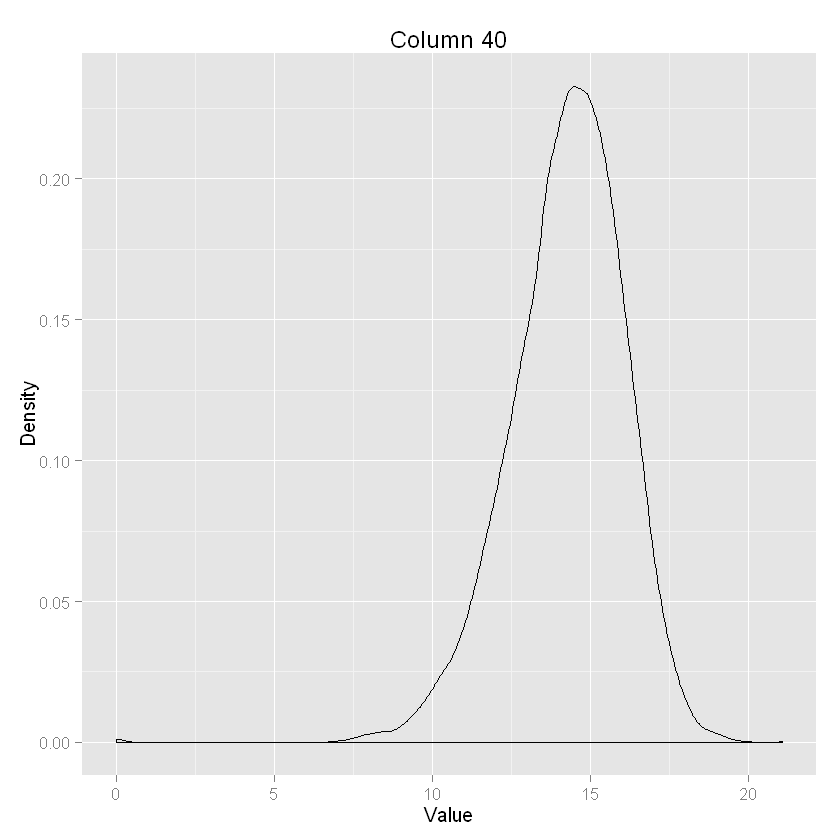

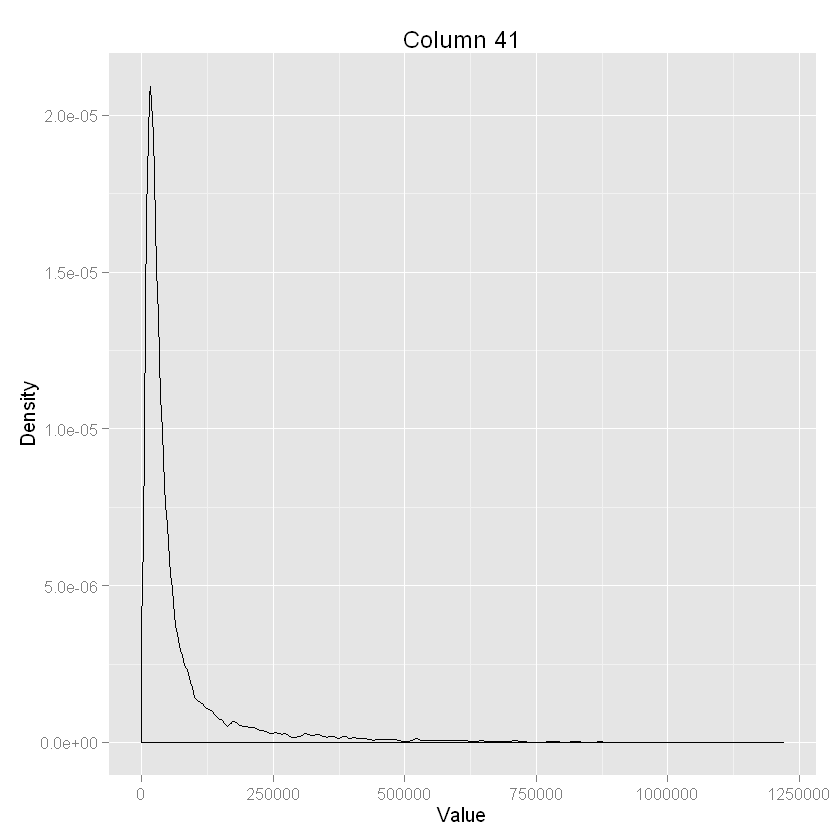

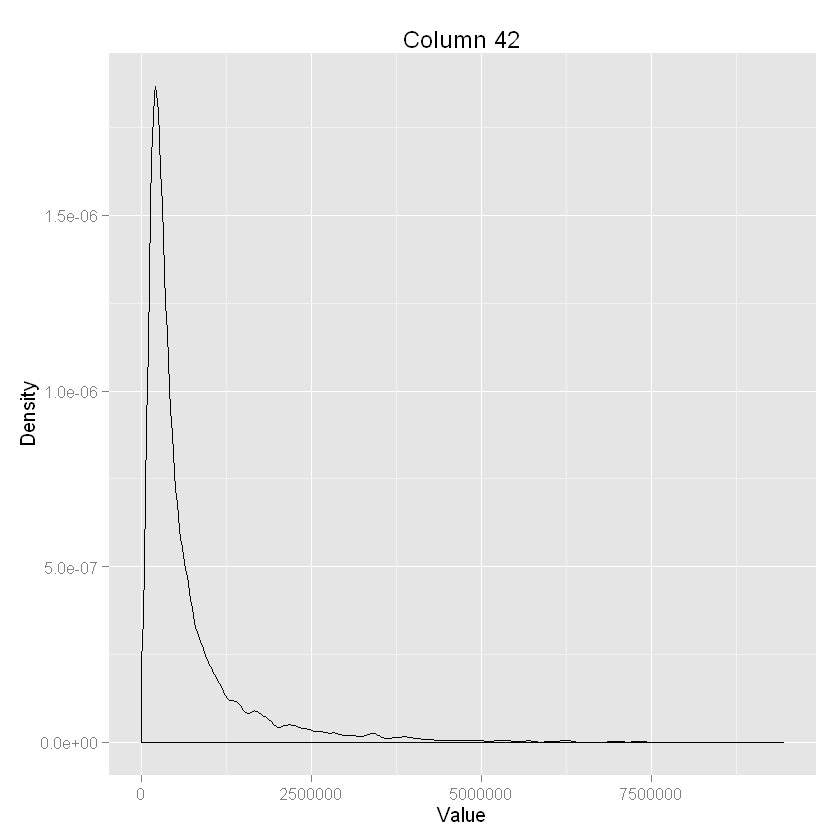

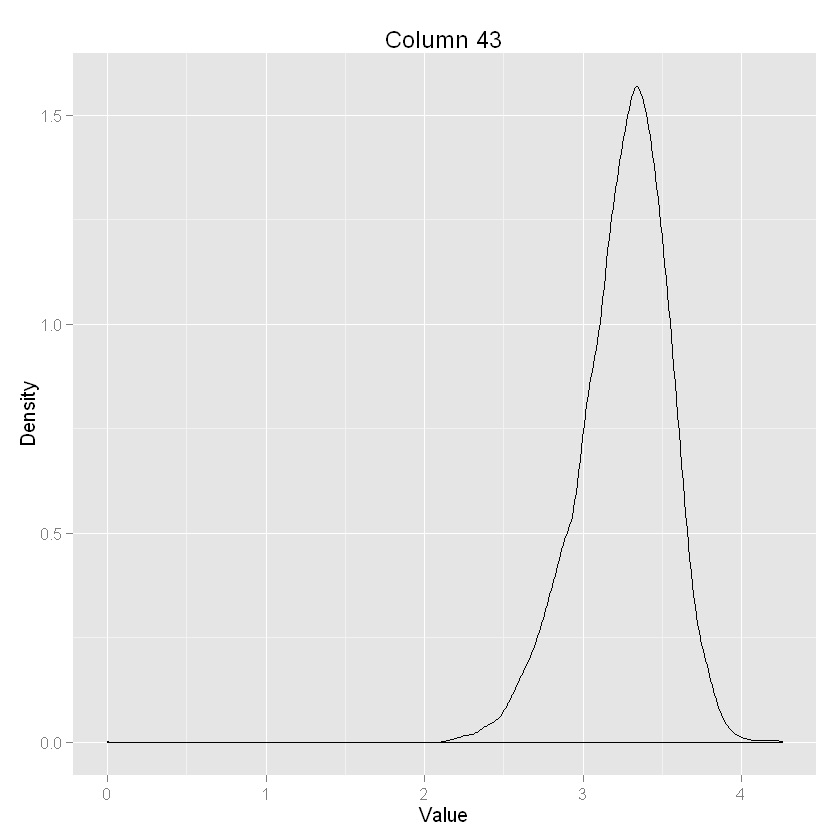

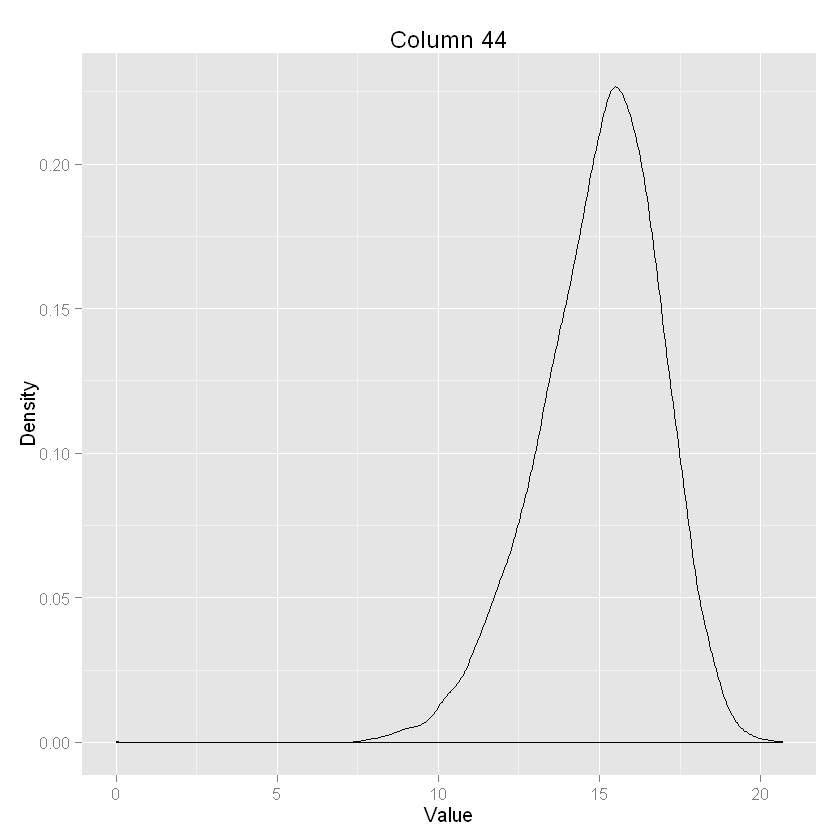

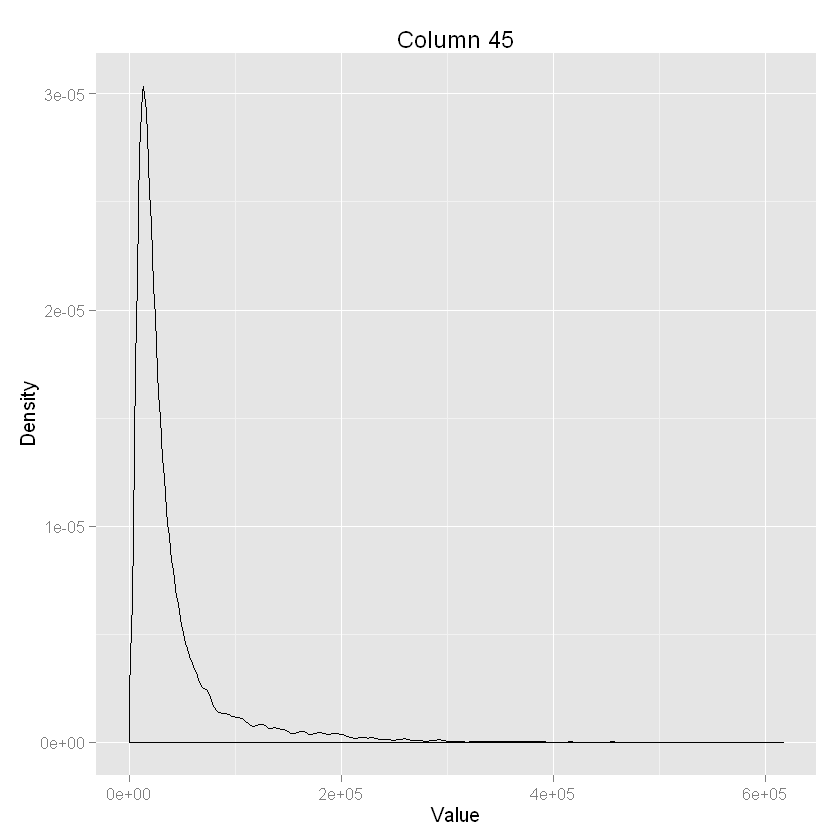

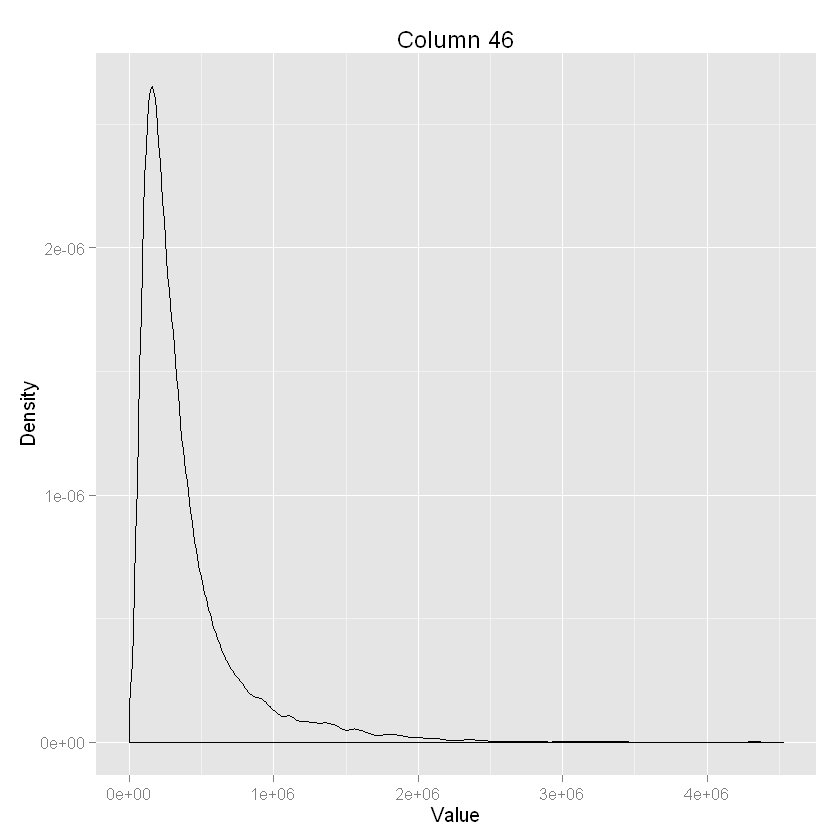

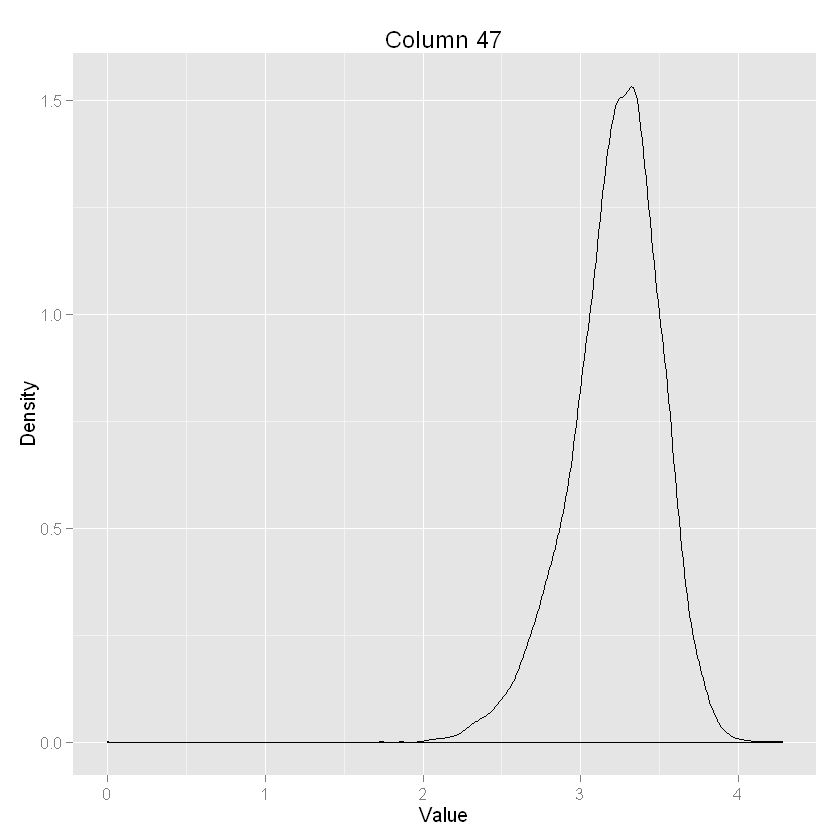

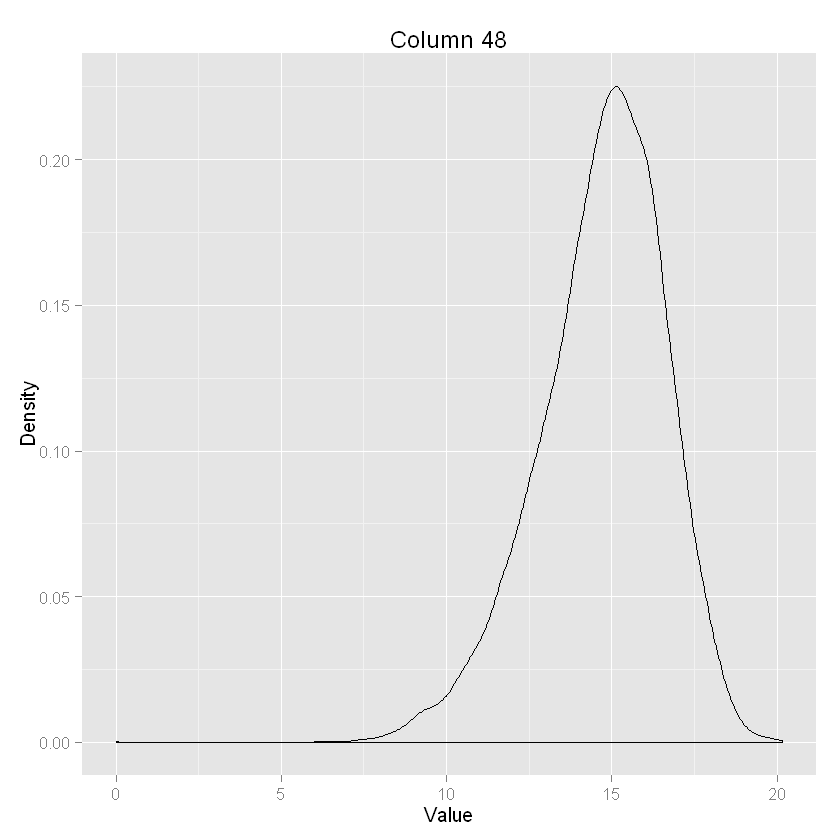

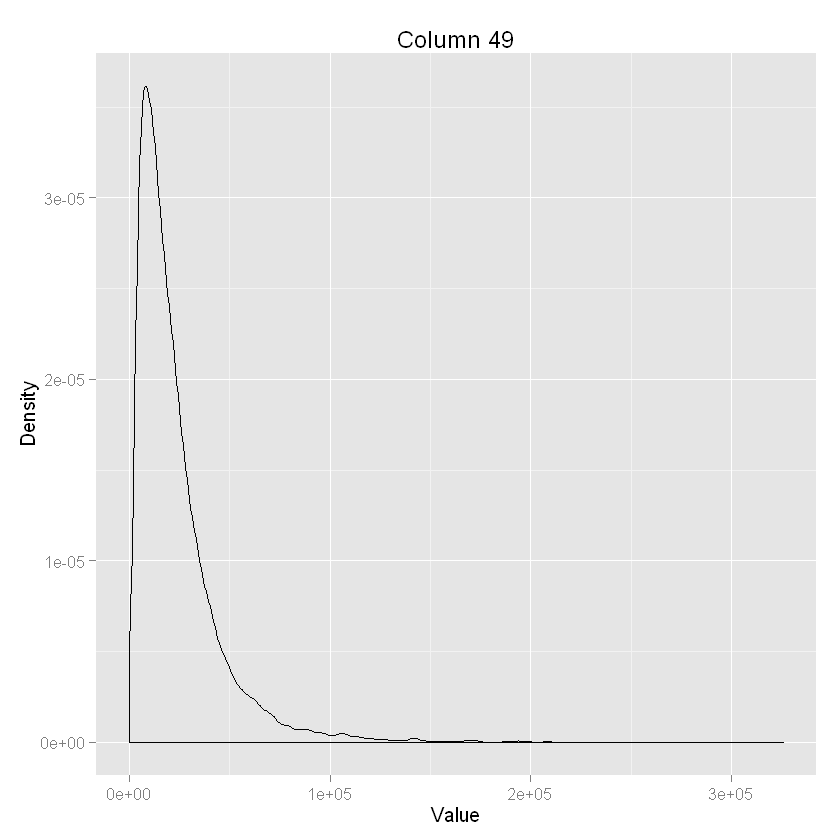

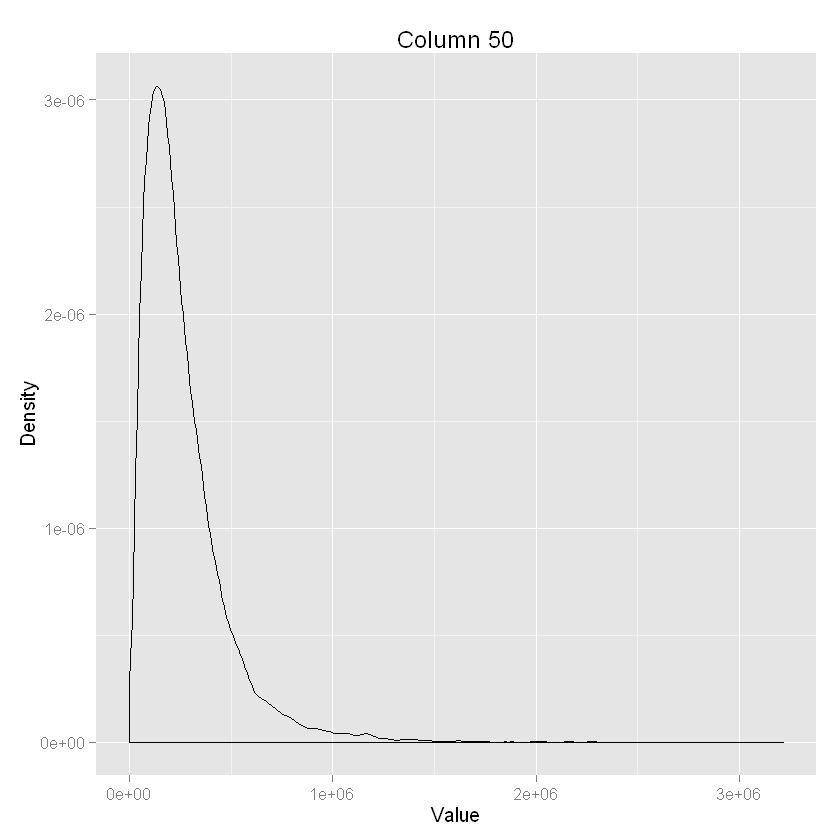

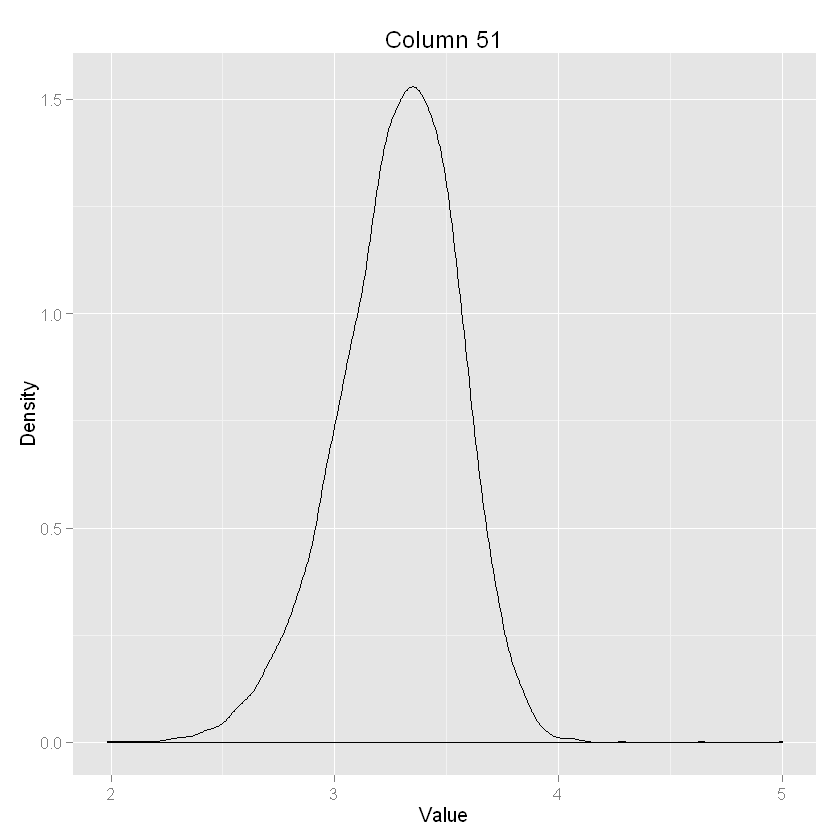

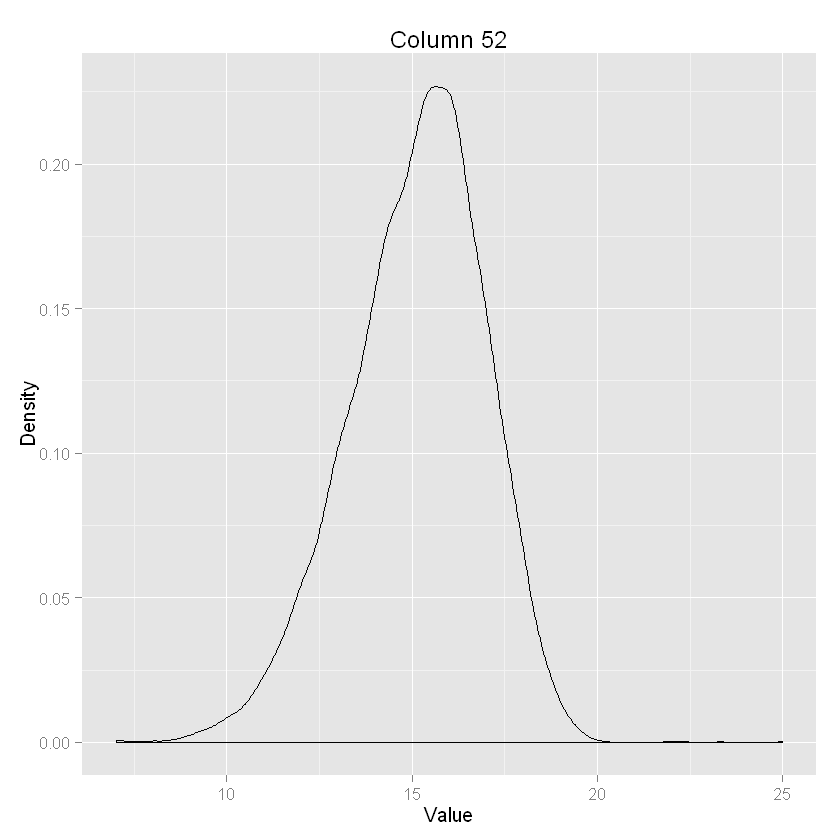

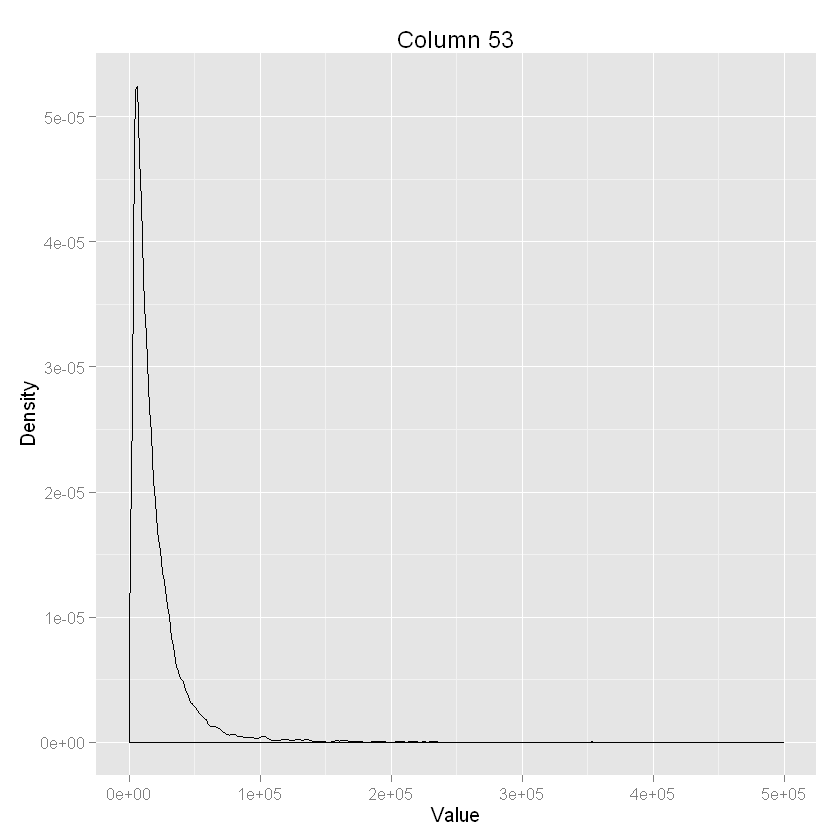

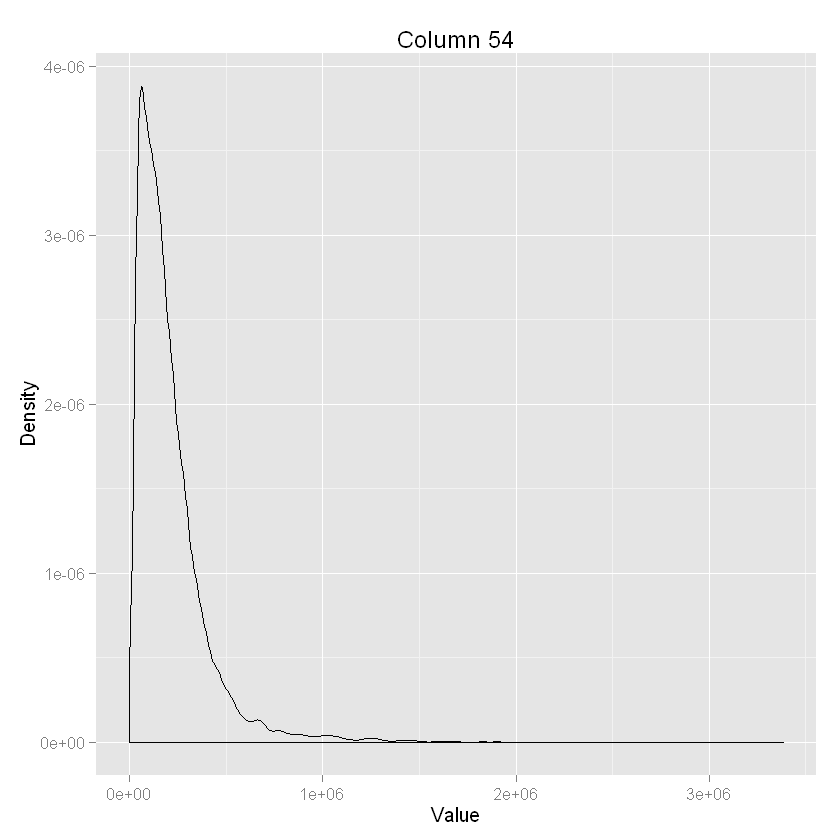

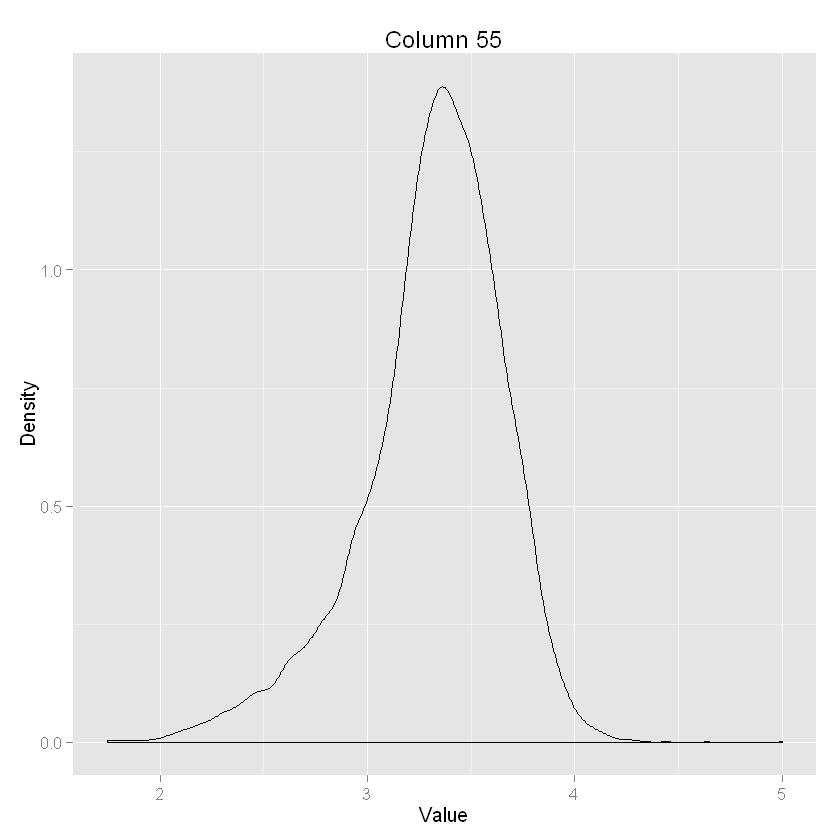

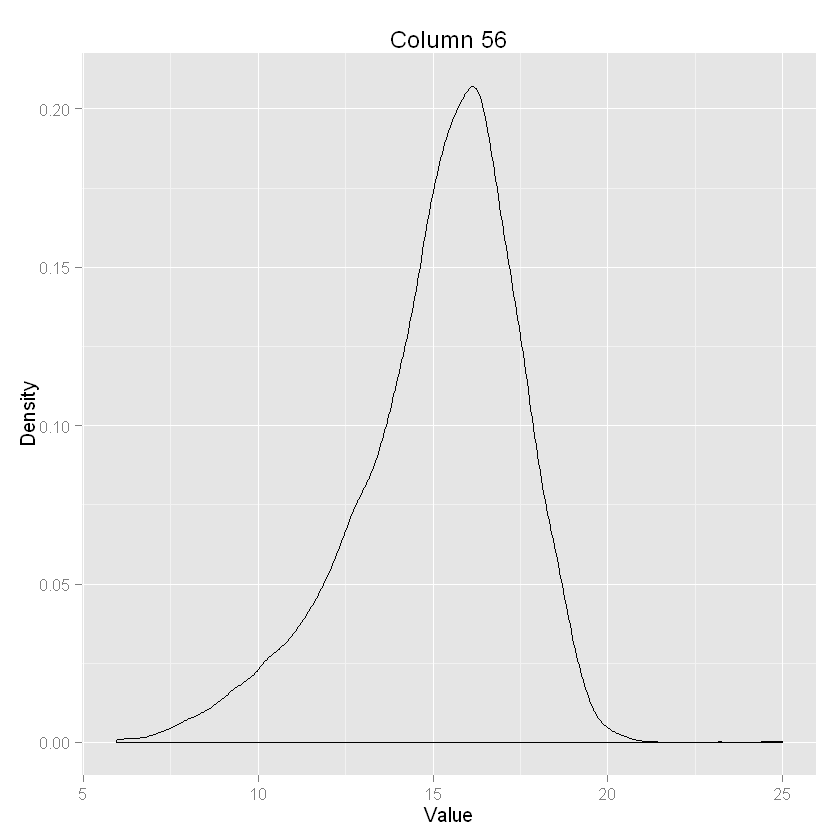

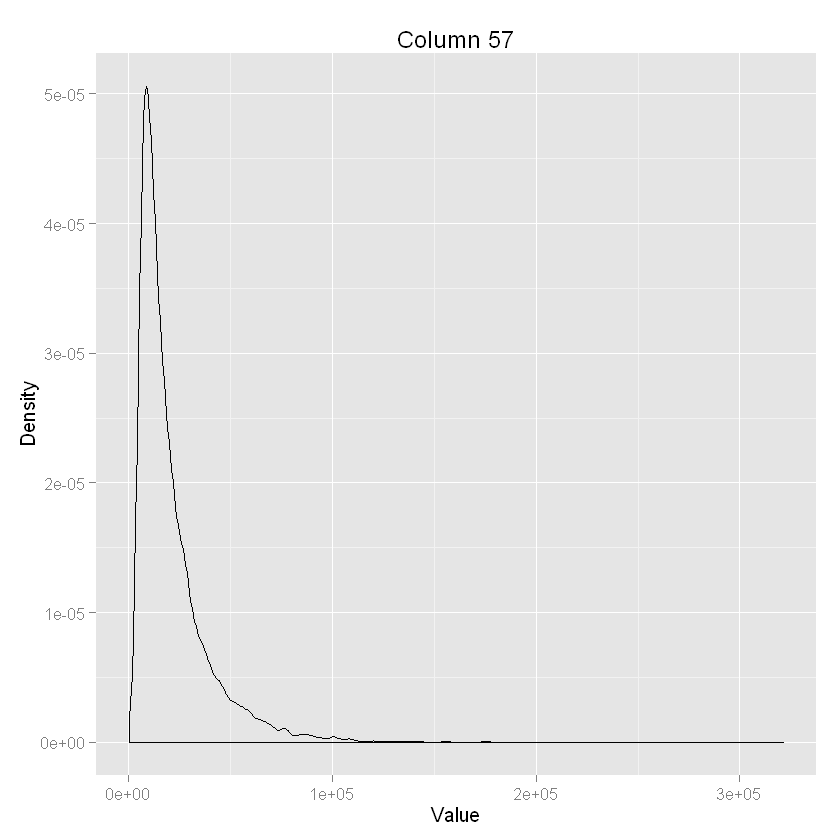

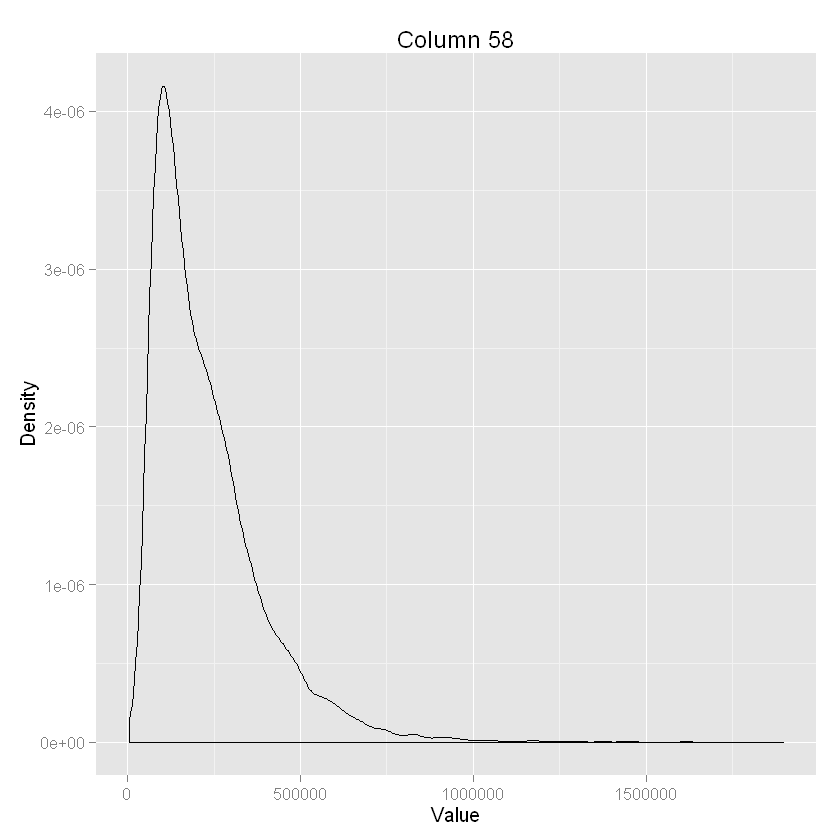

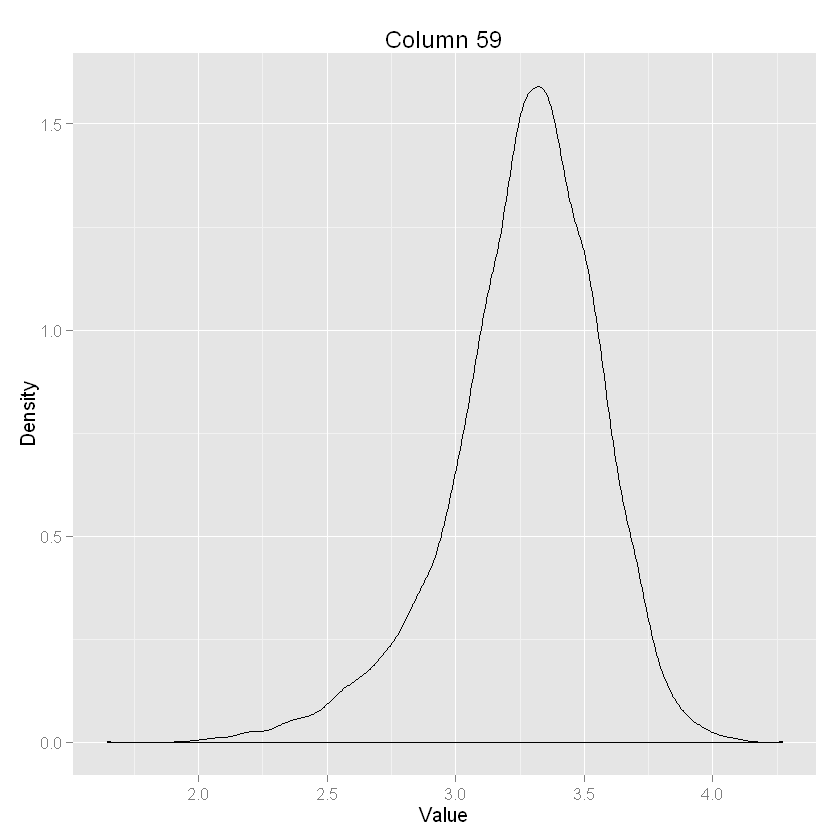

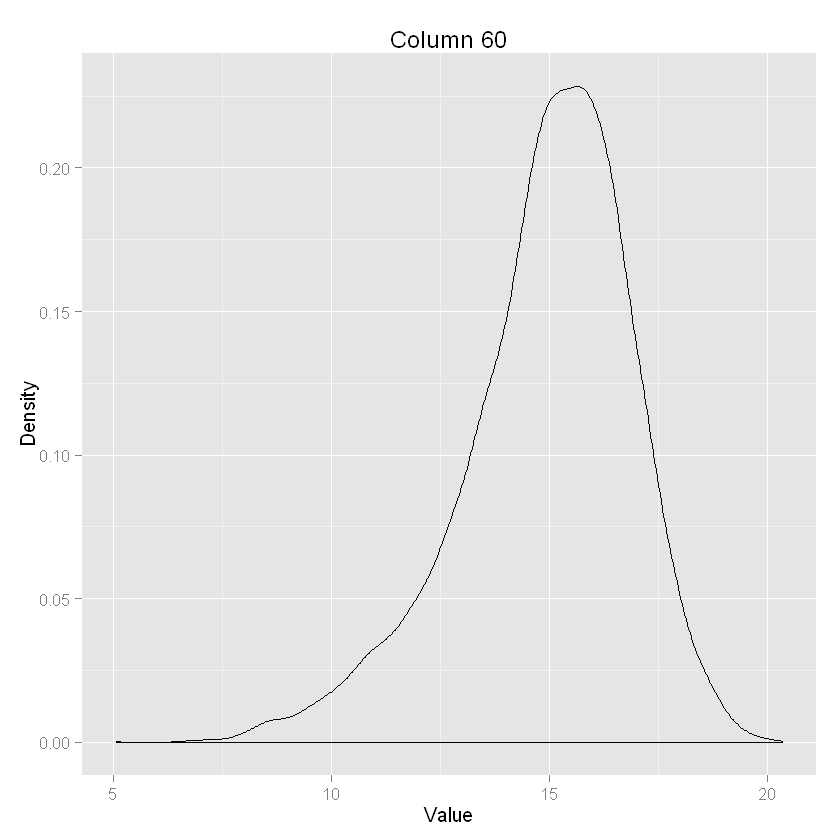

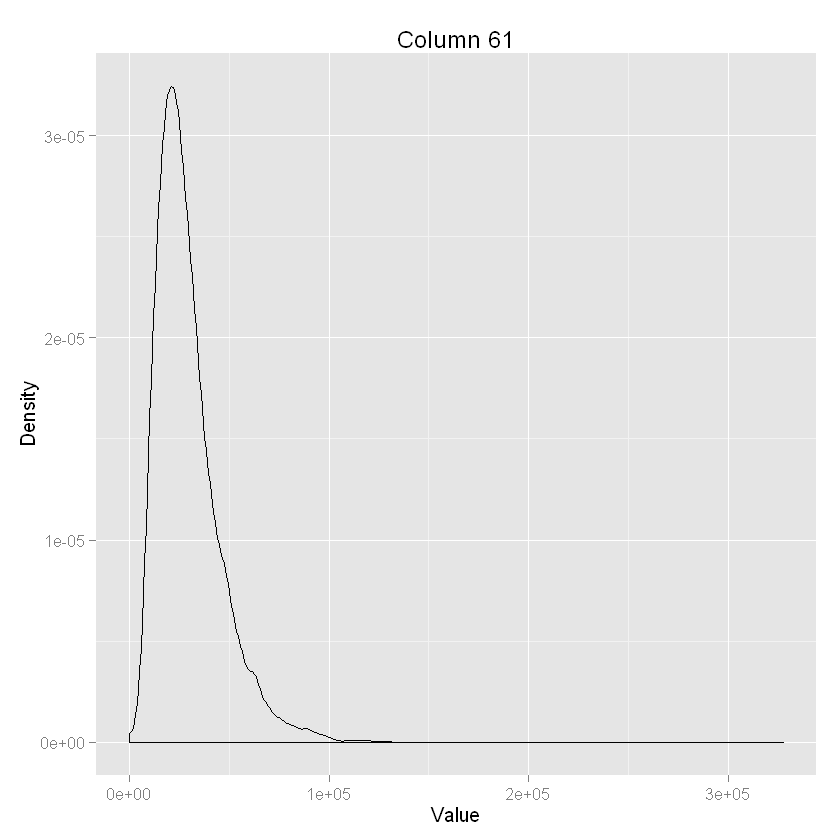

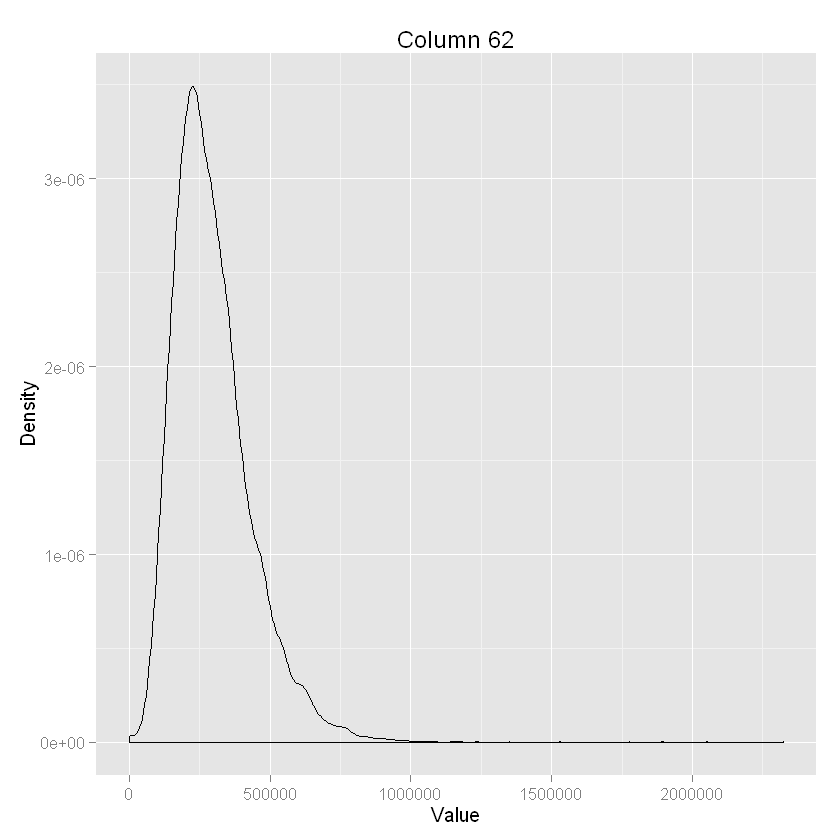

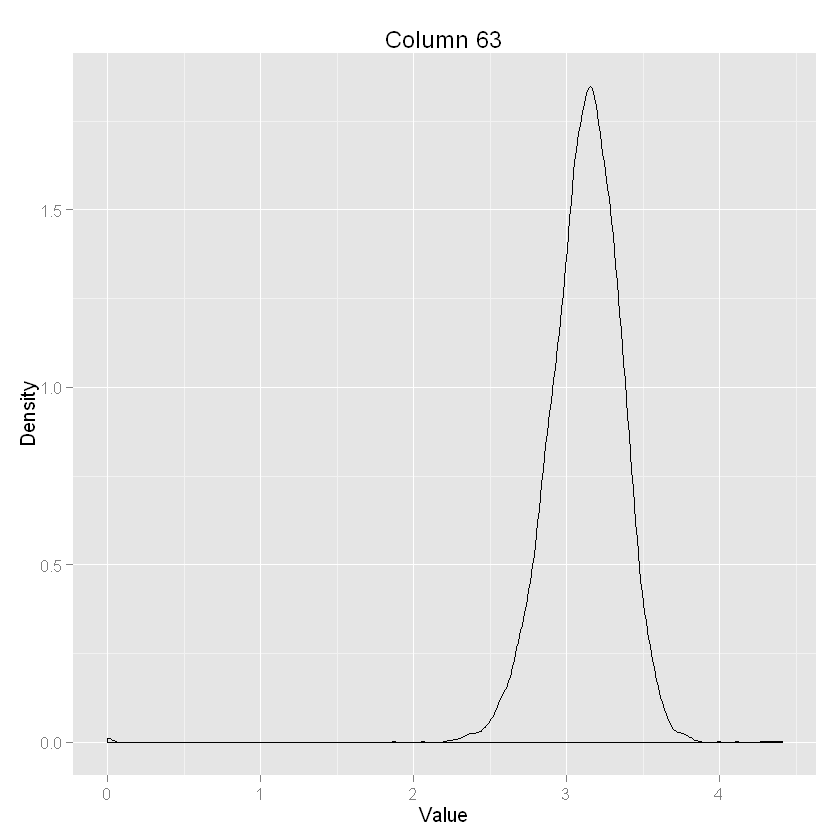

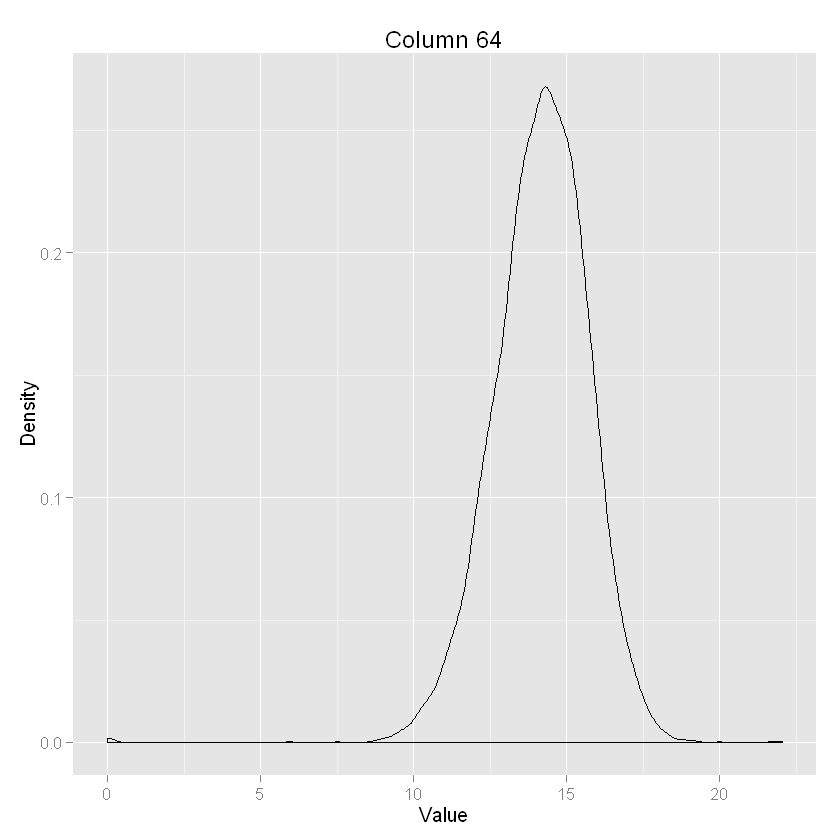

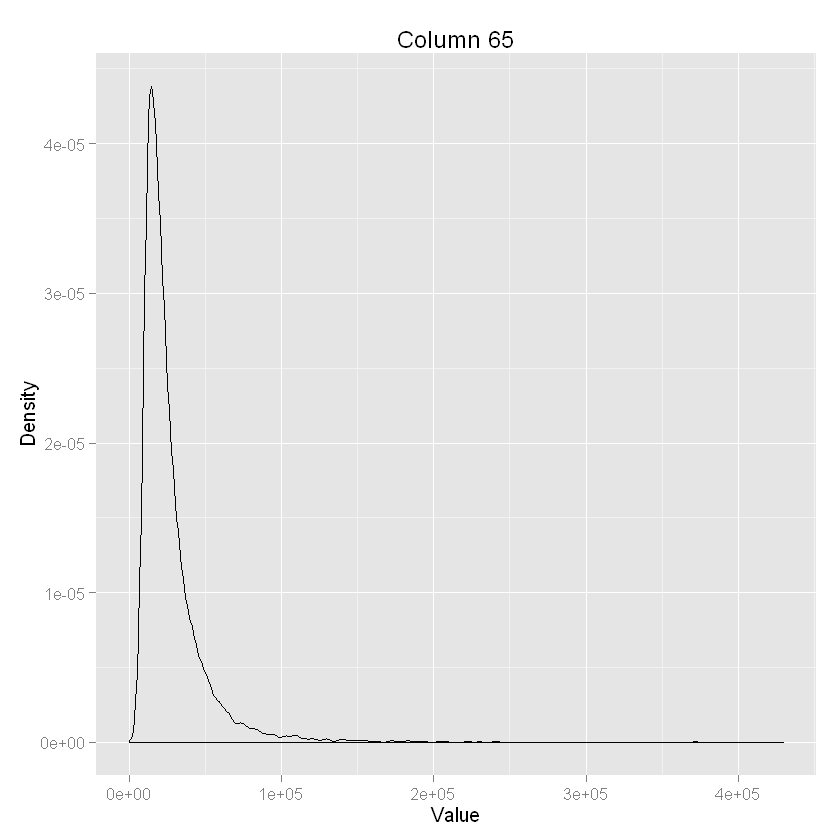

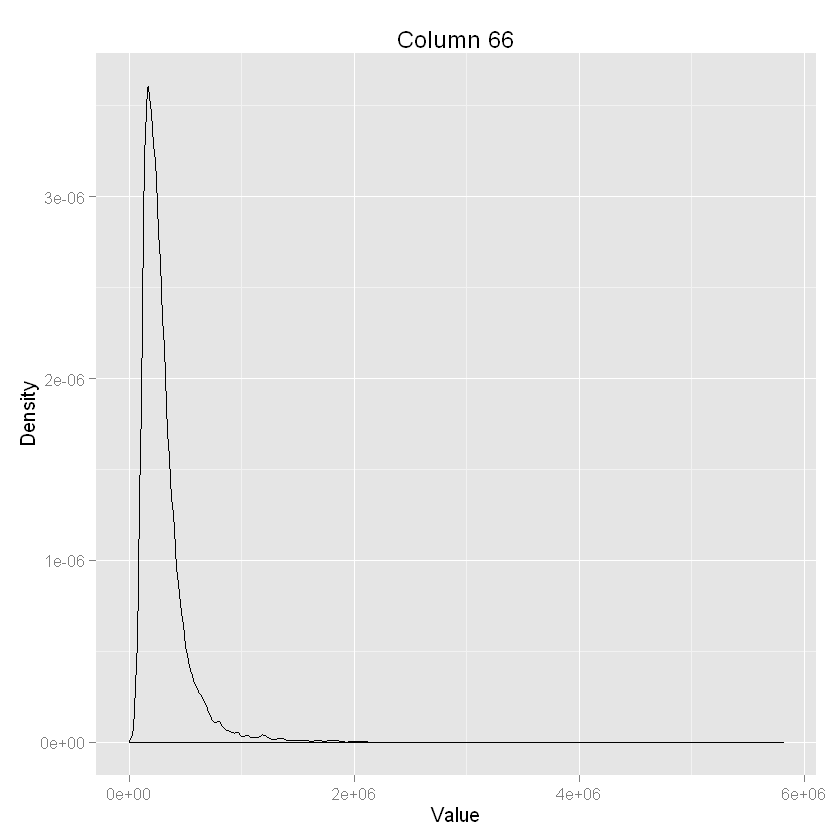

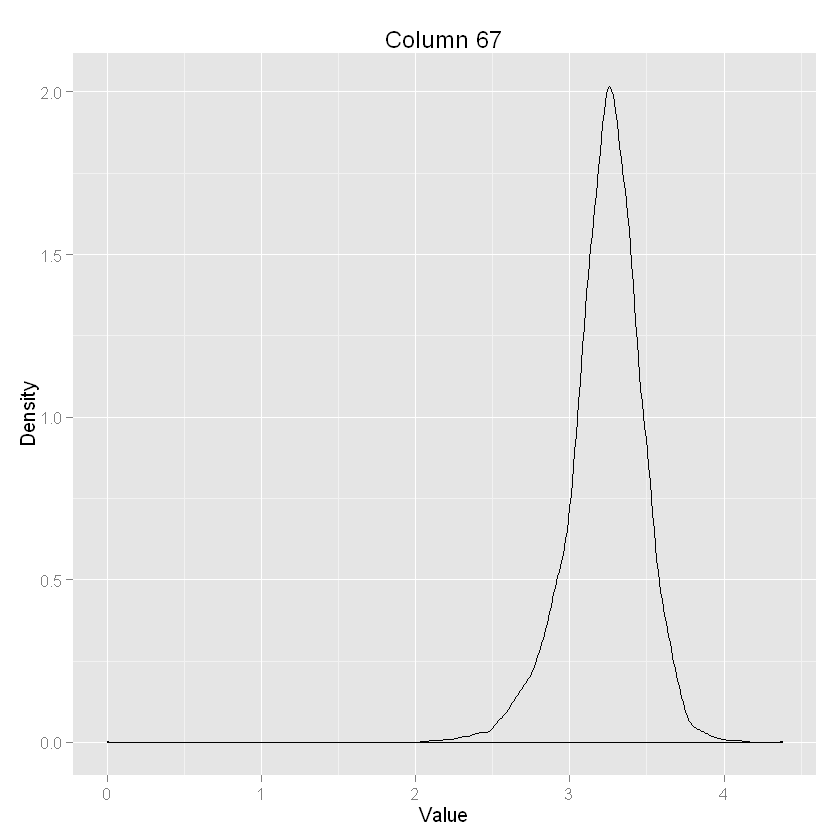

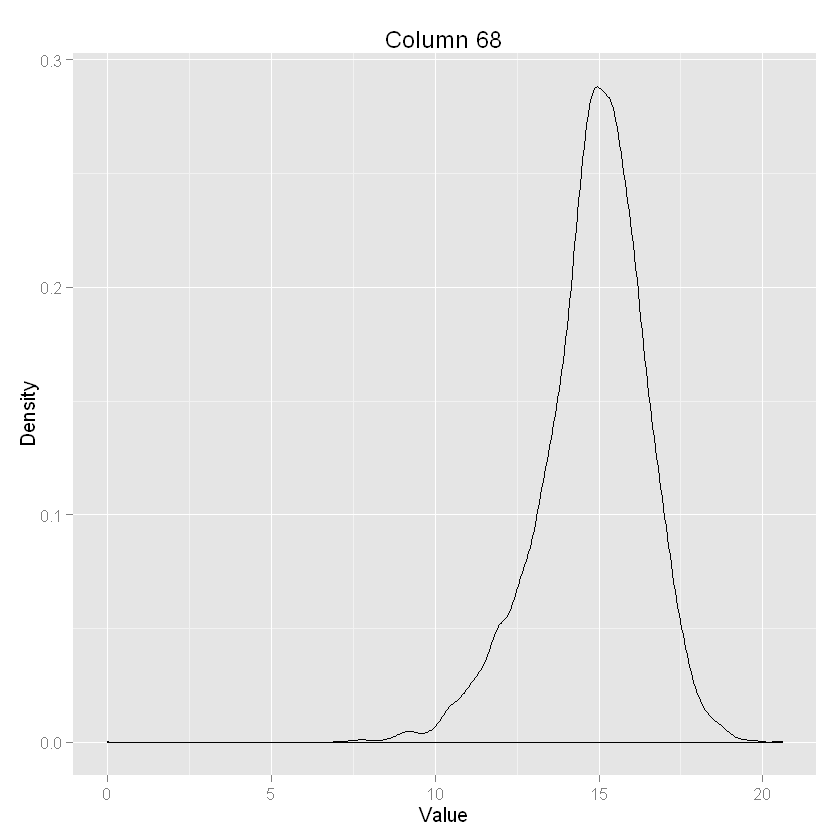

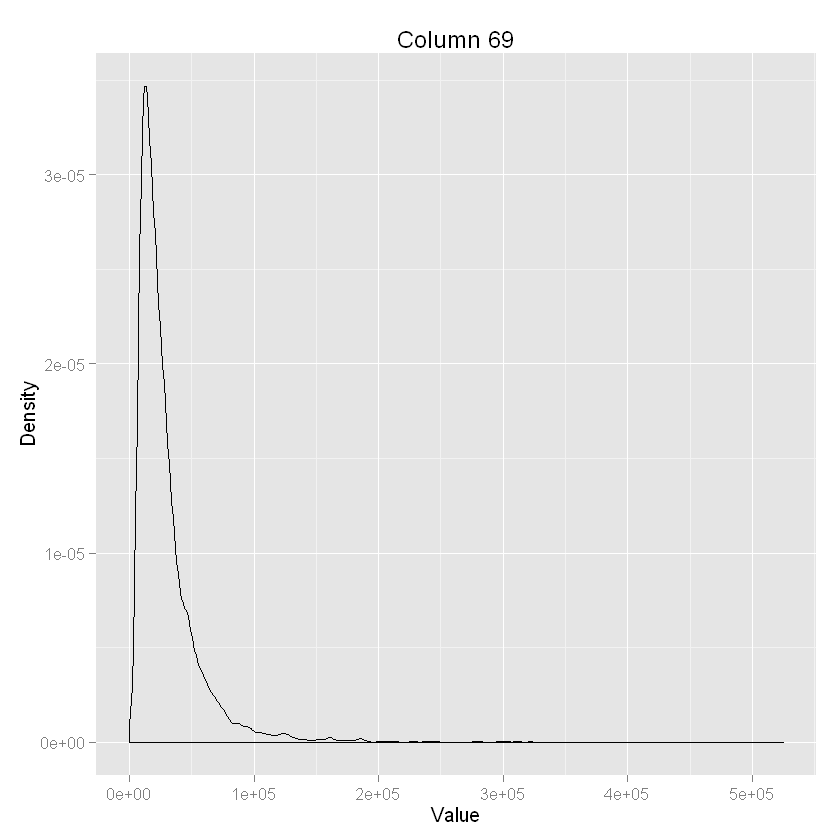

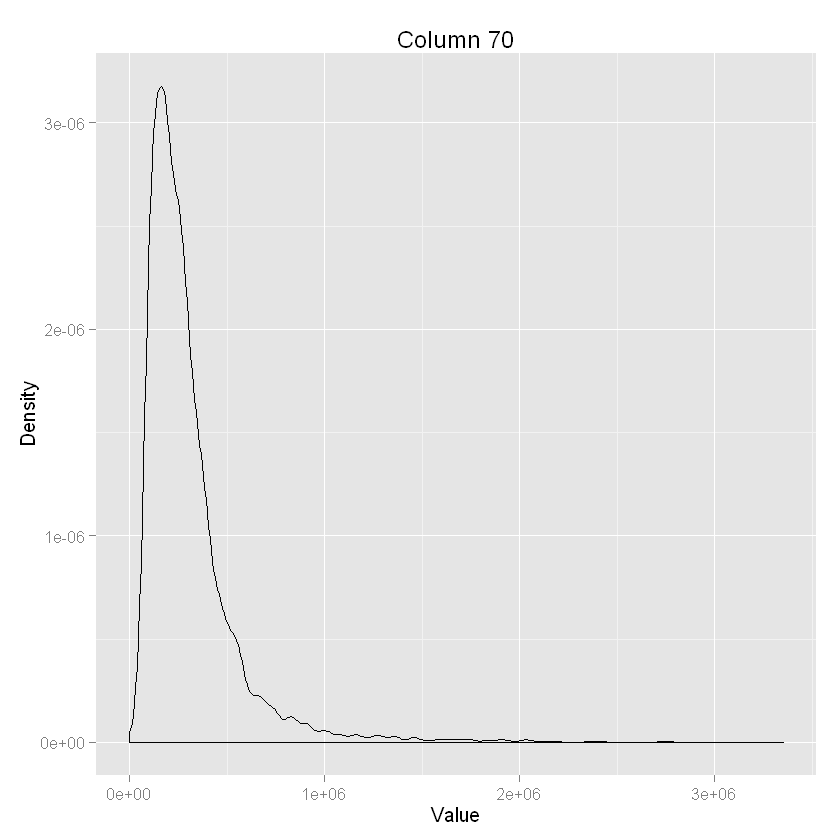

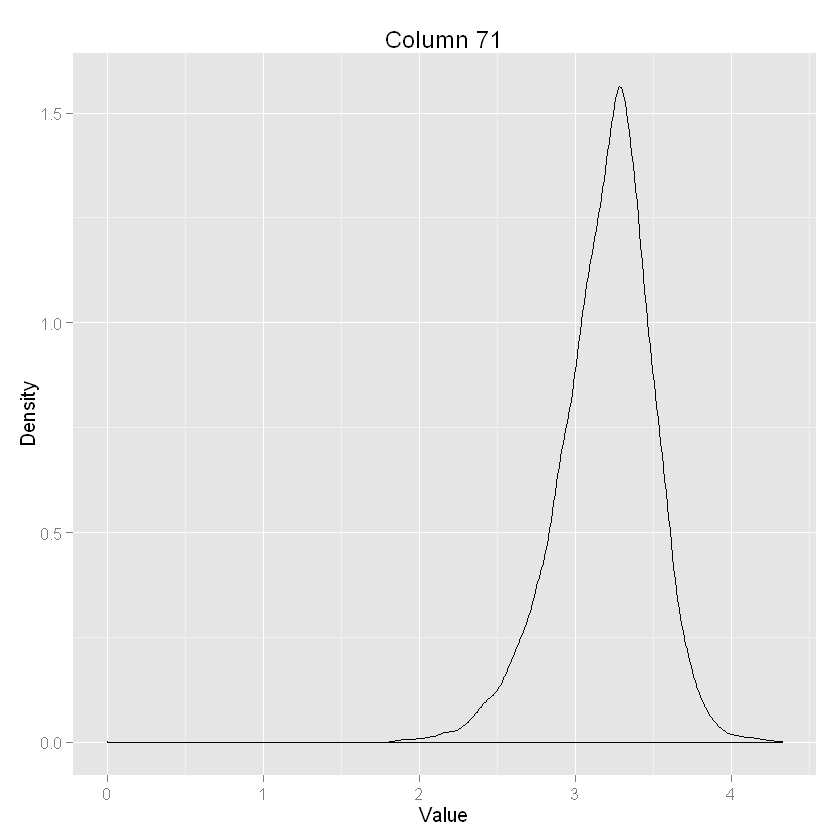

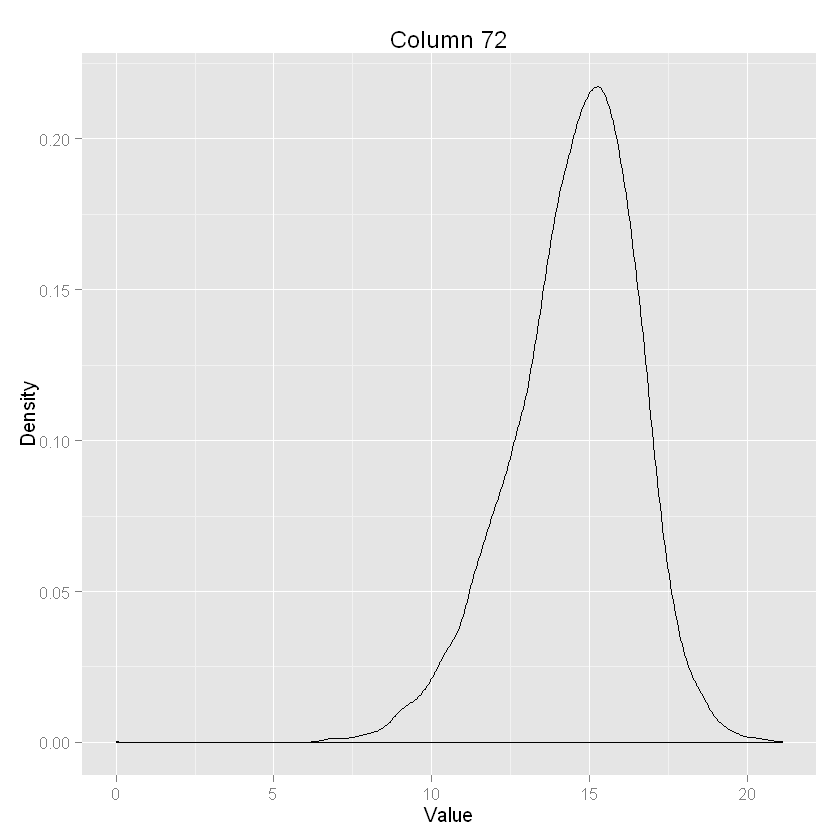

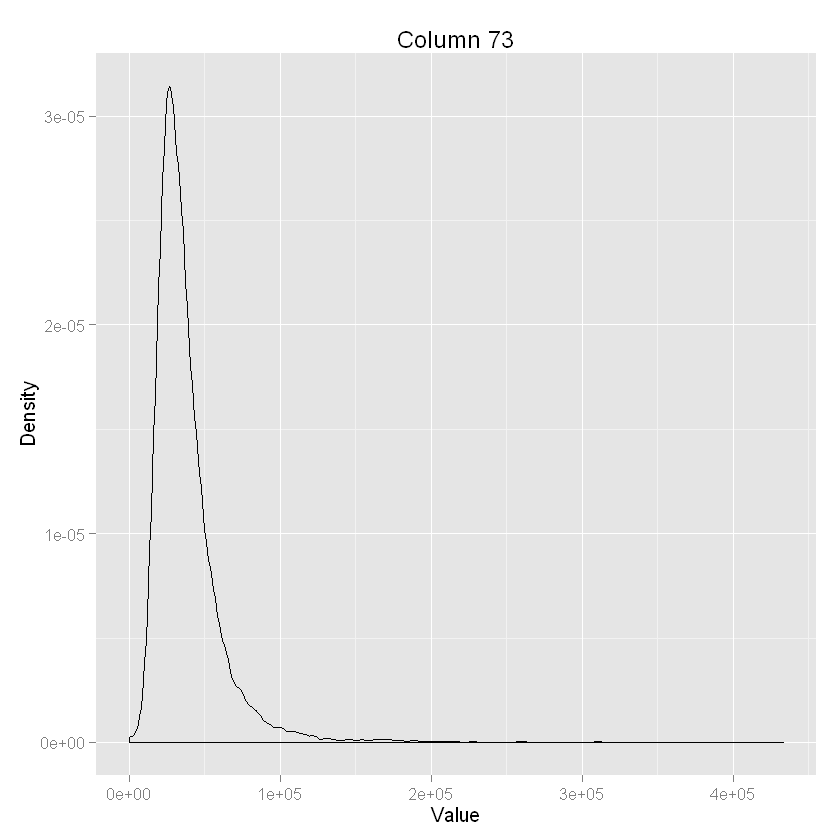

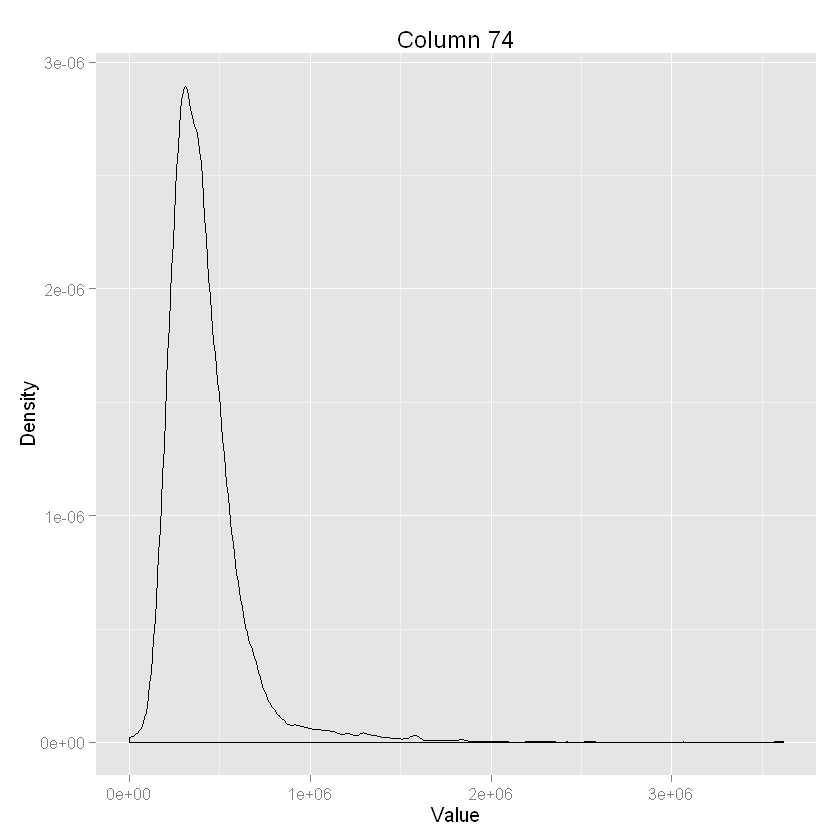

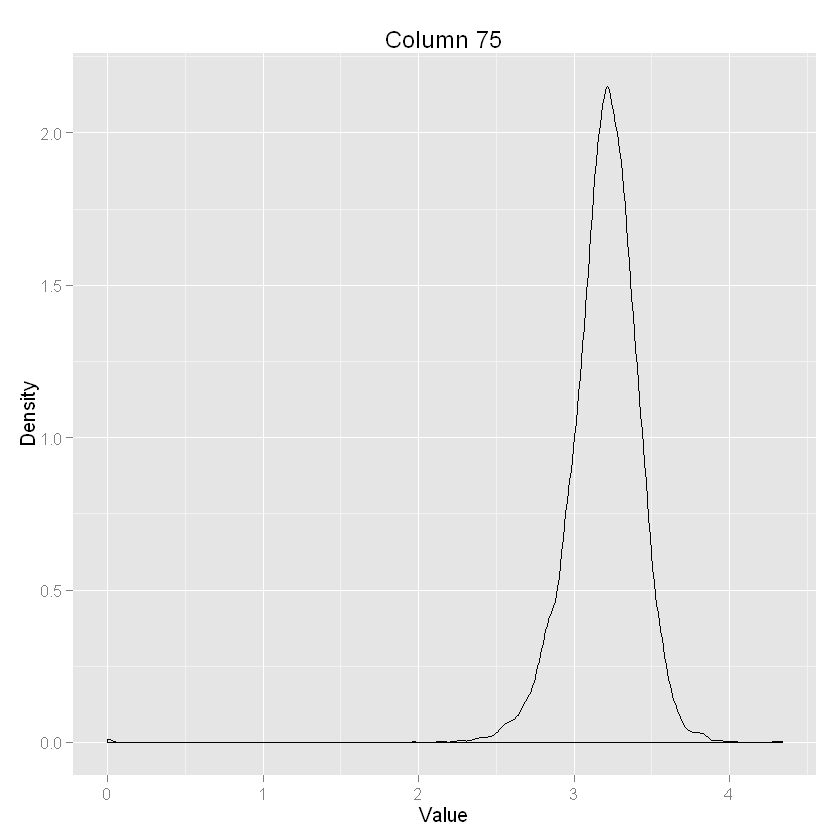

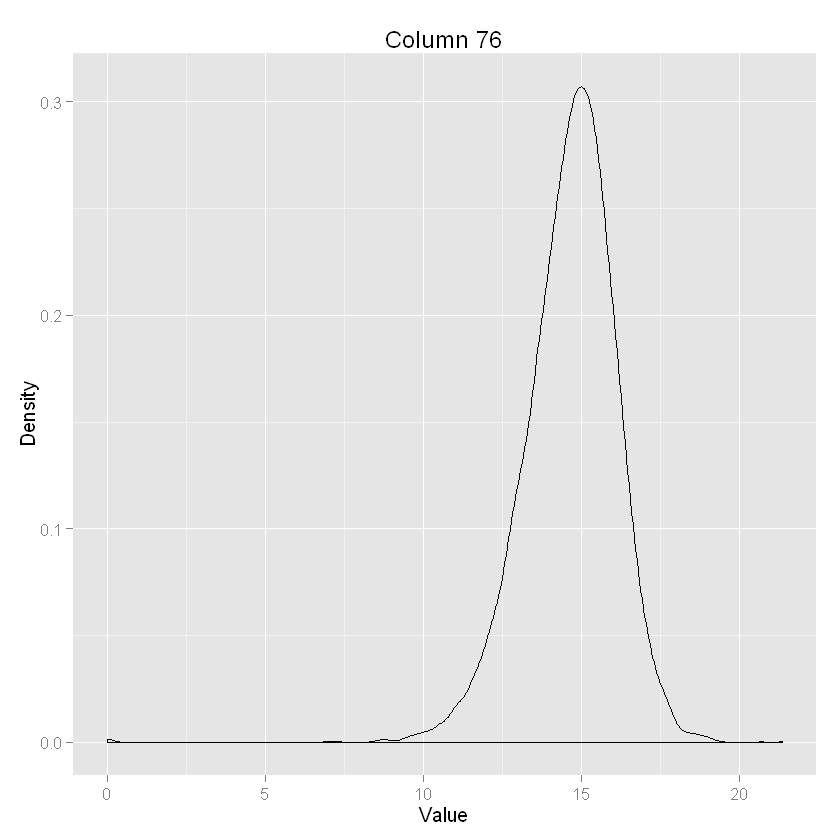

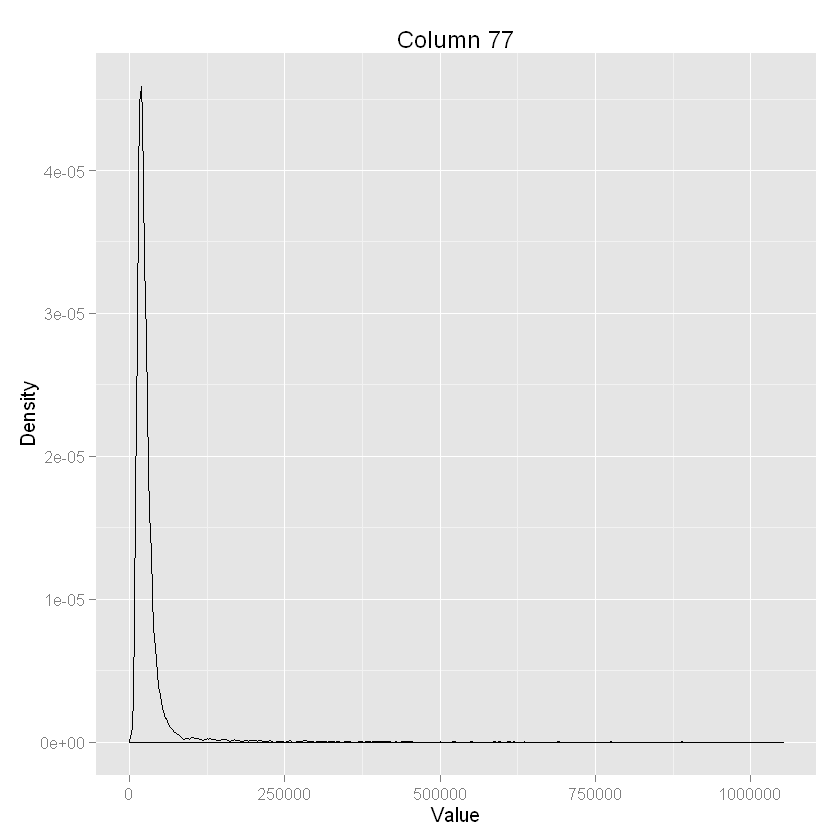

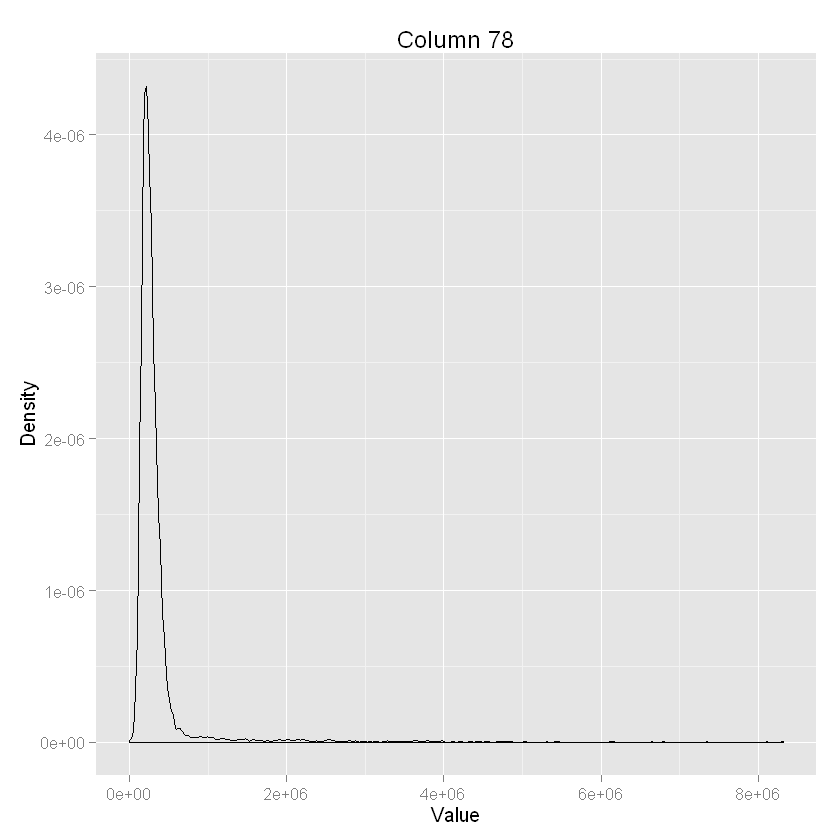

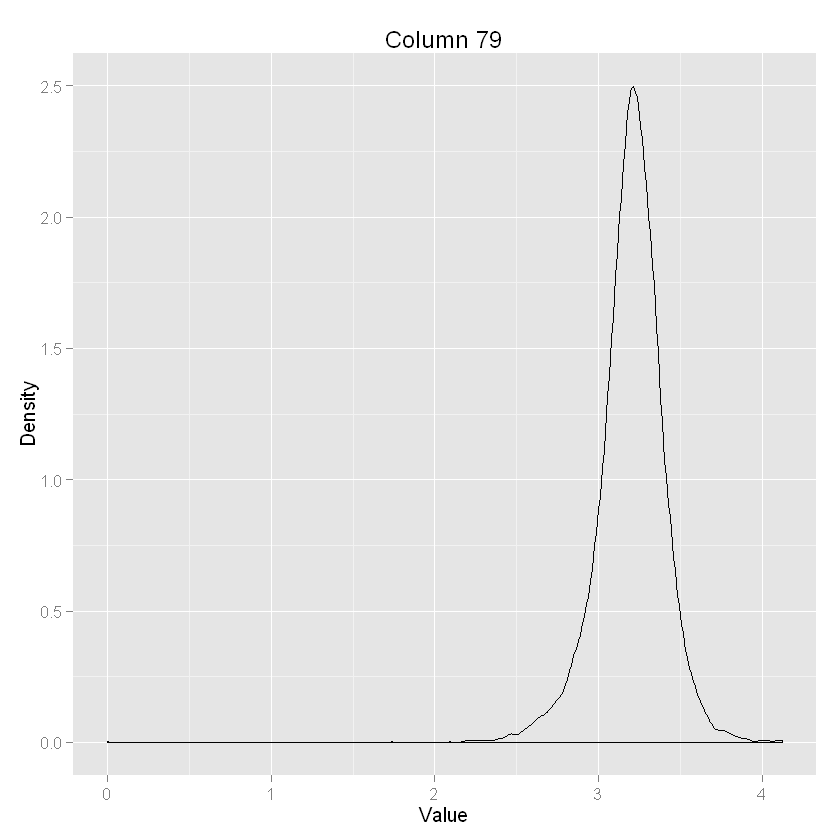

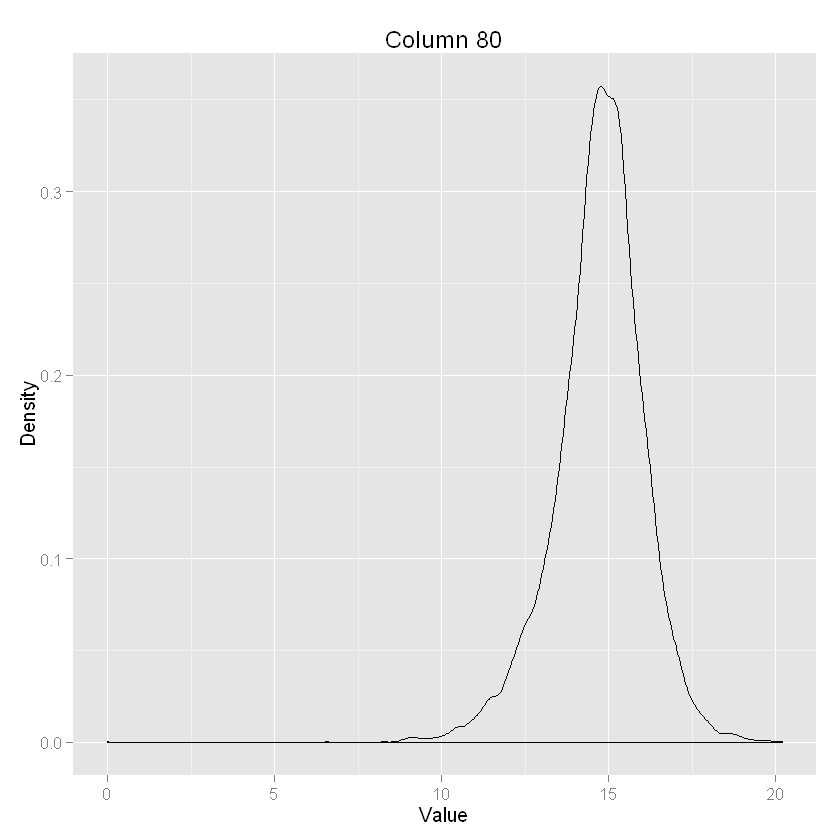

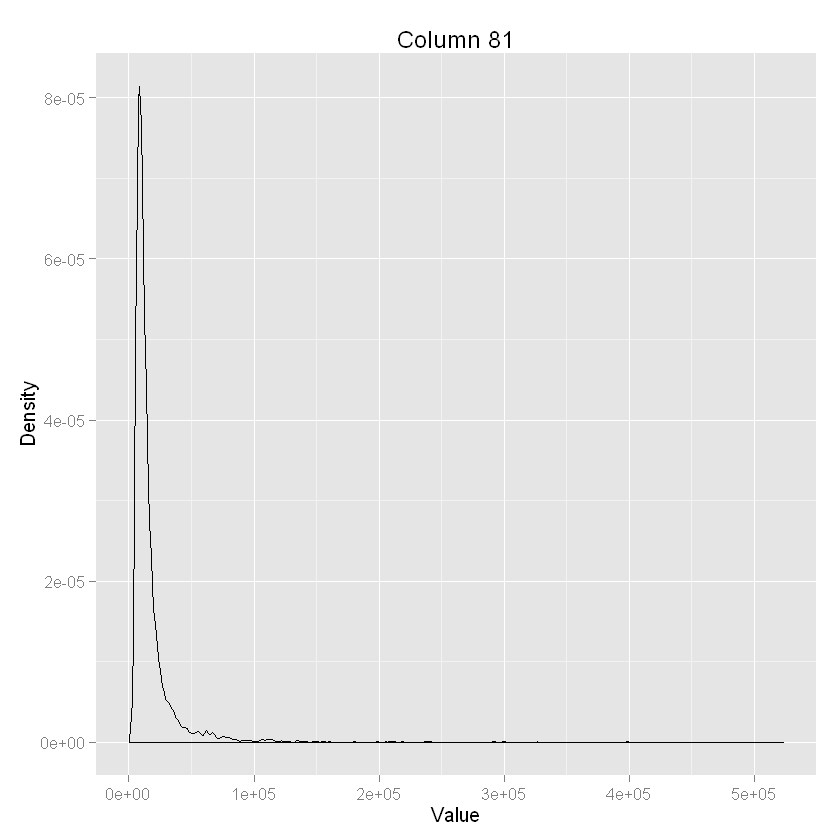

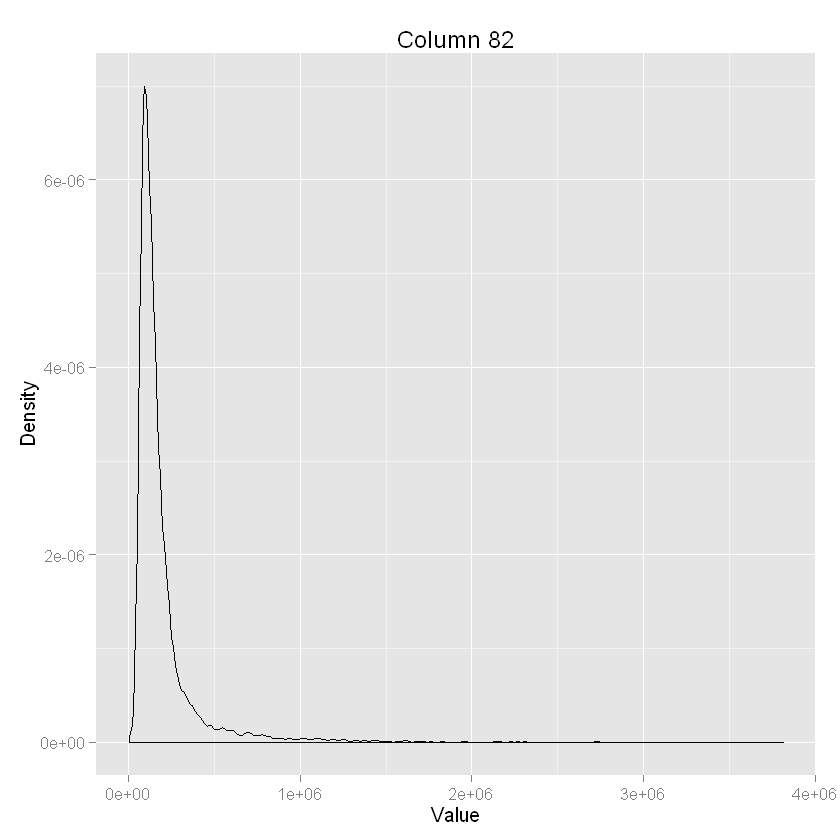

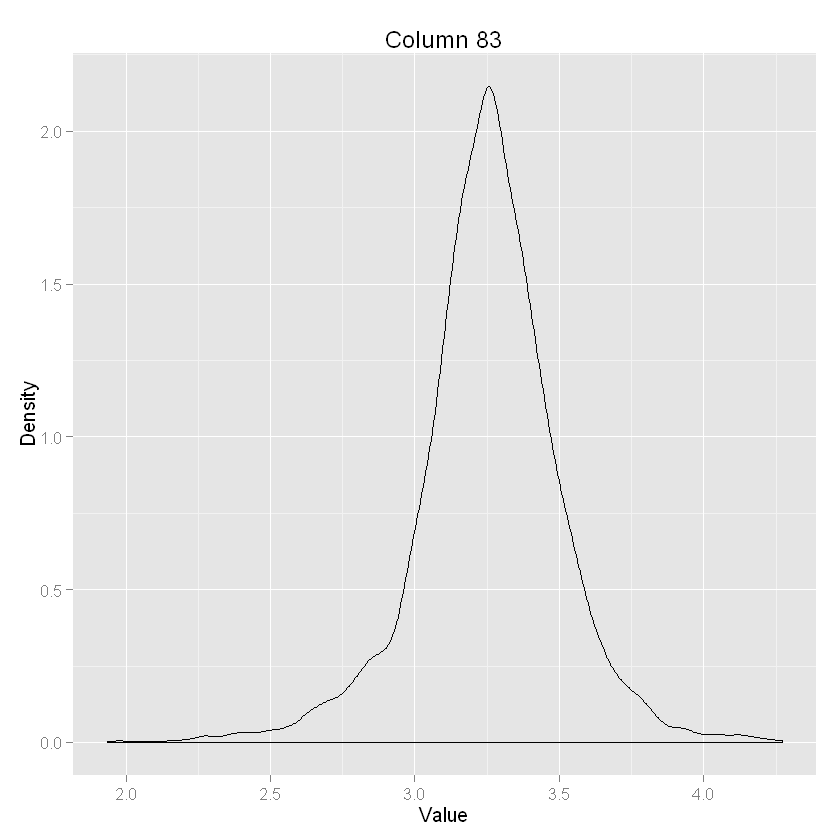

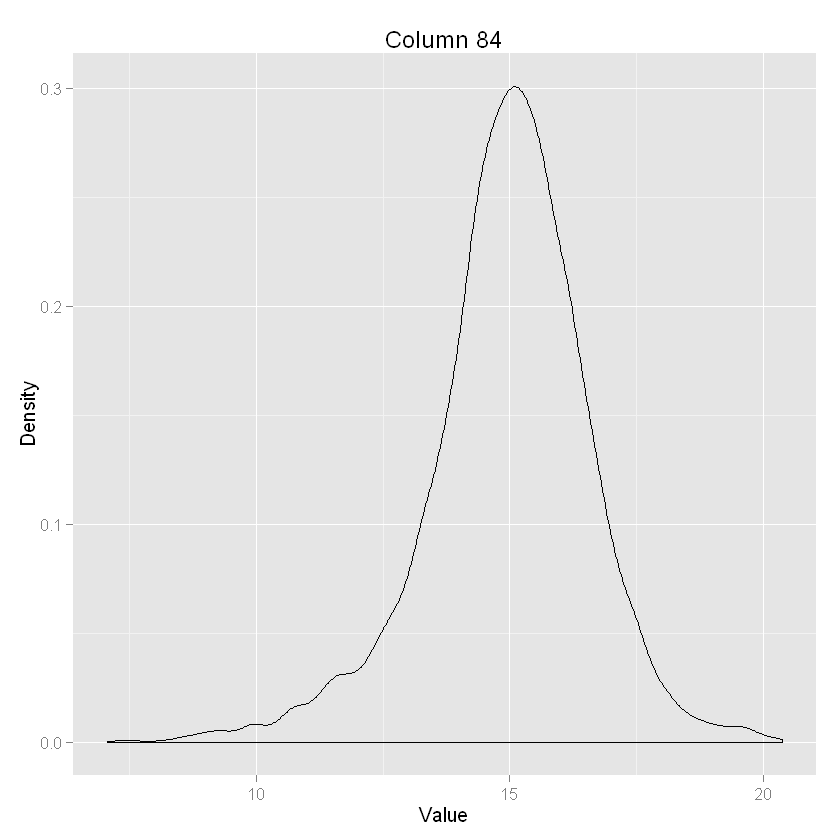

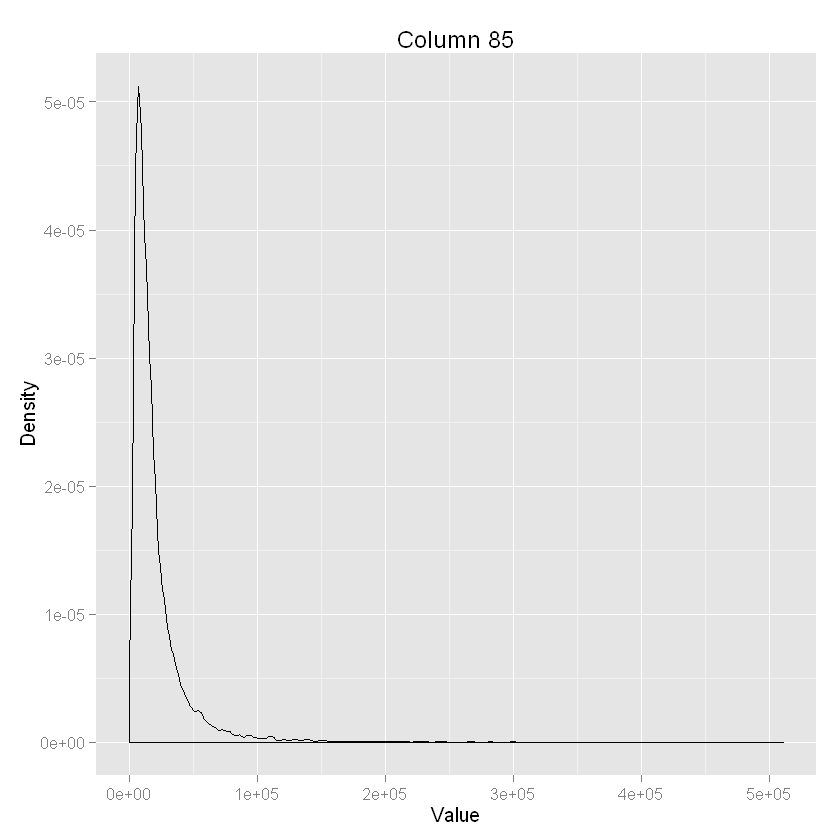

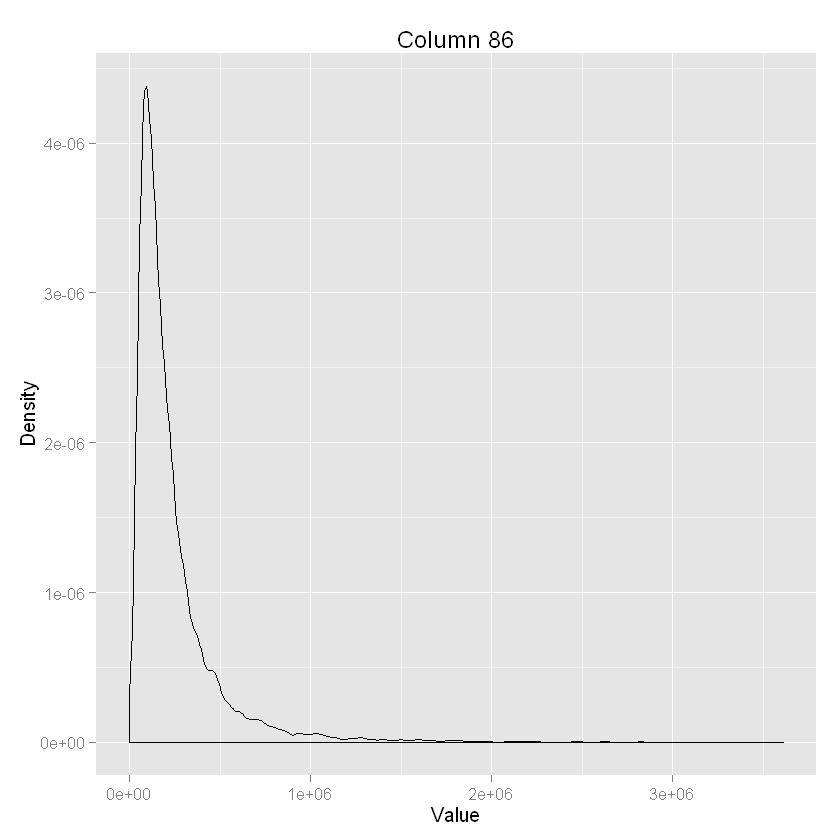

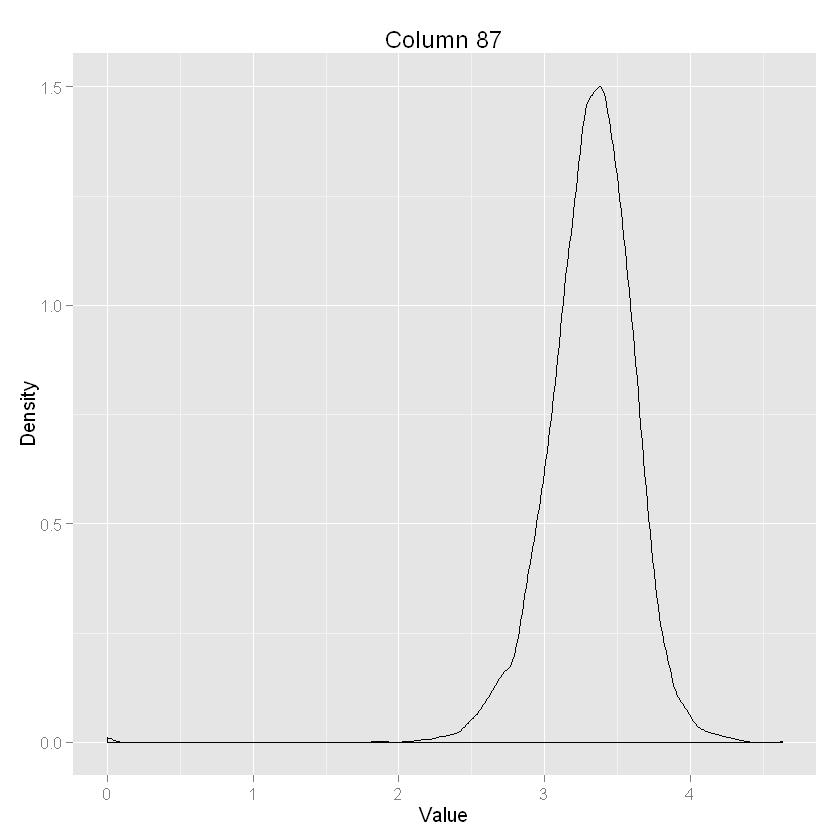

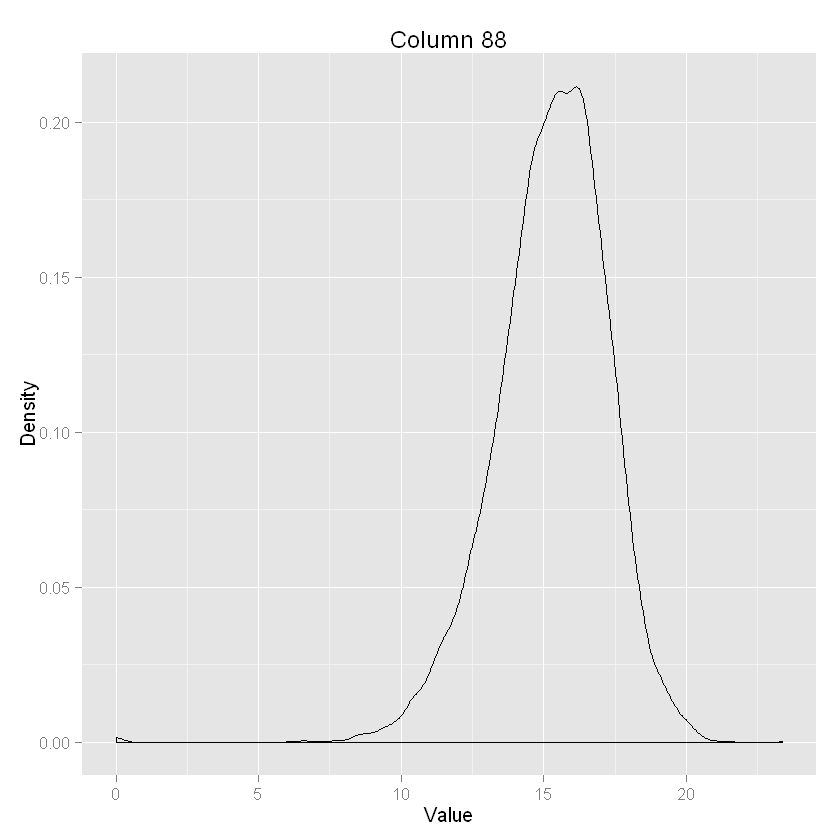

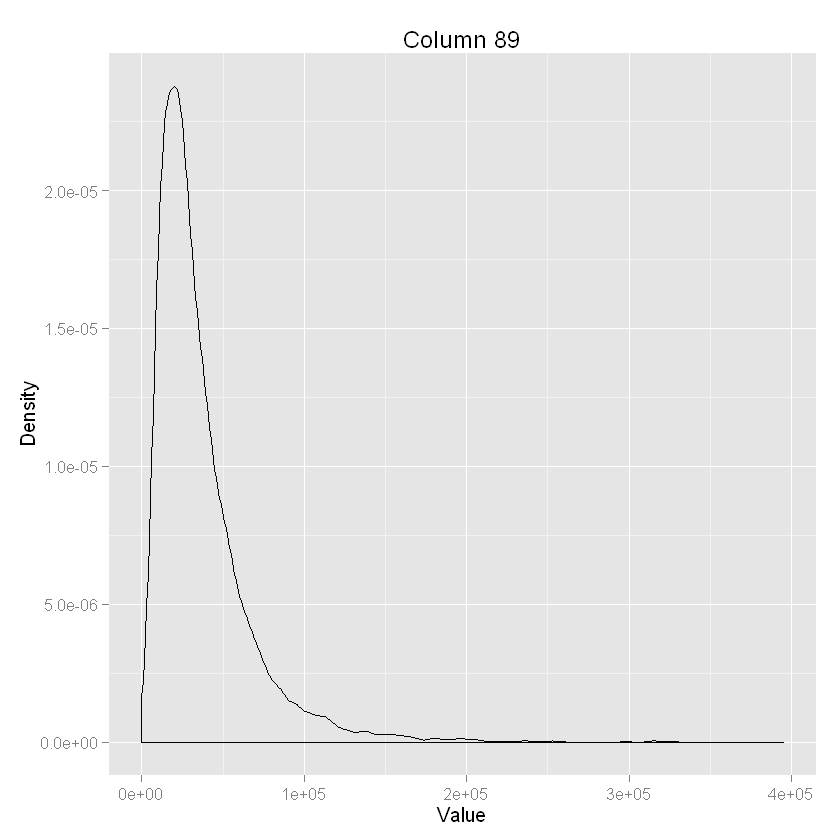

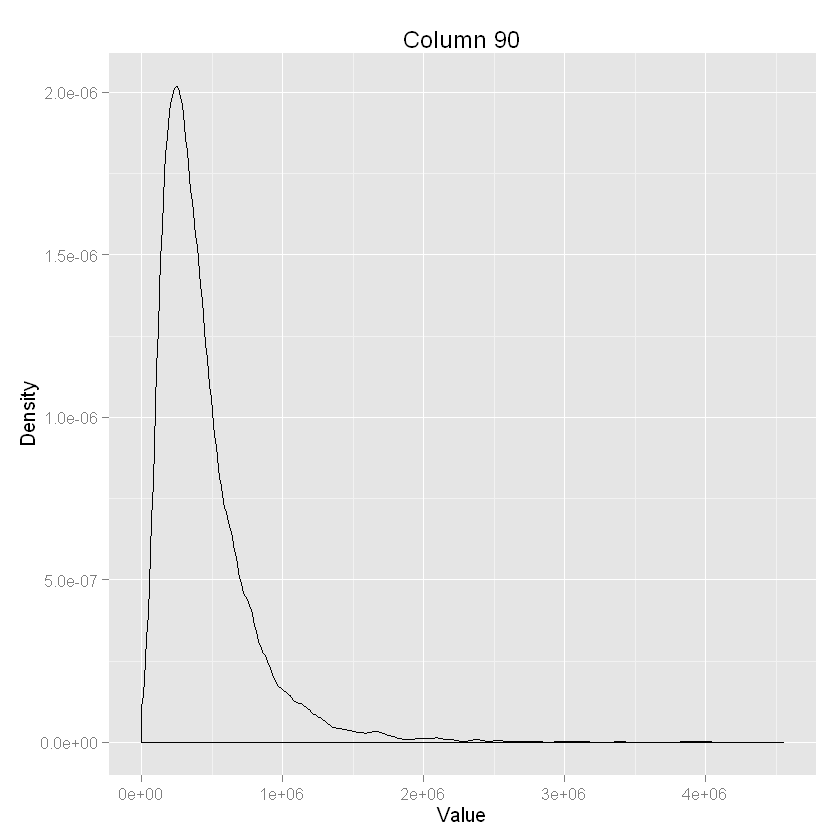

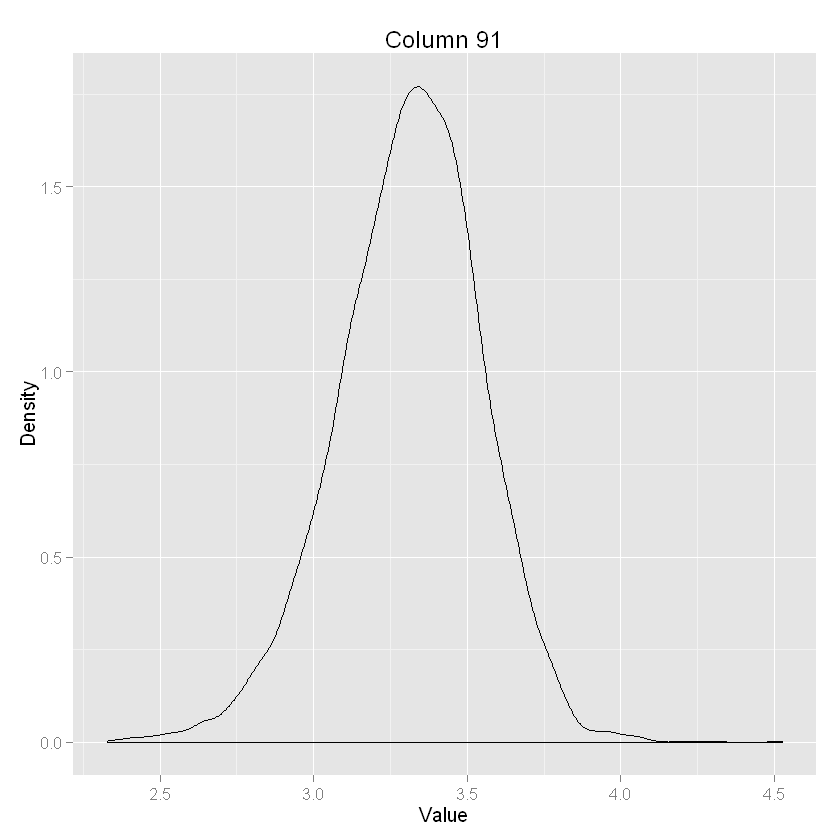

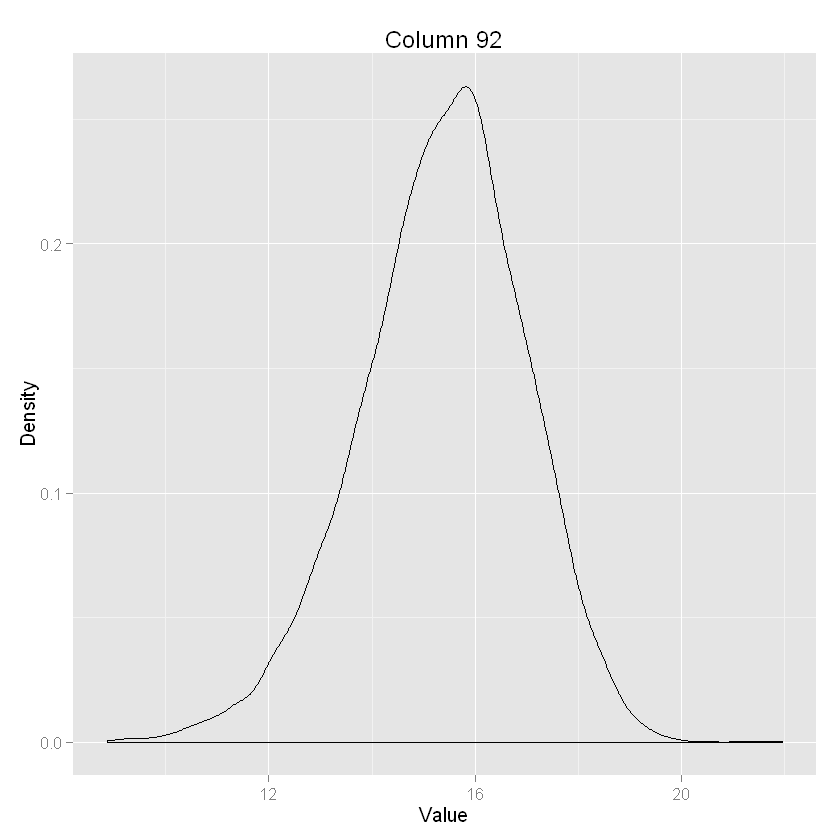

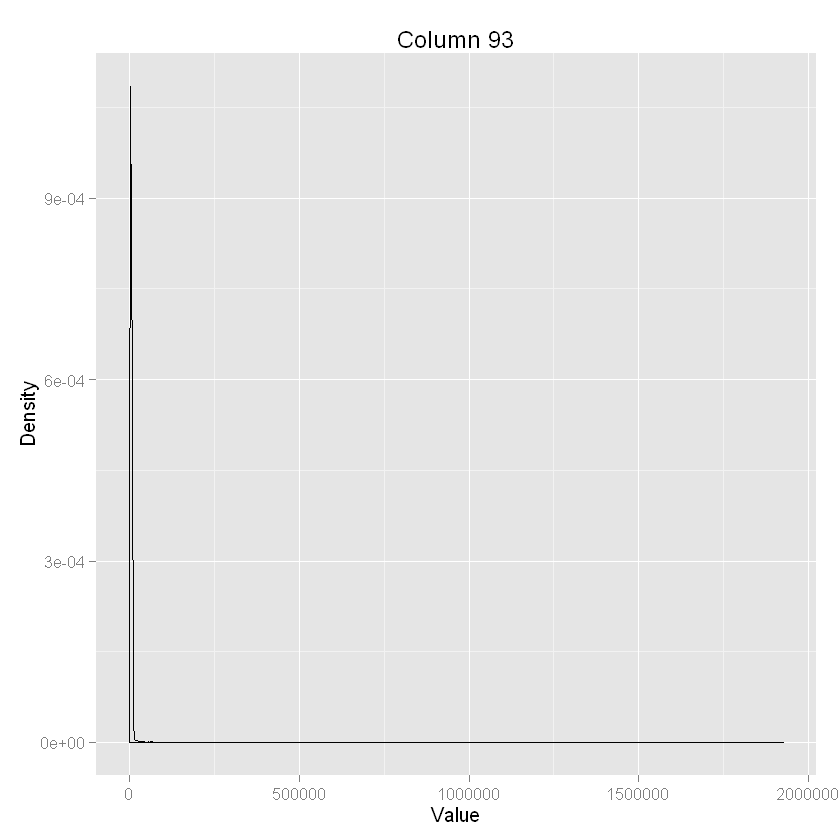

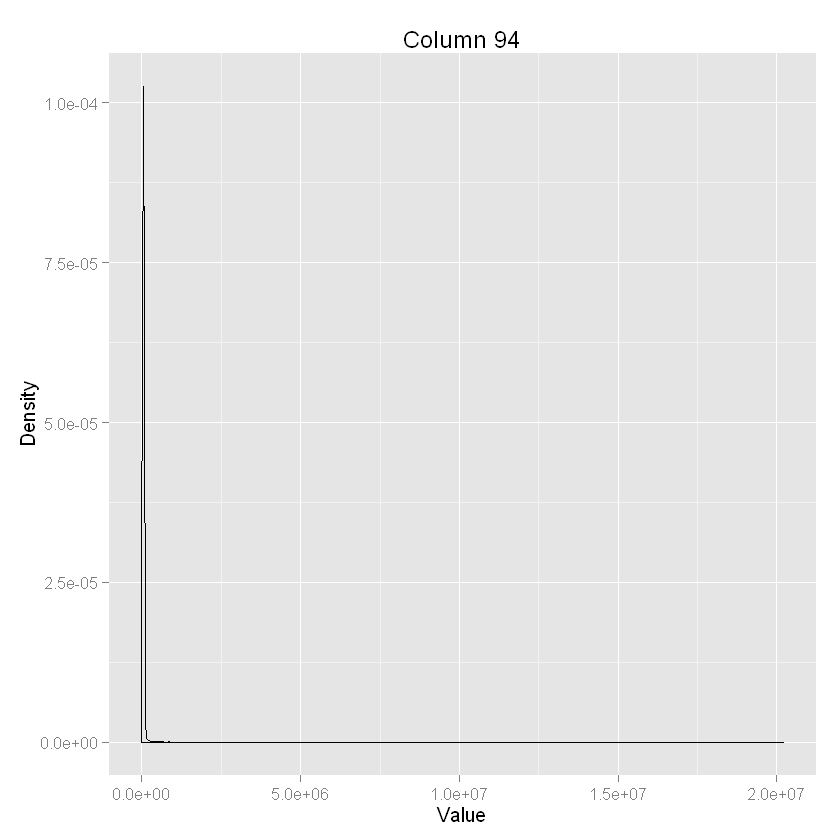

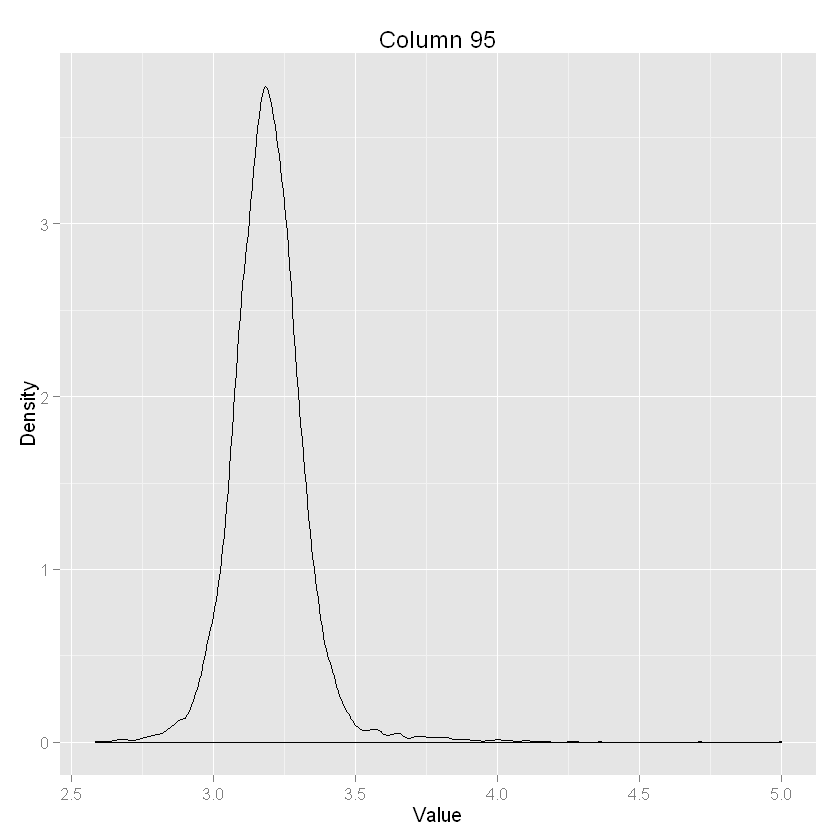

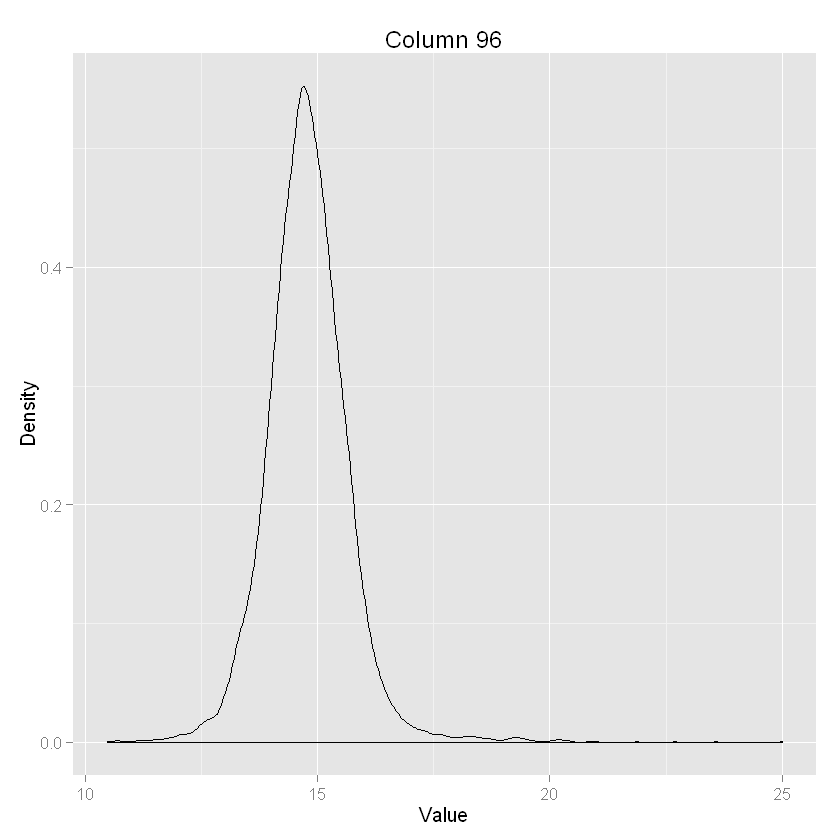

In [15]:
#This function plots the marginals of the input dataset, either as a histogram or as a density plot. 

plotMarginals <- function(data, save = FALSE, type = c("hist","density")){
	require(data.table)
	require(ggplot2)
	
	#Construct densities or histograms of marginals, depending on which one was requested
	if (type == "density") {
		for (i in c(1:dim(data)[2])) {
			df <- as.data.frame(cbind(c(1:dim(data)[1]), data[,i]))
			p <- ggplot(df,aes(V2)) + geom_density() + ylab('Density') + xlab('Value') + ggtitle(paste('Column',i))
			if (save == TRUE){
				ggsave(paste('Density_Marginal_Column_',i,'.png'),p)
			} else{
				print(p)
			}
		}
	} else if (type == "hist"){
		for (i in c(1:dim(data)[2])) {
			df <- as.data.frame(cbind(c(1:dim(data)[1]), data[,i]))
			p <- ggplot(df,aes(V2)) + geom_histogram() + ylab('Density') + xlab('Value') + ggtitle(paste('Column',i))
			if (save == TRUE){
				ggsave(ggsave(paste('Hist_Marginal_Column_',i,'.png'),p))
			} else{
				print(p)
			}
		}
	}
}

plotMarginals(subsample, type = "density")

The distributions of all of the features look unimodal. This is unexpected, as we would expect the markers cooresponding to inhbitory and excitatory synapses ot have a bimodal distribution.

<i> Which features have the greatest variability among the subjects? Which have the least? </i>

We can take a look at the computed variance for this. Column 42 has to most variance. Column 95 has the least variance.

<i>How many principal components are needed to describe the data well?</i>

We take a look at the scree plot:

Loading required package: gtable
Warning message:
: package 'gtable' was built under R version 3.1.3Loading required package: grid
Loading required package: LICORS
Warning message:
: package 'LICORS' was built under R version 3.1.3

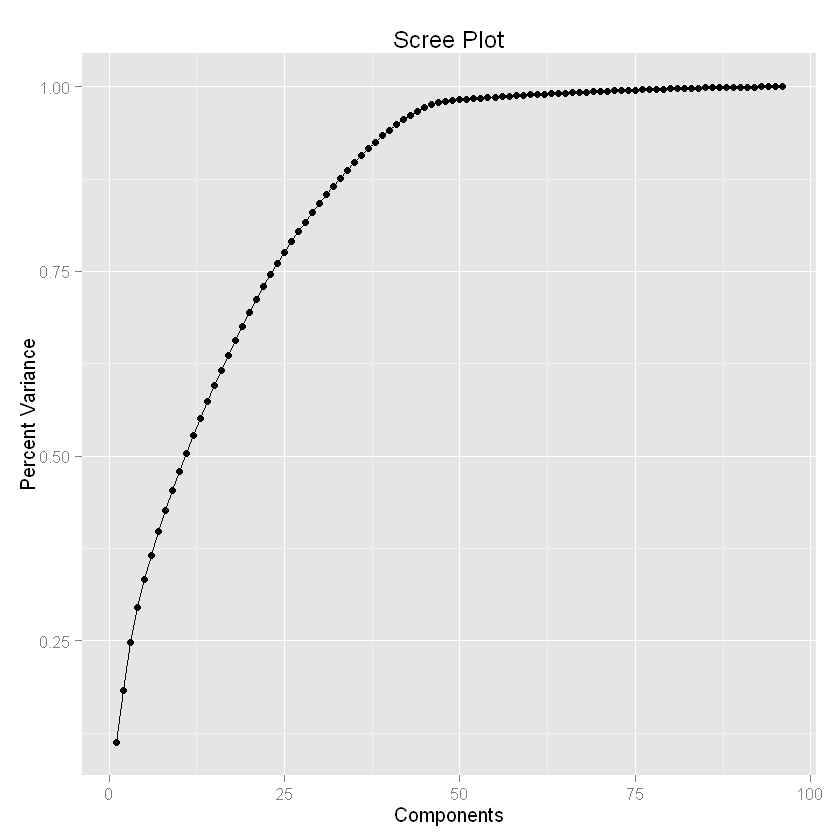

In [16]:
#Constructs a scree plot of the input data

screePlot <- function(data){
	require(ggplot2)
	require(gtable)
	require(LICORS)

	#PCA down to 2 dimensions
	fit <- prcomp(x = data,center = TRUE,scale = TRUE)

	#Construct scree plot
	results <- data.frame(x = c(1:length(unlist(fit[1]))), y = cumsum(unlist(fit[1])^2) /  max(cumsum(unlist(fit[1])^2)));
	p1 <- ggplot(results,aes(x,y)) + geom_line() + geom_point() + xlab("Components") + ylab("Percent Variance") + ggtitle("Scree Plot")
	print(p1)
}

screePlot(subsample)

Clearly, between 25-50 principal components are needed

<i>What is the correlation matrix? Which variables are correlated?</i>

We take a look at the correlation matrix:

In [ ]:
#This function plots the correlation matrix for various selections of columns from the dataset

crossCorrelation <- function(data){
	require(ggplot2)
	require(gtable)
	require(reshape)
	require(naturalsort)

	#Cross correlation for the repeats of the integrated brightness of Synap and VGlut1
	result <- cor(data[,c(1,5,9,13)])
	temp <- result
	temp <- melt(temp)


	levels(temp[,1]) <- naturalsort(levels(temp[,1]))
	levels(temp[,2]) <- naturalsort(levels(temp[,2]))
	temp = temp[naturalorder(temp[,1]),]

	for (i in 4 * (0:(dim(result)[2] - 1)) + 1){
		loop_temp <- temp[i:(i + 3),]
		temp[i:(i + 3),] = loop_temp[naturalorder(temp[i:(i + 3),2]),]
	}

	base_size <- 10
		
	p1 <- ggplot(temp, aes(X2, X1, fill = value)) + geom_tile(alpha = 0.5, colour = "white") + scale_fill_gradient2(low = "steelblue", high = "red", mid = "violet", midpoint = 0, limit = c(-1,1), name = "Pearson\ncorrelation\n") + theme_grey(base_size = base_size) + labs(x = "", y = "") + scale_x_discrete(expand = c(0, 0)) + scale_y_discrete(expand = c(0, 0)) + ggtitle("Correlation Heatmap for Repeats of Integrated Brightness of Synap and VGlut1") + theme(axis.ticks = element_blank(), plot.title = element_text(vjust=2), axis.text.x = element_text(angle=90, vjust = 0.6), axis.text.y = element_text(), text = element_text(size=20), legend.text=element_text(size=20), legend.title = element_text(size = 20)) + guides(fill = guide_colorbar(barwidth = 2, barheight = 10, title.position = "top", title.vjust = 10)) 

	#Cross correlation for all columns
	result <- cor(data[,])
	temp <- result
	temp <- melt(temp)


	levels(temp[,1]) <- naturalsort(levels(temp[,1]))
	levels(temp[,2]) <- naturalsort(levels(temp[,2]))
	temp = temp[naturalorder(temp[,1]),]

	for (i in 4 * (0:(dim(result)[2] - 1)) + 1){
		loop_temp <- temp[i:(i + 3),]
		temp[i:(i + 3),] = loop_temp[naturalorder(temp[i:(i + 3),2]),]
	}

		
		
	p2 <- ggplot(temp, aes(X2, X1, fill = value)) + geom_tile(alpha = 0.5, colour = "white") + scale_fill_gradient2(low = "steelblue", high = "red", mid = "violet", midpoint = 0, limit = c(-1,1), name = "Pearson\ncorrelation\n") + theme_grey(base_size = base_size) + labs(x = "", y = "") + scale_x_discrete(expand = c(0, 0)) + scale_y_discrete(expand = c(0, 0)) + ggtitle("Correlation Heatmap for All Columns") + theme(axis.ticks = element_blank(), plot.title = element_text(vjust=2), axis.text.x = element_text(angle=90, vjust = 0.6), text = element_text(size=7),axis.text.y = element_text(size = 7), legend.text=element_text(size=20), legend.title = element_text(size = 20)) + guides(fill = guide_colorbar(barwidth = 2, barheight = 10, title.position = "top", title.vjust = 10)) 

	#Cross correlation for integrated brightness columns only
	keep <- 4 * c(0:23) + 1
	result_integrated_brightness <- result[keep,keep]

	temp <- result_integrated_brightness
	temp <- melt(temp)


	levels(temp[,1]) <- naturalsort(levels(temp[,1]))
	levels(temp[,2]) <- naturalsort(levels(temp[,2]))
	temp = temp[naturalorder(temp[,1]),]

	for (i in 4 * (0:(dim(result)[2] - 1)) + 1){
		loop_temp <- temp[i:(i + 3),]
		temp[i:(i + 3),] = loop_temp[naturalorder(temp[i:(i + 3),2]),]
	}
		
	p3 <- ggplot(temp, aes(X2, X1, fill = value)) + geom_tile(alpha = 0.5, colour = "white") + scale_fill_gradient2(low = "steelblue", high = "red", mid = "violet", midpoint = 0, limit = c(-1,1), name = "Pearson\ncorrelation\n") + theme_grey(base_size = base_size) + labs(x = "", y = "") + scale_x_discrete(expand = c(0, 0)) + scale_y_discrete(expand = c(0, 0)) + ggtitle("Correlation Heatmap for Integrated Brightness Columns Only") + theme(axis.ticks = element_blank(), plot.title = element_text(vjust=2), axis.text.x = element_text(angle=90, vjust = 0.6), text = element_text(size=16),axis.text.y = element_text(size = 16), legend.text=element_text(size=20), legend.title = element_text(size = 20)) + guides(fill = guide_colorbar(barwidth = 2, barheight = 10, title.position = "top", title.vjust = 10)) 
    
    print(p1)
    print(p2)
    print(p3)
}

crossCorrelation(subsample)

<i>Are any of the subjects outliers?</i>

We will answer this question at a later date

<i> Does the data form any clear clusters? </i>

We first take a look at the BIC:

In [ ]:
#Plots the BIC after using PCA to reduce the dimensionality of the data down to the requested number of dimensions.

plotBIC <- function(data, dimensions = 20){
	require(mclust)

	fit <- prcomp(x = data,center = TRUE,scale = TRUE)
	data_embed <- fit$x[,1:dimensions];
	result <- mclustBIC(data_embed)
	
	plot(result)
}

plotBIC(subsample,dimensions = 20)

Loading required package: mclust
Package 'mclust' version 4.4
Type 'citation("mclust")' for citing this R package in publications.


The BIC suggests the existence of some clusters, although it is not too clear. We try different ways of clustering:

In [ ]:
#Attempts different ways of clustering the data

Clustering <- function(data){
	require(ggplot2)
	require(gtable)
	require(LICORS)
	require(tsne)
	require(RColorBrewer)

	#PCA all data down to 2 dimensions
	fit <- prcomp(x = data,center = TRUE,scale = TRUE)
	data_embed <- fit$x[,1:2];

	#Plot the embedding using ggplot2
	embed_graph <- as.data.frame(data_embed);

	theme_none <- theme(
		panel.grid.major = element_blank(),
		panel.grid.minor = element_blank(),
		panel.background = element_blank(),
		axis.title.x = element_text(colour=NA),
		axis.title.y = element_text(size=0),
		axis.text.x = element_blank(),
		axis.text.y = element_blank(),
		axis.line = element_blank(),
		axis.ticks.length = unit(0, "cm")
	)

	p1 <- ggplot(embed_graph,aes(PC1,PC2)) + geom_point(alpha = 0.75)  + theme_none + theme(legend.text=element_text(size=14), legend.title = element_text(size = 20),panel.background = element_blank(), plot.background = element_blank()) + ggtitle('PCA Embedding of Random 10000 Rows')

	#Conduct Kmeans
	cluster <- kmeanspp(subsample2, k = 2)
	clust_graph <- as.data.frame(cbind(data_embed,cluster$cluster))

	p2 <- ggplot(clust_graph,aes(PC1,PC2,color = V3)) + geom_point(alpha = 0.75)  + theme_none + theme(legend.text=element_text(size=14), legend.title = element_text(size = 20),panel.background = element_blank(), plot.background = element_blank()) + ggtitle('PCA Embedding of Random 10000 Rows with 2 Clusters')

	#Try to cluster excitatory and inhibitory
	#Excitatory is 'VGlut1', 'VGlut1', 'VGlut2', 'VGlut3', 'Glur2'
	#Inhibitory is 'Gephyr', 'GABAR1', 'GABABR'
	excitatory = c(3,4,5,6,8)
	inhibitory = c(14,15,16)
	excite_index = excitatory * 4 + 1
	inhibit_index = inhibitory * 4 + 1

	all_index = c(excite_index,inhibit_index)

	subsample1 <- data[,all_index]

	#PCA down to 2 dimensions
	fit <- prcomp(x = subsample1,center = TRUE,scale = TRUE)
	data_embed <- fit$x[,1:2];

	#Plot using ggplot2
	embed_graph <- as.data.frame(data_embed);

	p3 <- ggplot(embed_graph,aes(PC1,PC2)) + geom_point(alpha = 0.75)  + theme_none + theme(legend.text=element_text(size=14), legend.title = element_text(size = 20),panel.background = element_blank(), plot.background = element_blank()) + ggtitle('Embedding of Excitatory and Inhibitory Synapse Markers Only')

	#Conduct Kmeans
	cluster <- kmeanspp(subsample1, k = 2)
	clust_graph <- as.data.frame(cbind(data_embed,cluster$cluster))

	p4 <- ggplot(clust_graph,aes(PC1,PC2,color = V3)) + geom_point(alpha = 0.75)  + theme_none + theme(legend.text=element_text(size=14), legend.title = element_text(size = 20),panel.background = element_blank(), plot.background = element_blank()) + ggtitle('PCA Embedding of Random 10000 Rows with 2 Clusters')

	#This seems to not produce obvious clusters. How strange. Let us try something different.
	#For excitatory include 'VGlut1'
	#For inhibitory include 'GABAR1'
	excitatory = c(3)
	inhibitory = c(14)
	excite_index = excitatory * 4 + 1
	inhibit_index = inhibitory * 4 + 1

	all_index = c(excite_index,inhibit_index)

	subsample2 <- data[,all_index]

	data_embed <- subsample2
	colnames(data_embed) <- c("PC1","PC2")

	#Plot using ggplot2
	embed_graph <- as.data.frame(data_embed);

	p5 <- ggplot(embed_graph,aes(PC1,PC2)) + geom_point(alpha = 0.75)  + theme_none + theme(legend.text=element_text(size=14), legend.title = element_text(size = 20),panel.background = element_blank(), plot.background = element_blank()) + ggtitle('PCA Embedding of Random 10000 Rows')

	#Conduct Kmeans
	cluster <- kmeanspp(subsample2, k = 2)
	clust_graph <- as.data.frame(cbind(data_embed,cluster$cluster))

	p6 <- ggplot(clust_graph,aes(PC1,PC2,color = cluster$cluster)) + geom_point(alpha = 0.75)  + theme_none + theme(legend.text=element_text(size=14), legend.title = element_text(size = 20),panel.background = element_blank(), plot.background = element_blank()) + ggtitle('PCA Embedding of Random 10000 Rows with 2 Clusters')

	##Try t-SNE
	#Subsample 1000 rows
	set.seed(42);rand_rows = sample(1:dim(data)[1],1000)
	subsample3 <- data[rand_rows,]

	ecb = function(x,y){ plot(x,t='n'); text(x) }
	tsne_data <- tsne(subsample3, perplexity=50,epoch = 10)

	tsne_embed <- tsne_data
	colnames(tsne_embed) <- c('E1','E2')

	df <- as.data.frame(cbind(tsne_embed, subsample3))

	jet.colors <- colorRampPalette(c("#00007F", "blue", "#007FFF", "cyan", "#7FFF7F", "yellow", "#FF7F00", "red", "#7F0000"))

	#Color it based on the values in different columns
	for (i in c(1:dim(data)[2])) {
		p7 <- ggplot(df, aes(E1, E2)) + geom_point(aes_string(colour = paste('V',i,sep = "")),alpha = 0.75) + scale_colour_gradientn(colours =  jet.colors(100), name =  paste('Column ',i,sep = "")) + theme_none + theme(legend.text=element_text(size=14), legend.title = element_text(size = 20),panel.background = element_blank(), plot.background = element_blank())
		ggsave(paste('tSNE_colored_on_column_',i,'_perplexity50.png',sep=""),p7)
	}

	##Try t-SNE with different perplexity (in this case 20)

	ecb = function(x,y){ plot(x,t='n'); text(x) }
	tsne_data <- tsne(subsample3, epoch_callback = ecb, perplexity=20,epoch = 10)

	tsne_embed <- tsne_data
	colnames(tsne_embed) <- c('E1','E2')

	df <- as.data.frame(cbind(tsne_embed, subsample3))

	jet.colors <- colorRampPalette(c("#00007F", "blue", "#007FFF", "cyan", "#7FFF7F", "yellow", "#FF7F00", "red", "#7F0000"))

	#Color it based on the values in different columns
	for (i in c(1:dim(data)[2])) {
		p8 <- ggplot(df, aes(E1, E2)) + geom_point(aes_string(colour = paste('V',i,sep = "")),alpha = 0.75) + scale_colour_gradientn(colours =  jet.colors(100), name =  paste('Column ',i,sep = "")) + theme_none + theme(legend.text=element_text(size=14), legend.title = element_text(size = 20),panel.background = element_blank(), plot.background = element_blank())
		ggsave(paste('tSNE_colored_on_column_',i,'_perplexity20.png',sep=""),p8)
	}
}


Clustering(subsample)

<i>Does the covariance matrix exhibit any obvious structure?</i>

 We calculate and display the covariance matrix: